In [1]:
import sys, os
sys.path.append(os.path.abspath('..'))
from cone_prog_refine import *
import time
import numpy as np
import scipy.sparse as sp

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numba
import scipy
print('numpy version', np.version.full_version)
print('scipy version', scipy.__version__)
print('numba version', numba.__version__)

numpy version 1.15.1
scipy version 1.1.0
numba version 0.36.2


## Run experiments 

In [3]:
experiment_results = []
verbose = False
np.random.seed(0)

def print_residuals(A,b,c,x,s,y,tau,kappa,res):
    print('||N(z)||        = %.2e' % (np.linalg.norm(res)/ np.abs(tau-kappa)))
    if tau == 1:
        print('||A@x + s - b|| = %.2e' % np.linalg.norm(A@x + s - b))
        print('||A.T@y + c ||  = %.2e' % np.linalg.norm(A.T@y + c ))
        print(' |c@x + b@y|    = %.2e' % np.abs(c@x + b@y))
    else:
        if np.isclose(b@y, -1):
            print('Certificate of infeasibility:')
            print('||A.T@y||       = %.2e' % np.linalg.norm(A.T@y))
            print('  b@y           = %1.2f' % (b@y))
        else:
            assert np.isclose(c@x, -1)
            print('Certificate of unboundedness:')
            print('||A@x + s||     = %.2e' % np.linalg.norm(A@x + s))
            print('  c@x           = %1.2f' % (c@x))

for i in range(1000):
    
    ## GENERATE
    print('\n\nGenerating problem number %d..' % i)
    mode_choose = np.random.uniform(0,1)
    if mode_choose<.8:
        mode = 'solvable'
    if mode_choose>=.8 and mode_choose<.9:
        mode = 'infeasible'
    if mode_choose>=.9:
        mode = 'unbounded'

    A, b, c, dims, x_true, y_true, s_true = generate_problem(mode=mode)
    m,n = A.shape
    print('Cones:\t', dims)
    print('mode:\t', mode)
    print('(m,n):\t', A.shape)
    print('nnz(A):\t', A.nnz)

    
    ## SOLVE
    try:
        start = time.time()
        if len(dims['s']) or dims['ep'] or dims['ed']:
            solver='scs'
            approx_z, info = scs_solve(A,b,c,dims,verbose=verbose)#, eps=1E-16)
        else:
            solver='ecos'
            approx_z, info = ecos_solve(A,b,c,dims, verbose=verbose)#, abstol=1E-16)
            if info['exitFlag'] < 0:
                continue
        solver_time =  time.time() - start
        if np.any(np.isnan(approx_z)):
            print('there are nans in the returned solution')
            continue
        print('solver:\t', solver)
        print('solver info:', info)
        print('solv. time:\t%.2f' % solver_time)
        approx_z /= np.abs(approx_z[-1])
        unr_res, u,v = residual_and_uv(approx_z, A,b,c, make_prod_cone_cache(dims))
        print('Unrefined solution:')
        x, y, tau = u[:n], u[n:-1], u[-1]
        s, kappa = v[n:-1], v[-1]
        print_residuals(A, b, c, x, s, y, tau, kappa, unr_res)
    except Exception as e:
        print('solve failed: %s'%e)
        continue    

    ## REFINE
    try:
        start = time.time()
        refined_z = refine(A,b,c, dims, approx_z, iters=10, verbose=verbose)
        refine_time = time.time() - start
        print('ref. time:\t%.2f' % refine_time)
        ref_res, u,v = residual_and_uv(refined_z,A,b,c,make_prod_cone_cache(dims))
        print('Refined solution:')
        x, y, tau = u[:n], u[n:-1], u[-1]
        s, kappa = v[n:-1], v[-1]
        print_residuals(A, b, c, x, s, y, tau, kappa, ref_res)
    except Exception as e: # catch all...
        print('refine failed: %s'%e)
        continue
        
    result = {}
    result['mode'] = mode
    result['dims'] = dims
    result['Annz'] = A.nnz
    result['(m,n)'] = A.shape
    result['solver'] = solver
    result['solver_info'] = info
    result['solver_time'] = solver_time
    result['unrefined_resnorm'] = np.linalg.norm(unr_res / approx_z[-1])
    result['refine_time'] = refine_time
    result['refined_resnorm'] = np.linalg.norm(ref_res / refined_z[-1])
    
    experiment_results.append(result)



Generating problem number 0..
Cones:	 {'z': 38, 'l': 68, 'q': [11, 14, 11, 18, 19, 10, 16, 12, 13, 18, 6, 6, 5, 17, 16, 18, 19, 16, 11, 16, 6, 14, 7, 19, 12, 11, 8, 16, 11, 13, 5, 14, 14, 14, 19, 15, 10, 11, 15, 5, 15, 15, 8, 6, 9, 10, 13, 11, 19, 6, 8, 7, 14, 8, 11, 8, 7, 6, 14, 7, 7, 10, 17], 's': [8, 2, 9, 5, 9, 6], 'ep': 7, 'ed': 2}
mode:	 solvable
(m,n):	 (1045, 310)
nnz(A):	 72577
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': 0.21039094883069118, 'dobj': 0.2103918735008334, 'resPri': 1.7743311667326732e-06, 'resDual': 9.667690627184756e-07, 'relGap': 6.508173717326799e-07, 'resInfeas': 25.205439194216556, 'resUnbdd': nan, 'solveTime': 170.563405, 'setupTime': 2.976719, 'status': 'Solved'}
solv. time:	0.81
Unrefined solution:
||N(z)||        = 2.47e-05
||A@x + s - b|| = 2.47e-05
||A.T@y + c ||  = 1.36e-06
 |c@x + b@y|    = 9.25e-07
ref. time:	2.47
Refined solution:
||N(z)||        = 5.34e-06
||A@x + s - b|| = 5.12e-06
||A.T@y + c ||  = 1.50e-06
 |c@x + b@y|    

ref. time:	0.53
Refined solution:
||N(z)||        = 8.23e-07
||A@x + s - b|| = 7.84e-07
||A.T@y + c ||  = 2.51e-07
 |c@x + b@y|    = 2.43e-09


Generating problem number 9..
Cones:	 {'z': 44, 'l': 95, 'q': [12, 10, 12, 15, 16, 9, 18, 13, 6, 13, 19, 13, 13, 6, 19, 9, 12, 6, 18, 8, 11, 8, 15, 19, 16, 7, 16, 10, 10, 19, 17, 5, 14, 6, 12, 10, 18, 16, 15, 6, 11, 18, 5, 19, 12, 16, 11, 18, 13, 13, 15, 9, 8, 16, 13, 7, 10, 19, 8, 19, 19, 6, 7, 9, 6, 5, 17, 19, 7, 10, 15, 12, 17, 5, 7, 9, 11, 12, 5, 16], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (1110, 396)
nnz(A):	 122559
prim abs res. 1.7313788624103952e-10
dua abs res. 1.441990633084434e-11
s^T y 1.8548811375751484e-09
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': -0.29967560874619326, 'dcost': -0.2996756102578767, 'pres': 1.6002190106278605e-12, 'dres': 1.117882041198291e-11, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': nan, 'dinfres': 1.9442308721462804, 'gap': 2.9129085775403407e-09, 'relgap': 9.72020575757767e-09, 'r0': 1e-08, 'i

ref. time:	0.45
Refined solution:
||N(z)||        = 1.58e-07
||A@x + s - b|| = 1.49e-08
||A.T@y + c ||  = 1.57e-07
 |c@x + b@y|    = 3.22e-09


Generating problem number 16..
Cones:	 {'z': 20, 'l': 72, 'q': [15, 8, 8, 9, 13, 14, 14, 18, 14, 6, 11, 10, 11, 12, 10, 8, 11, 17, 5, 6, 8, 5, 15, 8, 11, 14, 19, 9, 5, 9, 13, 13, 19, 10, 19, 19, 13, 10, 8, 11, 17, 15, 19, 8, 19, 14, 11, 17, 15, 5, 14, 19, 8, 5, 12, 10, 17, 19, 12, 15, 18, 8, 9, 18, 9, 7, 13, 18, 11, 12, 17, 5, 12, 10, 6, 5, 14, 6, 6, 14, 16, 5, 7, 10, 14, 9, 17, 12, 5, 16], 's': [5, 3, 4, 2, 2, 9, 5, 3, 8, 4, 2, 7, 2], 'ep': 3, 'ed': 3}
mode:	 unbounded
(m,n):	 (1351, 66)
nnz(A):	 17974
solver:	 scs
solver info: {'statusVal': -1, 'iter': 180, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': nan, 'resUnbdd': 9.835992645497512e-06, 'solveTime': 296.904567, 'setupTime': 0.424305, 'status': 'Unbounded'}
solv. time:	0.30
Unrefined solution:
||N(z)||        = 4.92e-05
Certificate of unboundedness

solver:	 scs
solver info: {'statusVal': 1, 'iter': 360, 'pobj': 0.21551316606195178, 'dobj': 0.2155115206403626, 'resPri': 7.357176581885578e-07, 'resDual': 1.0357610981676905e-08, 'relGap': 1.1498205477968008e-06, 'resInfeas': 32.23843686668917, 'resUnbdd': nan, 'solveTime': 3515.855328, 'setupTime': 22.073046, 'status': 'Solved'}
solv. time:	3.54
Unrefined solution:
||N(z)||        = 1.32e-05
||A@x + s - b|| = 1.31e-05
||A.T@y + c ||  = 1.47e-08
 |c@x + b@y|    = 1.65e-06
ref. time:	2.93
Refined solution:
||N(z)||        = 5.91e-07
||A@x + s - b|| = 3.48e-07
||A.T@y + c ||  = 4.78e-07
 |c@x + b@y|    = 6.35e-10


Generating problem number 25..
Cones:	 {'z': 27, 'l': 48, 'q': [9, 14, 5, 14, 19, 13, 19, 10, 5, 18, 9, 13, 9, 12, 15, 10, 18, 11, 11, 7, 11, 5, 8, 13, 8, 7, 7, 11, 9, 9, 14, 13, 9, 14, 8, 18, 9, 14, 18, 11, 5, 11, 14, 6, 8, 8, 16, 12, 10, 13, 13, 14, 14, 12, 19, 11, 10, 14, 18, 6, 14, 7, 12, 16, 5, 16, 17, 11, 6, 13, 12, 19], 's': [7, 6, 7, 2, 9, 4, 7, 9], 'ep': 7, 'ed': 2}

ref. time:	4.31
Refined solution:
||N(z)||        = 2.76e-09
Certificate of unboundedness:
||A@x + s||     = 5.18e-10
  c@x           = -1.00


Generating problem number 33..
Cones:	 {'z': 32, 'l': 47, 'q': [14, 7, 8, 17, 18, 14, 12, 9, 13, 16, 18, 15, 14, 10, 6, 15, 6, 10, 15, 17, 14, 8, 15, 18, 16, 8, 18], 's': [3, 9, 5, 8, 7, 7, 9, 2, 3, 4], 'ep': 8, 'ed': 2}
mode:	 solvable
(m,n):	 (682, 213)
nnz(A):	 52626
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': -0.14205096907410164, 'dobj': -0.14204197862577184, 'resPri': 1.034040171494861e-06, 'resDual': 5.351805904536547e-07, 'relGap': 7.001399973349538e-06, 'resInfeas': nan, 'resUnbdd': 30.39330363277822, 'solveTime': 207.621202, 'setupTime': 2.621684, 'status': 'Solved'}
solv. time:	0.22
Unrefined solution:
||N(z)||        = 1.49e-05
||A@x + s - b|| = 1.19e-05
||A.T@y + c ||  = 7.55e-07
 |c@x + b@y|    = 8.99e-06
ref. time:	1.29
Refined solution:
||N(z)||        = 2.81e-06
||A@x + s - b|| = 2.65e-06
||A.T@y + c ||  = 9

ref. time:	1.29
Refined solution:
||N(z)||        = 2.51e-11
Certificate of unboundedness:
||A@x + s||     = 7.34e-12
  c@x           = -1.00


Generating problem number 41..
Cones:	 {'z': 45, 'l': 51, 'q': [16, 12, 12, 8, 8, 17, 19, 15, 15, 8, 7, 17, 17, 17, 10, 7, 8, 10, 7, 8, 13, 8, 13, 9, 12, 10, 14, 9, 15, 8, 11, 5, 16, 6, 15, 15, 12, 12, 6, 12, 17, 15, 13, 9, 19, 16, 16, 13, 6, 13], 's': [9, 3, 3, 5, 4, 3, 3, 5, 2, 7, 5, 5, 2, 6, 2], 'ep': 3, 'ed': 8}
mode:	 solvable
(m,n):	 (922, 633)
nnz(A):	 163473
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': 0.2591335183639937, 'dobj': 0.2591332029060708, 'resPri': 1.3242034567445642e-06, 'resDual': 7.714863177570177e-07, 'relGap': 2.0777503614838627e-07, 'resInfeas': 19.416743400956108, 'resUnbdd': nan, 'solveTime': 606.691981, 'setupTime': 8.154675, 'status': 'Solved'}
solv. time:	0.62
Unrefined solution:
||N(z)||        = 1.74e-05
||A@x + s - b|| = 1.74e-05
||A.T@y + c ||  = 1.09e-06
 |c@x + b@y|    = 3.16e-07
ref. time:

ref. time:	1.95
Refined solution:
||N(z)||        = 1.86e-10
Certificate of unboundedness:
||A@x + s||     = 1.83e-10
  c@x           = -1.00


Generating problem number 49..
Cones:	 {'z': 12, 'l': 29, 'q': [8, 13, 18, 7, 12, 12, 9, 17, 17, 5, 5, 13, 16, 10, 13, 9, 5, 7, 19, 13, 16, 11, 9, 8, 9, 5, 10, 10, 16, 12, 15, 12, 10, 5, 11, 6, 16, 7, 10, 19, 18, 8, 19, 14, 16, 14], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (575, 563)
nnz(A):	 115310
prim abs res. 2.091940983113421e-10
dua abs res. 9.357525362185586e-11
s^T y 2.683611111109485e-09
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': 0.08999312199677226, 'dcost': 0.0899931166651659, 'pres': 2.3046065196127013e-12, 'dres': 7.424665248585862e-11, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': 0.8317227555659541, 'dinfres': nan, 'gap': 8.190539302344035e-09, 'relgap': 9.101295305526838e-08, 'r0': 1e-08, 'iter': 9, 'mi_iter': -1, 'infostring': 'Optimal solution found', 'timing': {'runtime': 1.016703368, 'tsetup': 0.098921469, 'tsolve'

ref. time:	0.79
Refined solution:
||N(z)||        = 2.15e-15
||A@x + s - b|| = 1.87e-15
||A.T@y + c ||  = 1.02e-15
 |c@x + b@y|    = 3.33e-16


Generating problem number 58..
Cones:	 {'z': 14, 'l': 24, 'q': [6, 10, 10, 5, 10, 10, 15, 12, 18, 10, 11, 19, 14, 12, 12, 14, 18, 14, 12, 15, 10, 14, 6, 10, 5, 5, 5, 5, 5, 7, 16, 9, 17, 19, 10, 14, 11, 14, 13, 13, 10, 7, 5, 6, 19, 12, 17, 6, 10, 5, 16, 5, 8, 7, 10, 17, 10, 19, 18, 7, 10, 6, 12, 5, 15, 7, 5, 10, 14], 's': [3, 3, 7, 3, 9, 4, 9, 3, 8, 3, 8, 8, 8, 6], 'ep': 2, 'ed': 8}
mode:	 solvable
(m,n):	 (1144, 1113)
nnz(A):	 259527
solver:	 scs
solver info: {'statusVal': 1, 'iter': 320, 'pobj': -0.04287114547671993, 'dobj': -0.04287460902240527, 'resPri': 8.870126626654838e-06, 'resDual': 2.028304087407312e-07, 'relGap': 3.1900154073769238e-06, 'resInfeas': nan, 'resUnbdd': 130.80431351473544, 'solveTime': 3205.423798, 'setupTime': 14.196253, 'status': 'Solved'}
solv. time:	3.22
Unrefined solution:
||N(z)||        = 1.37e-04
||A@x + s - b|| =

ref. time:	1.70
Refined solution:
||N(z)||        = 1.22e-06
||A@x + s - b|| = 4.20e-07
||A.T@y + c ||  = 1.15e-06
 |c@x + b@y|    = 9.22e-09


Generating problem number 66..
Cones:	 {'z': 15, 'l': 59, 'q': [5, 15, 5, 8, 14, 16, 10, 16, 14, 7, 14, 18, 12, 13, 12, 18, 15, 15, 15, 7, 12, 18, 6, 10, 19, 19, 10, 12, 12, 10, 19, 10, 15, 10, 15, 13, 6], 's': [5, 2, 2, 5, 4, 8, 6, 7, 3, 9, 7], 'ep': 6, 'ed': 9}
mode:	 solvable
(m,n):	 (794, 447)
nnz(A):	 123331
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': 0.30782159272573933, 'dobj': 0.3078267592041199, 'resPri': 3.9869443579202125e-07, 'resDual': 2.374652636778287e-07, 'relGap': 3.1977740542284636e-06, 'resInfeas': 14.791633006871793, 'resUnbdd': nan, 'solveTime': 393.482516, 'setupTime': 4.071251, 'status': 'Solved'}
solv. time:	0.40
Unrefined solution:
||N(z)||        = 7.18e-06
||A@x + s - b|| = 4.97e-06
||A.T@y + c ||  = 3.32e-07
 |c@x + b@y|    = 5.17e-06
ref. time:	1.79
Refined solution:
||N(z)||        = 3.12e-07
||A

Cones:	 {'z': 18, 'l': 22, 'q': [12, 13, 17, 7, 6, 19, 7, 18, 16, 14, 9, 15, 13, 10, 10, 6, 13, 7, 15, 6, 11, 19, 5, 8, 13, 10, 11, 12, 14, 13, 14, 8, 18, 8, 13, 11, 15, 7, 10, 19, 8, 5, 8, 16, 9, 13, 19, 6, 19, 16, 14, 14, 18, 16, 16, 7, 17, 9, 8, 14, 9, 7, 8, 18, 15, 18, 14, 8, 12, 14, 9, 6, 9, 8, 11, 6, 14, 17], 's': [2, 5, 9, 6, 2, 7, 3, 4, 4, 5, 7], 'ep': 2, 'ed': 3}
mode:	 solvable
(m,n):	 (1166, 336)
nnz(A):	 84197
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': 0.20581413578736743, 'dobj': 0.20580764974601207, 'resPri': 2.3163763107695186e-06, 'resDual': 1.3766955287674129e-06, 'relGap': 4.594744443472036e-06, 'resInfeas': 29.901233350374085, 'resUnbdd': nan, 'solveTime': 173.534436, 'setupTime': 2.74412, 'status': 'Solved'}
solv. time:	0.18
Unrefined solution:
||N(z)||        = 3.62e-05
||A@x + s - b|| = 3.55e-05
||A.T@y + c ||  = 1.97e-06
 |c@x + b@y|    = 6.50e-06
ref. time:	1.65
Refined solution:
||N(z)||        = 5.06e-06
||A@x + s - b|| = 4.21e-06
||A.T@y +

ref. time:	2.65
Refined solution:
||N(z)||        = 1.91e-07
||A@x + s - b|| = 2.09e-08
||A.T@y + c ||  = 1.90e-07
 |c@x + b@y|    = 9.44e-10


Generating problem number 82..
Cones:	 {'z': 36, 'l': 24, 'q': [17, 19, 8, 15, 6, 18, 15, 17, 15, 15, 12, 10, 8, 12, 10, 10, 13, 12, 7, 10, 17, 16, 5, 14, 12, 15, 12, 8, 10, 17, 7, 8, 6, 19, 11, 11, 6, 16, 18, 10, 15, 18, 9, 10, 19, 5, 9, 12, 7, 11, 15, 12, 6, 14, 18, 12, 11, 12, 6, 9, 15, 10, 16, 6, 15, 8, 14, 16, 13, 12, 16, 12, 17, 15, 13, 6, 7, 9, 18, 15, 7], 's': [2, 8, 2, 3, 8, 5, 9, 4, 7, 5, 3, 6, 8, 2, 7, 5], 'ep': 9, 'ed': 6}
mode:	 solvable
(m,n):	 (1388, 1112)
nnz(A):	 435487
solver:	 scs
solver info: {'statusVal': 1, 'iter': 380, 'pobj': 0.22020620370694857, 'dobj': 0.22020280592844604, 'resPri': 1.9585044351191022e-06, 'resDual': 3.5532228919160393e-08, 'relGap': 2.3588983960802937e-06, 'resInfeas': 28.668134422949937, 'resUnbdd': nan, 'solveTime': 6292.435823, 'setupTime': 21.812579, 'status': 'Solved'}
solv. time:	6.32
Unrefined 

ref. time:	2.99
Refined solution:
||N(z)||        = 2.52e-06
||A@x + s - b|| = 1.29e-06
||A.T@y + c ||  = 2.16e-06
 |c@x + b@y|    = 1.28e-09


Generating problem number 90..
Cones:	 {'z': 39, 'l': 65, 'q': [12, 15, 16, 18, 12, 19, 7, 7, 13, 18, 14, 15, 12, 12, 6, 19, 5, 13, 14, 15, 10, 8, 17, 19, 5, 17, 7, 16, 13, 16, 5, 15, 10, 12, 13, 17, 7, 13, 19, 7, 7, 18, 5, 12, 14, 18, 6, 19, 7, 19, 16, 11, 10, 7, 7, 6, 10, 5, 6, 18, 17, 13, 13, 7, 14, 10, 6, 15, 14, 11, 10, 18, 5, 13, 5, 17, 18, 18, 6, 9, 6, 12, 10, 19, 16, 9, 13, 17, 16, 9, 10, 19, 13, 13], 's': [8, 4, 6, 6, 8, 4, 4, 4, 6, 8, 4, 6, 4, 7, 6, 5], 'ep': 9, 'ed': 9}
mode:	 infeasible
(m,n):	 (1624, 1584)
nnz(A):	 823952
solver:	 scs
solver info: {'statusVal': -2, 'iter': 200, 'pobj': inf, 'dobj': inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 8.087944940448985e-06, 'resUnbdd': 8.21818208999044e-05, 'solveTime': 13877.599583, 'setupTime': 47.254412, 'status': 'Infeasible'}
solv. time:	13.94
solve failed: Array mus

ref. time:	2.66
Refined solution:
||N(z)||        = 3.46e-06
||A@x + s - b|| = 1.01e-06
||A.T@y + c ||  = 3.31e-06
 |c@x + b@y|    = 9.17e-11


Generating problem number 98..
Cones:	 {'z': 10, 'l': 56, 'q': [16, 5, 9, 16, 18, 18, 8, 16, 13, 16, 13, 15, 19, 7, 14, 10, 6, 13, 10, 8, 5, 7], 's': [2, 6, 8, 7, 5, 7, 5, 8, 2, 2, 5], 'ep': 8, 'ed': 4}
mode:	 solvable
(m,n):	 (567, 184)
nnz(A):	 40734
solver:	 scs
solver info: {'statusVal': 1, 'iter': 120, 'pobj': -0.04315329748358076, 'dobj': -0.04315917500186504, 'resPri': 1.089357465641928e-06, 'resDual': 6.370918990557421e-07, 'relGap': 5.41052269319011e-06, 'resInfeas': nan, 'resUnbdd': 80.93895464485952, 'solveTime': 206.887451, 'setupTime': 2.178979, 'status': 'Solved'}
solv. time:	0.21
Unrefined solution:
||N(z)||        = 1.25e-05
||A@x + s - b|| = 1.10e-05
||A.T@y + c ||  = 8.81e-07
 |c@x + b@y|    = 5.88e-06
ref. time:	1.08
Refined solution:
||N(z)||        = 1.97e-06
||A@x + s - b|| = 1.79e-06
||A.T@y + c ||  = 8.11e-07
 |c@x + b@y

ref. time:	2.09
Refined solution:
||N(z)||        = 4.60e-06
||A@x + s - b|| = 1.41e-06
||A.T@y + c ||  = 4.38e-06
 |c@x + b@y|    = 4.67e-08


Generating problem number 106..
Cones:	 {'z': 39, 'l': 73, 'q': [16, 10, 17, 5, 12, 15, 14, 12, 5, 5, 19, 16, 14, 12, 16, 7, 5, 8, 14, 17, 12, 17, 10, 18, 17, 17, 19, 17, 10, 12, 15, 15, 8, 15, 10, 14, 10, 13, 18, 17, 7, 10, 8, 15, 13, 8, 13, 5, 12, 19, 5, 12, 17, 13, 11, 7, 16, 9, 18, 11, 5, 13, 6, 8, 11, 8, 14, 11, 7, 5, 14, 9, 19, 19], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (1013, 821)
nnz(A):	 296804
solver:	 ecos
solver info: {'exitFlag': 10, 'pcost': 0.031307010104479525, 'dcost': 0.031306616637682215, 'pres': 1.2321007515346943e-10, 'dres': 5.140597362696249e-09, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': 1.0198823496365492, 'dinfres': nan, 'gap': 3.8000183891218065e-07, 'relgap': 1.2138067914205438e-05, 'r0': 1e-08, 'iter': 100, 'mi_iter': -1, 'infostring': 'Close to optimal solution found', 'timing': {'runtime': 75.843965042, 'ts

Cones:	 {'z': 44, 'l': 31, 'q': [16, 16, 12, 13, 19, 16, 19, 7, 14, 15, 5, 15, 10, 19, 16, 5, 13, 9, 7, 12, 5, 10, 12, 17, 11, 5, 14, 13, 11, 15, 11, 15, 17, 6, 15, 17, 13, 13, 8, 18, 7, 14, 11, 19, 5, 17, 16, 6, 6, 15, 14, 18, 7, 7, 8, 17, 13, 9, 7, 11, 12, 10, 17, 19, 15, 8, 19, 6, 6, 13, 5, 5, 17, 11, 12, 12, 7], 's': [5, 9, 6, 7, 4, 4, 5, 8, 9, 6, 3, 7, 6], 'ep': 6, 'ed': 8}
mode:	 infeasible
(m,n):	 (1343, 127)
nnz(A):	 53098
solver:	 scs
solver info: {'statusVal': -2, 'iter': 20, 'pobj': inf, 'dobj': inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 2.3740696513319906e-12, 'resUnbdd': 9.647637440258459, 'solveTime': 75.630176, 'setupTime': 3.435378, 'status': 'Infeasible'}
solv. time:	0.08
Unrefined solution:
||N(z)||        = 3.60e-11
Certificate of infeasibility:
||A.T@y||       = 3.60e-11
  b@y           = -1.00
ref. time:	1.47
Refined solution:
||N(z)||        = 9.11e-17
Certificate of infeasibility:
||A.T@y||       = 9.11e-17
  b@y           = -1.00


Generatin

ref. time:	2.46
Refined solution:
||N(z)||        = 9.08e-08
Certificate of unboundedness:
||A@x + s||     = 8.77e-08
  c@x           = -1.00


Generating problem number 122..
Cones:	 {'z': 14, 'l': 21, 'q': [7, 17, 12, 12, 19, 11, 11, 11, 5, 18, 16, 13, 5, 17, 8, 6, 13, 7, 6, 7, 16, 13, 12, 5, 18, 5, 9, 12, 17, 19, 19, 17, 8, 19, 14, 19, 17, 6, 17, 11, 16, 15, 8, 19, 18, 5, 9, 13, 6, 16, 11, 14, 5, 9, 6, 12, 19, 18, 6, 7, 18, 15, 18, 18, 12], 's': [6, 2, 6, 6, 9, 7, 3, 3, 2, 9], 'ep': 2, 'ed': 5}
mode:	 unbounded
(m,n):	 (1062, 885)
nnz(A):	 192402
solver:	 scs
solver info: {'statusVal': -1, 'iter': 20, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 5.754671684073055, 'resUnbdd': 5.484667255660767e-08, 'solveTime': 2768.258264, 'setupTime': 9.427298, 'status': 'Unbounded'}
solv. time:	2.78
Unrefined solution:
||N(z)||        = 9.42e-07
Certificate of unboundedness:
||A@x + s||     = 9.42e-07
  c@x           = -1.00
ref. time:	1.74
Refined soluti

ref. time:	3.54
Refined solution:
||N(z)||        = 8.14e-07
||A@x + s - b|| = 1.39e-07
||A.T@y + c ||  = 8.02e-07
 |c@x + b@y|    = 6.83e-09


Generating problem number 131..
Cones:	 {'z': 13, 'l': 41, 'q': [10, 10, 17, 18, 19, 18, 8, 16, 16, 12, 14, 19, 11, 12, 15, 18, 11, 6, 14, 16, 6, 10, 15, 13, 9, 19, 18, 17, 9, 14, 12, 8, 6, 7, 15, 14, 19, 5], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (550, 331)
nnz(A):	 71491
prim abs res. 3.364671866800794e-11
dua abs res. 6.5377496942234495e-12
s^T y 3.9431613529927745e-10
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': -0.18097997199248336, 'dcost': -0.18097997231891463, 'pres': 5.517352285853707e-13, 'dres': 6.1945785257350235e-12, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': nan, 'dinfres': 1.8298666800813064, 'gap': 5.048226559001279e-10, 'relgap': 2.7893840978221317e-09, 'r0': 1e-08, 'iter': 12, 'mi_iter': -1, 'infostring': 'Optimal solution found', 'timing': {'runtime': 1.012029584, 'tsetup': 0.057817272, 'tsolve': 0.954212312}, 'n

ref. time:	2.27
Refined solution:
||N(z)||        = 2.65e-06
||A@x + s - b|| = 7.58e-07
||A.T@y + c ||  = 2.54e-06
 |c@x + b@y|    = 4.53e-09


Generating problem number 139..
Cones:	 {'z': 27, 'l': 40, 'q': [14, 17, 6, 16, 14, 10, 12, 6, 10, 11, 9, 12, 5, 18, 14, 8, 7, 12, 17, 6, 13, 19, 6, 19, 19, 7, 10, 10, 10, 9, 16, 17, 16, 19, 18, 8, 10, 12, 9, 11, 10, 7, 18, 5, 11, 16, 7, 15, 16, 19, 19, 6, 13, 11, 18, 7, 6, 8, 16, 16, 14, 18, 6, 5], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (836, 503)
nnz(A):	 142368
prim abs res. 3.3021803986252995e-11
dua abs res. 9.093611260210073e-12
s^T y 9.492264751997936e-10
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': -0.1701345213189998, 'dcost': -0.17013452211052038, 'pres': 5.369601113410797e-13, 'dres': 1.0021221572737528e-11, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': nan, 'dinfres': 1.5733173923690638, 'gap': 8.852966311423405e-10, 'relgap': 5.203509695027865e-09, 'r0': 1e-08, 'iter': 12, 'mi_iter': -1, 'infostring': 'Optimal solution fo

Cones:	 {'z': 11, 'l': 29, 'q': [19, 11, 13, 10, 9, 10, 7, 5, 15, 7, 12, 17, 7, 8, 9, 9, 8, 12, 13, 5, 6, 11, 15, 7, 15, 12, 5, 17, 7, 14, 18, 11, 11, 7, 14, 19, 19, 5, 7, 12, 17, 13, 18, 16, 7, 5, 14, 8, 10, 15, 5, 9, 18, 19, 13, 8, 17, 16, 10, 17, 5, 14, 17, 14, 9, 6, 14, 19, 6, 16, 7, 11, 11, 16, 15, 11, 7, 10, 18, 11, 18, 8, 14, 19, 16], 's': [6, 4, 8, 8, 2, 5, 7, 4, 8, 4], 'ep': 9, 'ed': 8}
mode:	 solvable
(m,n):	 (1301, 278)
nnz(A):	 99199
solver:	 scs
solver info: {'statusVal': 1, 'iter': 120, 'pobj': 0.013916891175473478, 'dobj': 0.013914884470522497, 'resPri': 2.4430344059490514e-07, 'resDual': 1.2768020535168942e-07, 'relGap': 1.952367107662755e-06, 'resInfeas': 393.29688818712293, 'resUnbdd': nan, 'solveTime': 379.16907, 'setupTime': 4.621776, 'status': 'Solved'}
solv. time:	0.39
Unrefined solution:
||N(z)||        = 4.45e-06
||A@x + s - b|| = 3.97e-06
||A.T@y + c ||  = 1.74e-07
 |c@x + b@y|    = 2.01e-06
ref. time:	1.75
Refined solution:
||N(z)||        = 9.37e-07
||A@x + s

ref. time:	2.81
Refined solution:
||N(z)||        = 1.47e-06
||A@x + s - b|| = 4.68e-07
||A.T@y + c ||  = 1.40e-06
 |c@x + b@y|    = 2.05e-09


Generating problem number 155..
Cones:	 {'z': 20, 'l': 74, 'q': [7, 15, 7, 13, 7, 18, 12, 6, 6, 5, 16, 5, 15, 19, 16, 7, 12, 11, 13, 11, 16, 10, 7, 12, 12, 17, 9, 5, 17, 11, 8, 16, 15, 18, 16, 17, 10, 10, 15, 9, 13, 8, 11, 5, 9, 13, 17, 14, 18, 14, 12, 16, 5, 19, 6, 5, 11, 10, 9, 19, 8, 12, 7, 12, 14, 19, 12, 14, 12, 7, 13, 6, 17, 17], 's': [6, 3, 5, 6, 7, 9, 7, 4, 3, 5, 9, 4, 5, 6, 2, 9, 8, 6], 'ep': 6, 'ed': 9}
mode:	 solvable
(m,n):	 (1405, 680)
nnz(A):	 308874
solver:	 scs
solver info: {'statusVal': 1, 'iter': 2020, 'pobj': 0.010820057426274255, 'dobj': 0.010817068180284191, 'resPri': 4.161546398827686e-06, 'resDual': 5.640540549652548e-08, 'relGap': 2.925937121058275e-06, 'resInfeas': 588.2675486200002, 'resUnbdd': nan, 'solveTime': 97340.380373, 'setupTime': 18.159069, 'status': 'Solved'}
solv. time:	97.37
Unrefined solution:
||N(z)||    

ref. time:	0.82
Refined solution:
||N(z)||        = 1.66e-09
||A@x + s - b|| = 1.65e-09
||A.T@y + c ||  = 7.10e-12
 |c@x + b@y|    = 1.57e-10


Generating problem number 163..
Cones:	 {'z': 39, 'l': 45, 'q': [13, 14, 18, 11, 5, 9, 5, 13, 14, 5, 8, 18, 12, 12, 6, 17, 15, 5, 10, 18, 14, 14, 9, 6, 12, 9, 17, 18, 9, 6, 7, 9, 11, 14, 8, 15, 11, 14, 15, 11, 5, 12, 6, 14, 16, 14, 9, 10, 17, 11, 8, 13, 18, 5, 11, 6, 7, 9, 16, 13, 6, 19, 13, 6, 7, 10, 5, 17, 13, 13, 18, 14, 6, 13, 5, 19, 17, 9, 11, 10, 10, 15, 17, 8, 12, 15, 6, 17, 10, 15, 19], 's': [3, 3, 9, 3, 6, 5, 4, 7, 8, 5, 5, 9, 4, 8, 6, 7], 'ep': 2, 'ed': 7}
mode:	 solvable
(m,n):	 (1506, 911)
nnz(A):	 429523
solver:	 scs
solver info: {'statusVal': 1, 'iter': 300, 'pobj': 0.0443896101492286, 'dobj': 0.0443790409163994, 'resPri': 1.8355159446345974e-06, 'resDual': 1.992645692265338e-08, 'relGap': 9.707510239986032e-06, 'resInfeas': 147.6821656557474, 'resUnbdd': nan, 'solveTime': 3566.710571, 'setupTime': 21.393591, 'status': 'Solved'}
s

ref. time:	1.35
Refined solution:
||N(z)||        = 4.33e-07
||A@x + s - b|| = 4.08e-07
||A.T@y + c ||  = 1.44e-07
 |c@x + b@y|    = 1.11e-09


Generating problem number 171..
Cones:	 {'z': 29, 'l': 53, 'q': [9, 19, 6, 8, 18, 7, 9, 13, 19, 7, 15, 11, 7, 18, 19, 6, 11, 6, 10, 17, 14, 14, 16, 5, 12, 5, 9, 6, 12, 11, 14, 11, 11, 5, 17, 6, 11, 10, 12, 12, 8, 6, 9, 10, 8, 17, 8, 8, 7, 13, 17, 13, 9, 16, 15, 5, 13, 9, 14, 18, 19, 15, 18, 16, 9, 16, 17, 14, 8, 5, 12, 5, 15, 13, 10, 11, 10, 15, 8, 18, 19], 's': [6, 5, 8, 6, 6, 6, 5, 7, 9, 4, 8, 4], 'ep': 4, 'ed': 8}
mode:	 solvable
(m,n):	 (1341, 728)
nnz(A):	 383347
solver:	 scs
solver info: {'statusVal': 1, 'iter': 1080, 'pobj': -0.18280784129319344, 'dobj': -0.18281533216412907, 'resPri': 3.9312241819247415e-06, 'resDual': 1.073579879624733e-07, 'relGap': 5.485313284969792e-06, 'resInfeas': nan, 'resUnbdd': 32.3754278985188, 'solveTime': 83561.066626, 'setupTime': 18.611413, 'status': 'Solved'}
solv. time:	468.84
Unrefined solution:
||N(z)|

ref. time:	0.89
Refined solution:
||N(z)||        = 4.80e-08
||A@x + s - b|| = 3.00e-08
||A.T@y + c ||  = 3.75e-08
 |c@x + b@y|    = 1.53e-10


Generating problem number 179..
Cones:	 {'z': 20, 'l': 52, 'q': [7, 12, 15, 11, 18, 11, 6, 5, 19, 11, 5, 10, 12, 7, 18, 5, 15, 10, 19, 18, 16, 18, 9, 16, 9, 12, 9, 10, 15, 6, 19, 9, 10, 18, 14, 13, 5, 7, 13, 15, 8, 16, 13, 16, 15, 10, 15, 13, 12, 19, 5, 5, 8, 12, 14, 17, 6, 15, 9, 5, 15, 6, 9, 15, 7, 8, 18, 15, 16, 5, 13, 12, 7, 15, 17, 7, 16, 6, 13, 10, 18, 11, 11, 19, 16, 10, 18, 10, 15, 6, 15, 19, 16, 7, 12], 's': [2, 8, 6, 7, 6, 6, 5, 3, 8, 4, 9, 2, 7, 2, 6, 4], 'ep': 2, 'ed': 5}
mode:	 solvable
(m,n):	 (1543, 1396)
nnz(A):	 855637
solver:	 scs
solver info: {'statusVal': 1, 'iter': 420, 'pobj': 0.061545504104883984, 'dobj': 0.06154795145490193, 'resPri': 8.776593961632642e-06, 'resDual': 1.226143671747772e-07, 'relGap': 2.179115198145275e-06, 'resInfeas': 107.59791525111461, 'resUnbdd': nan, 'solveTime': 14647.764628, 'setupTime': 52.750777

ref. time:	1.06
Refined solution:
||N(z)||        = 5.00e-07
||A@x + s - b|| = 4.90e-07
||A.T@y + c ||  = 1.01e-07
 |c@x + b@y|    = 1.12e-08


Generating problem number 188..
Cones:	 {'z': 45, 'l': 77, 'q': [17, 15, 9, 14, 16, 5, 14, 14, 19, 15, 11, 19, 18, 8, 10, 17, 7, 12, 17, 15, 13, 10, 10, 11, 18, 8, 8, 7, 8, 9, 17, 13, 16, 8, 14, 11, 8, 14, 9, 11], 's': [9, 6, 4, 9, 3, 8, 7, 5, 2, 3, 8, 2, 9, 5, 8, 6], 'ep': 9, 'ed': 3}
mode:	 solvable
(m,n):	 (1024, 286)
nnz(A):	 112053
solver:	 scs
solver info: {'statusVal': 1, 'iter': 180, 'pobj': 0.10219674732326607, 'dobj': 0.1022080631885995, 'resPri': 8.603719571790361e-07, 'resDual': 4.72216150609464e-07, 'relGap': 9.395400312805611e-06, 'resInfeas': 49.59023322311734, 'resUnbdd': nan, 'solveTime': 658.39389, 'setupTime': 6.219501, 'status': 'Solved'}
solv. time:	0.67
Unrefined solution:
||N(z)||        = 1.62e-05
||A@x + s - b|| = 1.16e-05
||A.T@y + c ||  = 6.63e-07
 |c@x + b@y|    = 1.13e-05
ref. time:	1.57
Refined solution:
||N(z)||  

Cones:	 {'z': 34, 'l': 67, 'q': [6, 7, 17, 18, 14, 18, 18, 14, 17, 18, 7, 9, 12, 12, 11, 15, 10, 18, 14, 14, 13, 6, 9, 18, 14, 10, 5, 10, 17, 6, 8, 10, 7, 17, 13, 12, 9, 16, 13, 9, 8, 5, 8, 10, 6, 19, 12, 16, 11, 16, 9, 9, 17, 8, 11, 11, 6, 19, 9, 14, 8, 13, 5, 16, 19, 8, 10, 7, 13, 17, 9, 7, 15, 15, 5, 12, 11, 14, 19, 13, 14, 7, 7, 14, 7, 15], 's': [4, 8, 3, 9, 4], 'ep': 8, 'ed': 4}
mode:	 unbounded
(m,n):	 (1259, 222)
nnz(A):	 62647
solver:	 scs
solver info: {'statusVal': -1, 'iter': 220, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': nan, 'resUnbdd': 1.224299609186466e-07, 'solveTime': 8446.804611, 'setupTime': 3.252597, 'status': 'Unbounded'}
solv. time:	8.45
Unrefined solution:
||N(z)||        = 1.09e-06
Certificate of unboundedness:
||A@x + s||     = 1.09e-06
  c@x           = -1.00
ref. time:	1.40
Refined solution:
||N(z)||        = 3.67e-08
Certificate of unboundedness:
||A@x + s||     = 3.66e-08
  c@x           = -1.00


Generating probl

ref. time:	1.07
Refined solution:
||N(z)||        = 2.50e-06
||A@x + s - b|| = 2.15e-06
||A.T@y + c ||  = 1.27e-06
 |c@x + b@y|    = 1.10e-07


Generating problem number 205..
Cones:	 {'z': 43, 'l': 85, 'q': [6, 14, 8, 17, 6, 11, 14, 15, 17, 8, 11, 13, 11, 13, 16, 7, 9, 9, 15, 16, 9, 18, 8, 18, 14, 13, 15, 8, 15, 16, 9, 8, 11, 7, 13, 7, 15, 12, 7, 9, 5, 19, 5, 19, 12, 11, 15, 6, 11, 9, 9, 16, 19, 10, 15, 13, 9, 9, 7, 11, 16, 11, 14, 15, 6, 15, 17, 14, 13, 14, 12, 16, 11, 5, 16, 8, 15, 17, 9, 19, 7, 5, 15, 5, 5, 18, 19], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (1163, 1103)
nnz(A):	 372228
solver:	 ecos
solver info: {'exitFlag': 10, 'pcost': -0.2161181886763911, 'dcost': -0.21611861328885637, 'pres': 7.255967440775541e-11, 'dres': 3.3967397507755752e-09, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': nan, 'dinfres': 0.8710622351418535, 'gap': 5.160017018113194e-07, 'relgap': 2.3875903503150532e-06, 'r0': 1e-08, 'iter': 100, 'mi_iter': -1, 'infostring': 'Close to optimal solution found',

ref. time:	2.19
Refined solution:
||N(z)||        = 1.55e-06
||A@x + s - b|| = 1.37e-06
||A.T@y + c ||  = 7.19e-07
 |c@x + b@y|    = 9.71e-09


Generating problem number 213..
Cones:	 {'z': 36, 'l': 83, 'q': [16, 5, 17, 15, 15, 17, 6, 10, 6, 7, 17, 7, 12, 6, 5, 13, 13, 7, 16, 9, 19, 14, 13, 14, 19, 17, 12, 6, 19, 8, 5, 16, 6, 11, 8, 14, 16, 6, 19, 8, 6, 11, 13, 5, 13, 7, 8, 12, 11, 7, 19, 17], 's': [6, 8, 3, 5, 2, 7, 3, 2, 2, 7, 5], 'ep': 5, 'ed': 3}
mode:	 infeasible
(m,n):	 (905, 707)
nnz(A):	 140400
solver:	 scs
solver info: {'statusVal': -2, 'iter': 60, 'pobj': inf, 'dobj': inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 3.55921383590075e-08, 'resUnbdd': 9.293776513705506, 'solveTime': 3973.717022, 'setupTime': 5.581966, 'status': 'Infeasible'}
solv. time:	3.98
Unrefined solution:
||N(z)||        = 4.28e-07
Certificate of infeasibility:
||A.T@y||       = 4.28e-07
  b@y           = -1.00
ref. time:	1.52
Refined solution:
||N(z)||        = 4.85e-14
Certificate of infe

ref. time:	1.39
Refined solution:
||N(z)||        = 1.18e-06
||A@x + s - b|| = 1.83e-07
||A.T@y + c ||  = 1.16e-06
 |c@x + b@y|    = 5.93e-09


Generating problem number 221..
Cones:	 {'z': 33, 'l': 37, 'q': [17, 16, 5, 12, 14, 14, 13, 14, 6, 5, 12, 16, 5, 9, 19, 9, 7, 15, 11, 19, 19, 19, 19, 14, 7, 18, 19, 13, 17, 10, 11, 15, 19, 11, 17, 10, 9, 17, 11, 13, 10, 7, 19, 6, 8, 9, 8, 8, 11, 15, 14, 9, 11, 9, 13, 15, 11, 11, 6, 12, 16, 6, 15, 14, 11, 13, 18, 5, 5], 's': [6, 5, 2, 4, 9, 4, 7], 'ep': 7, 'ed': 8}
mode:	 solvable
(m,n):	 (1088, 482)
nnz(A):	 186813
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': 0.3248918129217619, 'dobj': 0.3248914891443379, 'resPri': 1.530500531277062e-07, 'resDual': 9.304442412554079e-08, 'relGap': 1.9625451632183265e-07, 'resInfeas': 17.87976384562466, 'resUnbdd': nan, 'solveTime': 342.65067, 'setupTime': 9.923769, 'status': 'Solved'}
solv. time:	0.36
Unrefined solution:
||N(z)||        = 2.22e-06
||A@x + s - b|| = 2.19e-06
||A.T@y + c ||  = 

solver:	 scs
solver info: {'statusVal': 1, 'iter': 120, 'pobj': -0.3624098954669816, 'dobj': -0.3624186069219473, 'resPri': 1.8121747073509694e-06, 'resDual': 1.0712660539328677e-06, 'relGap': 5.0506209478827915e-06, 'resInfeas': nan, 'resUnbdd': 14.35981331879662, 'solveTime': 1372.705297, 'setupTime': 7.912755, 'status': 'Solved'}
solv. time:	1.38
Unrefined solution:
||N(z)||        = 2.61e-05
||A@x + s - b|| = 2.45e-05
||A.T@y + c ||  = 1.52e-06
 |c@x + b@y|    = 8.71e-06
ref. time:	1.65
Refined solution:
||N(z)||        = 1.74e-06
||A@x + s - b|| = 8.36e-07
||A.T@y + c ||  = 1.53e-06
 |c@x + b@y|    = 2.79e-09


Generating problem number 229..
Cones:	 {'z': 42, 'l': 92, 'q': [5, 5, 7, 12, 7, 16, 18, 11, 17, 17, 5, 17, 19, 7, 6, 8, 16, 14, 7, 17, 18, 17, 19], 's': [8, 6, 2, 8, 2, 9, 4, 2, 7], 'ep': 9, 'ed': 9}
mode:	 solvable
(m,n):	 (658, 15)
nnz(A):	 3919
solver:	 scs
solver info: {'statusVal': 1, 'iter': 40, 'pobj': 0.16466717732958544, 'dobj': 0.1646711304890778, 'resPri': 4.390

solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': -0.5600387605098811, 'dobj': -0.5600223915796856, 'resPri': 6.528881481360661e-06, 'resDual': 3.3792078060687388e-06, 'relGap': 7.720970774539718e-06, 'resInfeas': nan, 'resUnbdd': 11.502271312752189, 'solveTime': 1310.69222, 'setupTime': 16.512884, 'status': 'Solved'}
solv. time:	1.34
Unrefined solution:
||N(z)||        = 1.16e-04
||A@x + s - b|| = 1.15e-04
||A.T@y + c ||  = 4.69e-06
 |c@x + b@y|    = 1.64e-05
ref. time:	4.11
Refined solution:
||N(z)||        = 2.96e-05
||A@x + s - b|| = 2.84e-05
||A.T@y + c ||  = 8.20e-06
 |c@x + b@y|    = 1.48e-07


Generating problem number 237..
Cones:	 {'z': 28, 'l': 55, 'q': [13, 12, 10, 6, 18, 18, 9, 15, 9, 17, 15, 18, 11, 11, 18, 6, 14, 12, 13, 5, 9, 10, 18, 14, 7, 5, 12, 13, 15, 13, 17, 14, 8, 6, 18, 15, 12, 18, 12, 19, 15, 13, 15, 9, 19, 18, 11, 18, 16, 14, 10, 12, 17, 15, 8, 11, 17, 11, 9, 19, 9, 9, 17, 6, 9, 18, 17, 18, 18, 11, 18, 5, 17, 9, 13, 10, 14, 16, 19, 5, 10, 9, 19, 18

ref. time:	1.59
Refined solution:
||N(z)||        = 3.41e-07
||A@x + s - b|| = 2.49e-07
||A.T@y + c ||  = 2.32e-07
 |c@x + b@y|    = 1.60e-08


Generating problem number 244..
Cones:	 {'z': 47, 'l': 27, 'q': [6, 7, 17, 9, 10, 11, 7, 10, 11, 8, 11, 12, 9, 17, 12, 17, 17, 17, 7, 17, 18, 11, 5, 7, 18, 18, 8, 14, 16, 15, 6, 7, 9, 18, 5, 15, 10, 6, 13, 18, 10, 11, 13, 5, 15, 15, 10, 9, 19, 5, 16, 9, 11, 5, 15, 9, 19, 13, 15, 17, 17, 13, 6, 17, 14, 7, 8, 8, 9, 18, 10, 19, 7, 11], 's': [3, 6, 3, 4, 7, 9, 9, 5, 9, 8, 2, 7, 4, 8, 3], 'ep': 7, 'ed': 7}
mode:	 solvable
(m,n):	 (1330, 580)
nnz(A):	 216794
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': -0.11523128183159081, 'dobj': -0.11523585065584628, 'resPri': 3.894851213066149e-07, 'resDual': 2.1942979634639857e-07, 'relGap': 3.7130811013455048e-06, 'resInfeas': nan, 'resUnbdd': 53.7701078708651, 'solveTime': 553.279534, 'setupTime': 13.516257, 'status': 'Solved'}
solv. time:	0.57
Unrefined solution:
||N(z)||        = 7.70e-06
|

ref. time:	0.94
Refined solution:
||N(z)||        = 4.20e-15
||A@x + s - b|| = 4.14e-15
||A.T@y + c ||  = 5.00e-16
 |c@x + b@y|    = 2.29e-16


Generating problem number 252..
Cones:	 {'z': 19, 'l': 84, 'q': [13, 14, 14, 10, 19, 11, 18, 15, 7, 15, 10, 14, 15, 17, 9, 18, 14, 18, 10, 6, 8, 10, 12, 18, 17, 8, 15, 11, 10, 10, 19, 10, 16, 19, 6, 12, 8, 5, 11, 12, 16, 19], 's': [4, 8, 4, 9, 3, 9, 6, 7, 2, 8, 4, 7, 7], 'ep': 2, 'ed': 9}
mode:	 unbounded
(m,n):	 (981, 497)
nnz(A):	 183134
solver:	 scs
solver info: {'statusVal': -1, 'iter': 40, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': nan, 'resUnbdd': 7.793550639167015e-10, 'solveTime': 3836.121809, 'setupTime': 6.434936, 'status': 'Unbounded'}
solv. time:	3.84
Unrefined solution:
||N(z)||        = 9.93e-09
Certificate of unboundedness:
||A@x + s||     = 9.93e-09
  c@x           = -1.00
ref. time:	1.82
Refined solution:
||N(z)||        = 1.03e-13
Certificate of unboundedness:
||A@x + s||     = 7.76e

ref. time:	1.79
Refined solution:
||N(z)||        = 2.69e-07
||A@x + s - b|| = 2.96e-08
||A.T@y + c ||  = 2.67e-07
 |c@x + b@y|    = 7.88e-10


Generating problem number 261..
Cones:	 {'z': 46, 'l': 64, 'q': [13, 9, 18, 9, 7, 13, 7, 12, 6, 19, 15, 15, 17, 17, 7, 15, 13, 16, 18, 13, 11, 11, 18, 13, 15, 7, 17, 5, 19, 19, 19, 15, 17, 6, 17, 15, 18, 7, 9, 14, 5, 10, 8, 17, 6, 8, 16, 15, 6, 15, 14, 18, 14, 12, 19, 9, 17, 13, 18, 12, 6, 9, 10, 8, 16, 5, 19, 17, 16, 12, 14, 7, 13, 10, 11, 12], 's': [8, 8, 6, 9, 7, 4, 7, 5, 4, 6, 5], 'ep': 8, 'ed': 3}
mode:	 infeasible
(m,n):	 (1376, 907)
nnz(A):	 276623
solver:	 scs
solver info: {'statusVal': -2, 'iter': 140, 'pobj': inf, 'dobj': inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 1.3555311492142743e-08, 'resUnbdd': 0.11404865489838585, 'solveTime': 51194.710534, 'setupTime': 14.341178, 'status': 'Infeasible'}
solv. time:	51.21
Unrefined solution:
||N(z)||        = 2.02e-07
Certificate of infeasibility:
||A.T@y||       = 2.02e-07


ref. time:	1.33
Refined solution:
||N(z)||        = 7.93e-13
Certificate of unboundedness:
||A@x + s||     = 7.79e-13
  c@x           = -1.00


Generating problem number 269..
Cones:	 {'z': 11, 'l': 29, 'q': [7, 9, 17, 5, 7, 12, 16, 10, 7, 13, 13, 7, 17, 12, 10, 10, 19, 7, 11, 14, 10, 10, 17, 12, 15, 18, 18, 14, 13, 11, 15, 10, 17, 14, 8, 9, 13, 9, 11, 13, 13, 15, 6, 8, 16, 8, 11, 6, 16, 6, 18, 5, 7, 12, 5, 11, 14, 15, 6], 's': [8, 9, 5, 4, 7, 2, 3, 4, 5, 8, 4, 5, 3, 5], 'ep': 9, 'ed': 4}
mode:	 solvable
(m,n):	 (1007, 448)
nnz(A):	 168642
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': 0.026506445388902254, 'dobj': 0.026505118679796463, 'resPri': 2.6176462811075256e-07, 'resDual': 1.620259049376265e-07, 'relGap': 1.259918837609558e-06, 'resInfeas': 202.0935730490353, 'resUnbdd': nan, 'solveTime': 373.705688, 'setupTime': 10.325159, 'status': 'Solved'}
solv. time:	0.39
Unrefined solution:
||N(z)||        = 3.88e-06
||A@x + s - b|| = 3.64e-06
||A.T@y + c ||  = 2.29e-07
 |

ref. time:	6.84
Refined solution:
||N(z)||        = 2.41e-06
||A@x + s - b|| = 5.26e-07
||A.T@y + c ||  = 2.35e-06
 |c@x + b@y|    = 1.68e-09


Generating problem number 277..
Cones:	 {'z': 13, 'l': 72, 'q': [11, 16, 9, 19, 9, 19, 8, 13, 12, 5, 8, 7, 8, 16, 16, 14, 9, 11, 19, 5, 10, 16, 13, 8, 6, 18, 14, 19, 17, 19, 15, 6, 14, 11, 14, 5, 14, 10, 16, 10, 11, 18, 17, 9, 10, 17, 12, 5, 17, 19, 15, 8, 18, 16, 16, 16, 9, 7, 19, 13, 13, 18, 15, 15, 12, 11, 5, 13, 5], 's': [6, 7, 2, 5, 8, 9, 7], 'ep': 5, 'ed': 2}
mode:	 solvable
(m,n):	 (1150, 798)
nnz(A):	 362392
solver:	 scs
solver info: {'statusVal': 1, 'iter': 180, 'pobj': -0.4552483568047882, 'dobj': -0.4552450330675902, 'resPri': 4.0712653002538e-06, 'resDual': 4.716553582319574e-07, 'relGap': 1.7397271383631402e-06, 'resInfeas': nan, 'resUnbdd': 13.01487404295498, 'solveTime': 6460.640493, 'setupTime': 17.821342, 'status': 'Solved'}
solv. time:	6.48
Unrefined solution:
||N(z)||        = 6.12e-05
||A@x + s - b|| = 6.11e-05
||A.T@y + c |

ref. time:	2.10
Refined solution:
||N(z)||        = 1.66e-05
||A@x + s - b|| = 1.64e-05
||A.T@y + c ||  = 2.75e-06
 |c@x + b@y|    = 3.21e-08


Generating problem number 285..
Cones:	 {'z': 47, 'l': 91, 'q': [8, 14, 11, 12, 15, 5, 15, 15, 19, 11, 19, 16, 7, 19, 14, 15, 10, 7, 18, 15, 15, 15, 19, 12, 15, 17, 12, 17, 10, 9, 10, 9, 13, 9, 15, 14, 10, 15, 16, 15, 6, 8, 10, 14, 10, 16, 19, 17, 17, 12, 12, 16, 15, 12, 5, 19, 18, 13, 11, 9, 13, 11, 15, 13, 12, 18, 15, 18, 17, 19, 8, 10, 8, 10, 14, 5, 6, 5, 7, 12, 16], 's': [4, 9, 8, 9, 4, 4, 4, 4, 2, 5, 7, 3, 8, 8, 4, 4], 'ep': 4, 'ed': 8}
mode:	 solvable
(m,n):	 (1537, 1116)
nnz(A):	 403368
solver:	 scs
solver info: {'statusVal': 1, 'iter': 440, 'pobj': 0.01726082648913037, 'dobj': 0.017254156972240735, 'resPri': 7.684956702959802e-06, 'resDual': 8.680998131407663e-08, 'relGap': 6.4469988315883245e-06, 'resInfeas': 357.16370079546704, 'resUnbdd': nan, 'solveTime': 7938.296904, 'setupTime': 21.454012, 'status': 'Solved'}
solv. time:	7.97
Unre

ref. time:	0.97
Refined solution:
||N(z)||        = 6.11e-08
||A@x + s - b|| = 8.82e-09
||A.T@y + c ||  = 6.05e-08
 |c@x + b@y|    = 1.62e-10


Generating problem number 293..
Cones:	 {'z': 23, 'l': 23, 'q': [6, 10, 6, 19, 13, 11, 11, 8, 15, 5, 15, 14, 18, 6, 18, 14, 12, 7, 12, 17, 17, 15, 16, 13, 15, 17, 18, 9, 19, 17, 11, 7, 13, 13, 15, 12, 7, 19, 9, 9, 15, 5, 7, 12, 19, 18, 10, 10, 14, 8, 12, 16, 8, 11, 14, 9, 6, 7, 7, 9, 5, 11, 17, 17, 15, 8, 15, 11, 6, 12, 18, 19, 15, 5, 13, 13, 8, 7, 19, 11, 16, 12, 12, 8, 15, 17, 14, 5], 's': [8, 9, 2, 5, 3, 5, 8, 2, 7, 2, 4, 9], 'ep': 4, 'ed': 9}
mode:	 solvable
(m,n):	 (1399, 35)
nnz(A):	 17825
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': 0.11706790908320501, 'dobj': 0.11706790604372595, 'resPri': 5.144908038259276e-10, 'resDual': 4.838890569946576e-10, 'relGap': 2.462840005189548e-09, 'resInfeas': 48.72719009039323, 'resUnbdd': nan, 'solveTime': 43.262481, 'setupTime': 0.883967, 'status': 'Solved'}
solv. time:	0.04
Unrefined

prim abs res. 4.8664618418469534e-11
dua abs res. 3.859667756378703e-12
s^T y 3.9044678601385385e-10
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': 0.14624069223615782, 'dcost': 0.1462406919374968, 'pres': 7.269518148816797e-13, 'dres': 3.7816880855323234e-12, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': 0.8840200459013772, 'dinfres': nan, 'gap': 5.010444281694504e-10, 'relgap': 3.426162865692652e-09, 'r0': 1e-08, 'iter': 12, 'mi_iter': -1, 'infostring': 'Optimal solution found', 'timing': {'runtime': 9.908751504000001, 'tsetup': 0.400614729, 'tsolve': 9.508136775}, 'numerr': 0}
solv. time:	9.92
Unrefined solution:
||N(z)||        = 2.29e-06
||A@x + s - b|| = 2.28e-06
||A.T@y + c ||  = 6.75e-08
 |c@x + b@y|    = 6.49e-08
ref. time:	1.93
Refined solution:
||N(z)||        = 9.81e-08
||A@x + s - b|| = 1.04e-08
||A.T@y + c ||  = 9.75e-08
 |c@x + b@y|    = 7.73e-10


Generating problem number 301..
Cones:	 {'z': 17, 'l': 87, 'q': [11, 18, 10, 17, 6, 17, 18, 17, 9, 18, 10, 10, 13, 12, 9, 8, 16,

solver:	 scs
solver info: {'statusVal': 1, 'iter': 140, 'pobj': 0.42565146610584287, 'dobj': 0.42564308642002957, 'resPri': 1.5160036069543888e-06, 'resDual': 2.9013748403701556e-06, 'relGap': 4.5263925191508575e-06, 'resInfeas': 14.092727892801992, 'resUnbdd': nan, 'solveTime': 3944.526878, 'setupTime': 34.636755, 'status': 'Solved'}
solv. time:	3.99
Unrefined solution:
||N(z)||        = 2.52e-05
||A@x + s - b|| = 2.34e-05
||A.T@y + c ||  = 4.11e-06
 |c@x + b@y|    = 8.38e-06
ref. time:	3.93
Refined solution:
||N(z)||        = 1.26e-06
||A@x + s - b|| = 4.37e-07
||A.T@y + c ||  = 1.18e-06
 |c@x + b@y|    = 3.34e-09


Generating problem number 309..
Cones:	 {'z': 11, 'l': 24, 'q': [16, 9, 7, 17, 19, 6, 16, 14, 16, 17, 7, 13, 14, 9, 10, 9, 14, 9, 14, 8, 10, 5, 13, 11, 17, 6, 11, 14, 15, 5, 17, 7, 19, 13, 18, 9, 18, 8, 10, 11, 19, 15, 17, 8, 8, 18, 11, 19, 6, 14, 16, 14, 6, 11, 14, 5, 8, 19, 15, 12, 7, 8, 5, 13, 15, 15, 12, 15, 9, 11, 12, 11, 8, 10, 6, 19, 9, 6, 19, 14, 6, 9, 13, 17, 18,

ref. time:	1.02
Refined solution:
||N(z)||        = 8.17e-08
||A@x + s - b|| = 1.53e-08
||A.T@y + c ||  = 8.03e-08
 |c@x + b@y|    = 4.11e-10


Generating problem number 316..
Cones:	 {'z': 42, 'l': 28, 'q': [6, 18, 9, 17, 7, 14, 19, 13, 10, 13, 10, 19, 8, 15, 10, 8, 10, 16, 7, 8, 17, 17, 13, 6, 9, 8, 8, 18, 5, 7, 11, 11, 15, 14, 11, 11, 5, 14, 5, 18, 11, 18, 12, 8, 12, 5, 11, 18, 6, 10, 17, 5, 5, 7, 14, 8, 14, 12, 5, 13, 7, 5, 17, 18, 13, 10, 11, 10, 18, 12, 17, 14, 9, 9, 7, 13, 10, 5, 9, 13, 18, 11, 14, 19, 10, 15, 18, 5, 5], 's': [3, 7, 6, 7, 8], 'ep': 7, 'ed': 9}
mode:	 solvable
(m,n):	 (1250, 894)
nnz(A):	 236272
solver:	 scs
solver info: {'statusVal': 1, 'iter': 220, 'pobj': -0.023261912058125313, 'dobj': -0.02326745726548978, 'resPri': 1.4812580262358035e-06, 'resDual': 2.954293731681609e-06, 'relGap': 5.29866387605772e-06, 'resInfeas': nan, 'resUnbdd': 250.35701007746528, 'solveTime': 8327.804346, 'setupTime': 11.564621, 'status': 'Solved'}
solv. time:	8.34
Unrefined solution:


ref. time:	1.28
Refined solution:
||N(z)||        = 8.61e-07
||A@x + s - b|| = 7.41e-08
||A.T@y + c ||  = 8.57e-07
 |c@x + b@y|    = 4.93e-09


Generating problem number 324..
Cones:	 {'z': 25, 'l': 42, 'q': [9, 5, 19, 14, 6, 5, 19, 14, 9, 7, 9, 9, 5, 7, 17, 6, 16, 18, 17, 13, 16, 15, 12, 19, 7, 13, 18, 12, 12, 9, 7, 12, 12, 17, 13, 6, 5, 6, 18, 17, 11, 9, 19, 11, 18, 17, 9, 9, 17, 16, 14, 8, 5, 14, 15, 8, 12, 10, 10, 19, 6, 16, 17, 9, 14, 9, 15, 9], 's': [5, 6, 5, 7, 5, 5, 9, 5, 6, 7, 4, 6, 2, 9, 4], 'ep': 6, 'ed': 6}
mode:	 infeasible
(m,n):	 (1226, 867)
nnz(A):	 262063
solver:	 scs
solver info: {'statusVal': -2, 'iter': 360, 'pobj': inf, 'dobj': inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 3.723902982945611e-08, 'resUnbdd': nan, 'solveTime': 135426.612948, 'setupTime': 13.133766, 'status': 'Infeasible'}
solv. time:	135.45
Unrefined solution:
||N(z)||        = 5.34e-07
Certificate of infeasibility:
||A.T@y||       = 5.34e-07
  b@y           = -1.00
ref. time:	2.64


ref. time:	2.06
Refined solution:
||N(z)||        = 1.72e-07
||A@x + s - b|| = 2.11e-08
||A.T@y + c ||  = 1.71e-07
 |c@x + b@y|    = 6.61e-10


Generating problem number 332..
Cones:	 {'z': 20, 'l': 75, 'q': [8, 9, 9, 12, 7, 18, 18, 12, 18, 13, 19, 7, 19, 6, 11, 5, 9, 10, 19, 17, 12, 9, 5, 8, 18, 8, 6, 10, 5, 16, 12, 17, 12, 11, 19, 18, 9, 6, 7, 7, 8, 12, 19, 14, 17, 10, 14, 13, 12, 8, 5, 13, 15, 16, 16, 5, 7, 19, 12, 18, 8, 10, 5, 9, 8, 14, 17], 's': [3, 3, 6, 6, 9, 6], 'ep': 6, 'ed': 7}
mode:	 infeasible
(m,n):	 (1039, 721)
nnz(A):	 166839
solver:	 scs
solver info: {'statusVal': -2, 'iter': 40, 'pobj': inf, 'dobj': inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 1.4792750858556534e-09, 'resUnbdd': 0.08417180728303315, 'solveTime': 2366.939698, 'setupTime': 7.980504, 'status': 'Infeasible'}
solv. time:	2.38
Unrefined solution:
||N(z)||        = 2.01e-08
Certificate of infeasibility:
||A.T@y||       = 2.01e-08
  b@y           = -1.00
ref. time:	1.71
Refined solution:
||

solver:	 scs
solver info: {'statusVal': -1, 'iter': 40, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 2.1888966555324236, 'resUnbdd': 1.2184936931241757e-08, 'solveTime': 5769.306933, 'setupTime': 6.8105, 'status': 'Unbounded'}
solv. time:	5.78
Unrefined solution:
||N(z)||        = 1.83e-07
Certificate of unboundedness:
||A@x + s||     = 1.83e-07
  c@x           = -1.00
ref. time:	1.77
Refined solution:
||N(z)||        = 5.01e-09
Certificate of unboundedness:
||A@x + s||     = 4.99e-09
  c@x           = -1.00


Generating problem number 340..
Cones:	 {'z': 21, 'l': 96, 'q': [8, 12, 7, 13, 7, 14, 15, 14, 16, 18, 10, 19, 7, 19, 18, 19, 11, 7, 7, 5, 17, 6, 9, 6, 9, 18, 12, 12, 14], 's': [4, 9, 4, 4, 7, 4, 7, 4, 3], 'ep': 4, 'ed': 2}
mode:	 solvable
(m,n):	 (641, 513)
nnz(A):	 126598
solver:	 scs
solver info: {'statusVal': 1, 'iter': 160, 'pobj': 0.17122462933507712, 'dobj': 0.17122239978575451, 'resPri': 9.908581785317497e-06, 'resDual': 3.12937947

solver:	 scs
solver info: {'statusVal': 1, 'iter': 120, 'pobj': 0.024599221452449034, 'dobj': 0.02460731393397604, 'resPri': 9.716546035314665e-07, 'resDual': 5.549153328271491e-07, 'relGap': 7.71295379324577e-06, 'resInfeas': 221.663465985215, 'resUnbdd': nan, 'solveTime': 439.387992, 'setupTime': 4.347189, 'status': 'Solved'}
solv. time:	0.44
Unrefined solution:
||N(z)||        = 1.64e-05
||A@x + s - b|| = 1.43e-05
||A.T@y + c ||  = 7.76e-07
 |c@x + b@y|    = 8.09e-06
ref. time:	1.64
Refined solution:
||N(z)||        = 3.51e-06
||A@x + s - b|| = 3.41e-06
||A.T@y + c ||  = 8.26e-07
 |c@x + b@y|    = 2.64e-08


Generating problem number 349..
Cones:	 {'z': 34, 'l': 71, 'q': [6, 7, 16, 7, 7, 19, 17, 5, 8, 17, 15, 11, 5, 12, 9, 5, 19, 19, 5, 7, 16, 18, 13, 6, 15, 5, 9, 5, 11], 's': [4, 4, 9, 3, 8, 8, 9, 6], 'ep': 5, 'ed': 9}
mode:	 solvable
(m,n):	 (670, 624)
nnz(A):	 151226
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': 0.11704555750937466, 'dobj': 0.1170391836609958, '

ref. time:	1.51
Refined solution:
||N(z)||        = 3.99e-12
Certificate of unboundedness:
||A@x + s||     = 2.53e-13
  c@x           = -1.00


Generating problem number 357..
Cones:	 {'z': 11, 'l': 27, 'q': [8, 7, 19, 19, 9, 13, 8, 14, 10, 13, 9, 7, 8, 6, 15, 16, 16, 6, 9, 12, 17, 14, 16, 18, 12, 18, 14, 8, 19, 10, 7, 19, 13, 8, 7, 14, 17, 19, 14, 18, 5, 12, 6, 16, 17, 10, 11, 11, 7, 14, 6, 19, 16, 18, 9, 18, 19, 17, 16, 9, 10, 17, 14, 14, 5, 16, 6, 11, 6, 16, 18, 5, 8, 7, 6, 12, 12, 7, 8, 5, 17, 13, 10, 17, 7, 15, 10, 5, 8, 16, 6, 19, 14], 's': [5, 9, 8, 5, 7, 6, 5, 8, 6, 2], 'ep': 3, 'ed': 3}
mode:	 solvable
(m,n):	 (1413, 1372)
nnz(A):	 452649
solver:	 scs
solver info: {'statusVal': 1, 'iter': 320, 'pobj': 0.28837533020458167, 'dobj': 0.2883642519044613, 'resPri': 5.992482681446396e-06, 'resDual': 7.459468787638277e-08, 'relGap': 7.026081063781244e-06, 'resInfeas': 22.659742858848755, 'resUnbdd': nan, 'solveTime': 4408.065209, 'setupTime': 22.427093, 'status': 'Solved'}
solv. time:

ref. time:	2.19
Refined solution:
||N(z)||        = 6.24e-12
Certificate of unboundedness:
||A@x + s||     = 7.53e-13
  c@x           = -1.00


Generating problem number 365..
Cones:	 {'z': 26, 'l': 65, 'q': [18, 18, 11, 6, 9, 18, 12, 10, 16, 7, 17, 13, 12, 5, 18, 13, 10, 14, 17, 7, 9, 5], 's': [5, 8, 5, 5, 7, 8, 9, 8, 4, 6, 7, 3, 3, 4, 2], 'ep': 8, 'ed': 5}
mode:	 solvable
(m,n):	 (705, 243)
nnz(A):	 35625
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': -0.227534033239768, 'dobj': -0.2275349550858363, 'resPri': 2.7156750204337877e-06, 'resDual': 1.7534178759881336e-06, 'relGap': 6.335411418166667e-07, 'resInfeas': nan, 'resUnbdd': 20.505914568727277, 'solveTime': 344.253032, 'setupTime': 3.421652, 'status': 'Solved'}
solv. time:	0.35
Unrefined solution:
||N(z)||        = 2.98e-05
||A@x + s - b|| = 2.97e-05
||A.T@y + c ||  = 2.58e-06
 |c@x + b@y|    = 9.23e-07
ref. time:	1.84
Refined solution:
||N(z)||        = 6.06e-06
||A@x + s - b|| = 5.61e-06
||A.T@y + c ||  = 2.29e

ref. time:	0.96
Refined solution:
||N(z)||        = 2.83e-07
||A@x + s - b|| = 1.80e-07
||A.T@y + c ||  = 2.19e-07
 |c@x + b@y|    = 3.27e-09


Generating problem number 373..
Cones:	 {'z': 48, 'l': 85, 'q': [19, 5, 17, 9, 13, 9, 9, 10, 10, 18, 8, 6, 5, 19, 19, 19, 11, 12, 11, 16, 19, 19, 15, 17, 7, 12, 8, 14, 5, 16, 11, 19, 14, 6, 12, 11, 15, 8, 9, 19, 6, 17, 12, 19, 13, 15, 5, 19, 5, 12, 5, 9, 6, 10, 16, 7], 's': [6, 2, 9, 4, 5, 9, 3, 4, 4, 8, 6, 7, 3, 5], 'ep': 9, 'ed': 8}
mode:	 solvable
(m,n):	 (1132, 951)
nnz(A):	 384171
solver:	 scs
solver info: {'statusVal': 2, 'iter': 5000, 'pobj': -0.19116034089318398, 'dobj': -0.183930523791536, 'resPri': 0.0013019960044192568, 'resDual': 0.000489089216864627, 'relGap': 0.005257701354379693, 'resInfeas': nan, 'resUnbdd': 29.1627012565217, 'solveTime': 2483857.407121, 'setupTime': 17.636497, 'status': 'Solved/Inaccurate'}
solv. time:	3153.33
Unrefined solution:
||N(z)||        = 2.88e-02
||A@x + s - b|| = 2.87e-02
||A.T@y + c ||  = 1.70e-04
 

ref. time:	1.03
Refined solution:
||N(z)||        = 4.64e-15
Certificate of unboundedness:
||A@x + s||     = 4.63e-15
  c@x           = -1.00


Generating problem number 381..
Cones:	 {'z': 33, 'l': 58, 'q': [6, 19, 13, 13, 17, 13, 15, 19, 16, 7, 14, 5, 10, 18, 13, 9, 13, 7, 19, 16, 18, 15, 5, 12, 19, 13, 8, 11, 16, 10, 19, 6, 5, 15, 17, 11, 18, 11, 16, 12, 7, 14, 13, 16, 8, 10, 13, 9, 10, 10, 6, 15, 6, 14, 6, 14, 12, 11, 17, 11, 13, 12, 5, 17, 5, 5, 6, 18, 9, 11, 17, 16, 7, 8, 5, 13, 12, 11, 6], 's': [], 'ep': 0, 'ed': 0}
mode:	 infeasible
(m,n):	 (1028, 82)
nnz(A):	 30441
primal infeas. cert residual norm 1.2528681949729338e-09
primal infeas dist from cone 0.0
solver:	 ecos
solver info: {'exitFlag': 1, 'pcost': -2.826527908661083, 'dcost': 4451529838.790914, 'pres': 2.7203527868647486, 'dres': 0.16595155546302184, 'pinf': 1.0, 'dinf': 0.0, 'pinfres': 8.398997921569537e-10, 'dinfres': nan, 'gap': 1.77799127958708e-07, 'relgap': 6.290372276668262e-08, 'r0': 1e-08, 'iter': 8, 'mi_iter':

solver:	 scs
solver info: {'statusVal': -1, 'iter': 20, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 52.15515612753508, 'resUnbdd': 8.073054720870054e-08, 'solveTime': 23327.781466, 'setupTime': 53.838431, 'status': 'Unbounded'}
solv. time:	23.40
Unrefined solution:
||N(z)||        = 1.72e-06
Certificate of unboundedness:
||A@x + s||     = 1.72e-06
  c@x           = -1.00
ref. time:	7.15
Refined solution:
||N(z)||        = 3.10e-11
Certificate of unboundedness:
||A@x + s||     = 8.35e-12
  c@x           = -1.00


Generating problem number 389..
Cones:	 {'z': 29, 'l': 97, 'q': [11, 15, 18, 5, 14, 19, 7, 9, 11, 7, 14, 15, 6, 7, 9, 7, 5, 13, 9, 8, 14, 18, 11, 12, 17, 16, 17, 15, 12, 12, 15, 13, 12], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (519, 153)
nnz(A):	 26991
prim abs res. 1.8349036587941596e-11
dua abs res. 3.370140489706142e-12
s^T y 2.1711787923095471e-10
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': -0.37473854470819734, 

solver:	 scs
solver info: {'statusVal': 1, 'iter': 600, 'pobj': -0.12078755168425234, 'dobj': -0.12078057721066139, 'resPri': 1.7796044969869442e-06, 'resDual': 3.466464641814553e-08, 'relGap': 5.617471509323325e-06, 'resInfeas': nan, 'resUnbdd': 48.83638455652813, 'solveTime': 12997.807805, 'setupTime': 36.164948, 'status': 'Solved'}
solv. time:	13.05
Unrefined solution:
||N(z)||        = 2.75e-05
||A@x + s - b|| = 2.66e-05
||A.T@y + c ||  = 4.93e-08
 |c@x + b@y|    = 6.97e-06
ref. time:	6.78
Refined solution:
||N(z)||        = 1.14e-06
||A@x + s - b|| = 3.35e-07
||A.T@y + c ||  = 1.09e-06
 |c@x + b@y|    = 4.62e-09


Generating problem number 397..
Cones:	 {'z': 41, 'l': 68, 'q': [18, 11, 9, 8, 13, 15, 18, 18, 9, 16, 11, 12, 13, 10, 7, 8, 5, 13, 12, 7, 13, 12, 18, 15, 11, 17, 12, 15, 7, 17, 10, 14, 16, 5, 16, 13, 5, 11, 5, 10, 5, 17, 5, 9, 11, 6, 10, 19, 9, 19, 6, 14, 11, 9, 6, 13, 15, 11, 18, 18], 's': [3, 8, 3, 7, 4, 3, 8, 9, 4, 5, 4, 7, 5, 4, 6, 3, 8], 'ep': 6, 'ed': 3}
mode:	 sol

Unrefined solution:
||N(z)||        = 4.44e-06
Certificate of infeasibility:
||A.T@y||       = 4.44e-06
  b@y           = -1.00
ref. time:	1.38
Refined solution:
||N(z)||        = 1.15e-16
Certificate of infeasibility:
||A.T@y||       = 1.15e-16
  b@y           = -1.00


Generating problem number 405..
Cones:	 {'z': 28, 'l': 26, 'q': [12, 10, 15, 19, 8, 9, 9, 10, 10, 7, 16, 12, 10, 18, 19, 9, 15, 13, 9, 5, 18, 17, 7, 18, 15, 8, 9, 9, 14, 8, 10, 15, 11, 8, 12, 9, 9, 10, 6, 8, 7, 12, 8, 6, 10, 5, 13, 7, 10, 5, 10, 8, 17, 11, 19, 17, 11, 8, 5], 's': [5, 7, 8, 7, 8, 3, 2, 8, 6, 4], 'ep': 4, 'ed': 8}
mode:	 solvable
(m,n):	 (954, 291)
nnz(A):	 81391
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': 0.15786180196848834, 'dobj': 0.15786157094167652, 'resPri': 1.2335129015830918e-07, 'resDual': 7.081411184692081e-08, 'relGap': 1.755891979854201e-07, 'resInfeas': 32.6488985158268, 'resUnbdd': nan, 'solveTime': 308.733077, 'setupTime': 4.80813, 'status': 'Solved'}
solv. time:	0.31


ref. time:	1.33
Refined solution:
||N(z)||        = 3.30e-06
||A@x + s - b|| = 3.22e-06
||A.T@y + c ||  = 7.36e-07
 |c@x + b@y|    = 3.55e-08


Generating problem number 413..
Cones:	 {'z': 23, 'l': 41, 'q': [8, 10, 9, 6, 17, 14, 18, 14, 11, 16, 5, 11, 16, 12, 5, 17, 9, 12, 13, 8, 6, 6, 16, 19, 17, 19, 19, 13, 6, 10, 5, 16, 7, 8, 9, 6, 14, 7, 7, 16, 12, 8, 9, 13, 9, 19, 9, 15, 8, 17, 6, 7, 19, 18, 11, 12, 7, 16, 15, 17, 5, 7, 11, 18, 8, 8, 13, 16, 18, 18, 5, 19, 18, 8, 12, 10, 11, 11, 13, 19, 17], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (1033, 406)
nnz(A):	 105088
prim abs res. 1.9375856663539188e-10
dua abs res. 1.0859758973584648e-11
s^T y 1.3721774827502031e-09
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': -0.31423418313110363, 'dcost': -0.3142341841553787, 'pres': 2.6045038068675267e-12, 'dres': 8.132231180416874e-12, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': nan, 'dinfres': 1.472600398677951, 'gap': 2.0766013908435355e-09, 'relgap': 6.608451601769701e-09, 'r0': 1e-08, 

ref. time:	1.85
Refined solution:
||N(z)||        = 8.42e-08
||A@x + s - b|| = 2.28e-08
||A.T@y + c ||  = 8.11e-08
 |c@x + b@y|    = 1.32e-10


Generating problem number 421..
Cones:	 {'z': 23, 'l': 27, 'q': [14, 7, 13, 8, 6, 16, 5, 15, 19, 12, 18, 13, 9, 8, 11, 17, 14, 5, 7, 18, 13, 16, 12, 5, 6, 17, 18, 9, 17, 14, 19, 17, 14, 6, 5, 13, 8, 17, 10, 6, 18, 7, 18, 19, 17, 5, 19, 9, 11, 6, 15, 18, 6, 6, 11, 12, 5, 5, 9], 's': [8, 8, 6, 4, 8, 2, 3, 4, 5, 2, 3, 9, 6, 4, 8, 5, 8, 3, 8], 'ep': 5, 'ed': 3}
mode:	 solvable
(m,n):	 (1154, 153)
nnz(A):	 69718
solver:	 scs
solver info: {'statusVal': 1, 'iter': 120, 'pobj': 0.0718012238238951, 'dobj': 0.0718048614401437, 'resPri': 4.784071477837996e-07, 'resDual': 2.938808944439013e-07, 'relGap': 3.18082974152305e-06, 'resInfeas': 84.03665258024472, 'resUnbdd': nan, 'solveTime': 344.757893, 'setupTime': 2.491332, 'status': 'Solved'}
solv. time:	0.35
Unrefined solution:
||N(z)||        = 8.12e-06
||A@x + s - b|| = 7.25e-06
||A.T@y + c ||  = 4.19e-07

ref. time:	1.10
Refined solution:
||N(z)||        = 5.60e-07
||A@x + s - b|| = 3.30e-08
||A.T@y + c ||  = 5.59e-07
 |c@x + b@y|    = 6.40e-10


Generating problem number 429..
Cones:	 {'z': 30, 'l': 93, 'q': [10, 19, 19, 8, 14, 16, 18, 5, 18, 16, 9, 8, 8, 13, 12, 16, 5, 9, 11, 13, 10, 12, 12, 8, 7, 6, 18, 18, 15, 12, 11, 16, 5, 17, 10, 9, 13, 15, 10, 7, 11, 7, 17, 8, 14, 18, 9, 6, 12, 19, 9, 14, 14], 's': [2, 3, 9, 2, 8, 2, 4, 8, 4, 2, 2, 5, 8, 7, 2, 3, 5], 'ep': 3, 'ed': 9}
mode:	 solvable
(m,n):	 (1056, 22)
nnz(A):	 6326
solver:	 scs
solver info: {'statusVal': 1, 'iter': 40, 'pobj': 0.049584484355929326, 'dobj': 0.04958453184935497, 'resPri': 2.2206418126256598e-09, 'resDual': 2.9169706140531376e-09, 'relGap': 4.320848290247928e-08, 'resInfeas': 118.5324008706672, 'resUnbdd': nan, 'solveTime': 27.595275, 'setupTime': 0.326677, 'status': 'Solved'}
solv. time:	0.03
Unrefined solution:
||N(z)||        = 5.79e-08
||A@x + s - b|| = 3.07e-08
||A.T@y + c ||  = 4.26e-09
 |c@x + b@y|    = 4.8

ref. time:	4.19
Refined solution:
||N(z)||        = 3.07e-06
||A@x + s - b|| = 2.86e-07
||A.T@y + c ||  = 3.05e-06
 |c@x + b@y|    = 1.74e-09


Generating problem number 437..
Cones:	 {'z': 48, 'l': 65, 'q': [8, 17, 14, 18, 18, 6, 14, 9, 19, 19, 19, 6, 16, 8, 18, 17, 10, 9, 8, 5, 5, 5, 17, 17, 5, 7, 14, 19, 15, 7, 5], 's': [7, 8, 9, 5, 5, 8, 2, 4, 8, 4, 9, 9, 2, 3], 'ep': 8, 'ed': 9}
mode:	 solvable
(m,n):	 (871, 158)
nnz(A):	 46356
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': -0.13276242315194342, 'dobj': -0.1327589242876744, 'resPri': 9.374477371706172e-07, 'resDual': 5.164035341593811e-07, 'relGap': 2.764761160360499e-06, 'resInfeas': nan, 'resUnbdd': 41.25938048457529, 'solveTime': 231.4492, 'setupTime': 2.804708, 'status': 'Solved'}
solv. time:	0.24
Unrefined solution:
||N(z)||        = 1.26e-05
||A@x + s - b|| = 1.21e-05
||A.T@y + c ||  = 7.54e-07
 |c@x + b@y|    = 3.50e-06
ref. time:	1.62
Refined solution:
||N(z)||        = 1.59e-06
||A@x + s - b|| = 1.44e-06


/Users/enzo/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Cones:	 {'z': 30, 'l': 43, 'q': [11, 18, 14, 5, 11, 14, 5, 13, 11, 5, 5, 16, 19, 19, 5, 14, 6, 19, 17, 5, 18, 14, 8, 17, 11, 14, 19, 8, 7, 11, 19, 16, 14, 5, 17, 12, 10, 15, 11, 19, 5], 's': [9, 2, 3, 2, 3, 6], 'ep': 2, 'ed': 4}
mode:	 unbounded
(m,n):	 (677, 11)
nnz(A):	 2452
solver:	 scs
solver info: {'statusVal': -2, 'iter': 40, 'pobj': inf, 'dobj': inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 4.717337303492612e-06, 'resUnbdd': 8.317131199018498e-05, 'solveTime': 15.693237, 'setupTime': 0.149688, 'status': 'Infeasible'}
solv. time:	0.02
Unrefined solution:
||N(z)||        = 3.06e-07
Certificate of infeasibility:
||A.T@y||       = 3.06e-07
  b@y           = -1.00
ref. time:	1.18
Refined solution:
||N(z)||        = 5.28e-08
Certificate of infeasibility:
||A.T@y||       = 4.68e-08
  b@y           = -1.00


Generating problem number 442..
Cones:	 {'z': 48, 'l': 43, 'q': [8, 9, 16, 17, 13, 5, 19, 14, 8, 8, 7, 18, 12, 7, 5, 16, 17, 12, 18, 7, 11, 9, 10, 12, 18, 11, 10, 

ref. time:	0.60
Refined solution:
||N(z)||        = 1.32e-02
refine failed: 


Generating problem number 449..
Cones:	 {'z': 36, 'l': 51, 'q': [15, 12, 10, 8, 10, 16, 12, 18, 11, 10, 11, 6, 8, 17, 6, 14, 7, 16, 13, 19, 8, 12, 15, 12, 8, 5, 6, 7, 5, 6, 14, 16, 14, 11, 8, 15, 6, 18, 9, 6, 15, 7, 16, 15, 13], 's': [3, 5, 7, 4, 2, 2, 6, 6, 6, 6, 9], 'ep': 2, 'ed': 7}
mode:	 solvable
(m,n):	 (814, 486)
nnz(A):	 152934
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': 0.147589465439798, 'dobj': 0.14758476084141223, 'resPri': 4.004851469614731e-06, 'resDual': 2.52833138428555e-06, 'relGap': 3.6324058109832747e-06, 'resInfeas': 31.704672223052576, 'resUnbdd': nan, 'solveTime': 477.914154, 'setupTime': 9.650628, 'status': 'Solved'}
solv. time:	0.49
Unrefined solution:
||N(z)||        = 4.66e-05
||A@x + s - b|| = 4.62e-05
||A.T@y + c ||  = 3.65e-06
 |c@x + b@y|    = 4.69e-06
ref. time:	2.23
Refined solution:
||N(z)||        = 3.62e-06
||A@x + s - b|| = 1.20e-06
||A.T@y + c ||  = 3.4

solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': -0.12255305640934858, 'dobj': -0.12255606699726075, 'resPri': 5.816181391652573e-07, 'resDual': 3.1548923391816794e-07, 'relGap': 2.417930971333713e-06, 'resInfeas': nan, 'resUnbdd': 51.6948560786274, 'solveTime': 591.408974, 'setupTime': 8.562868, 'status': 'Solved'}
solv. time:	0.60
Unrefined solution:
||N(z)||        = 1.04e-05
||A@x + s - b|| = 9.96e-06
||A.T@y + c ||  = 4.39e-07
 |c@x + b@y|    = 3.01e-06
ref. time:	2.44
Refined solution:
||N(z)||        = 2.71e-06
||A@x + s - b|| = 2.61e-06
||A.T@y + c ||  = 7.44e-07
 |c@x + b@y|    = 6.42e-08


Generating problem number 458..
Cones:	 {'z': 25, 'l': 59, 'q': [14, 6, 16, 9, 15, 5, 16, 13, 19, 10, 15, 9, 5, 7, 7, 7, 14, 18, 11, 15, 5, 8, 5, 10, 5, 9, 17, 14, 11, 19, 5, 18, 6, 13, 8, 17, 17, 14, 18, 9, 13, 15, 18, 17, 14, 13, 11, 5, 11], 's': [8, 7, 6, 3, 2, 8, 9, 6, 3, 7, 8, 8, 8, 4, 3, 7, 5], 'ep': 8, 'ed': 5}
mode:	 solvable
(m,n):	 (1096, 206)
nnz(A):	 78681
solver:

solver:	 scs
solver info: {'statusVal': 1, 'iter': 120, 'pobj': -0.04602071596673546, 'dobj': -0.046023205276035886, 'resPri': 1.1908784808802313e-06, 'resDual': 6.101946960094546e-07, 'relGap': 2.2794955880474195e-06, 'resInfeas': nan, 'resUnbdd': 122.16987332789218, 'solveTime': 549.084246, 'setupTime': 4.930824, 'status': 'Solved'}
solv. time:	0.56
Unrefined solution:
||N(z)||        = 1.83e-05
||A@x + s - b|| = 1.82e-05
||A.T@y + c ||  = 8.51e-07
 |c@x + b@y|    = 2.49e-06
ref. time:	2.40
Refined solution:
||N(z)||        = 5.47e-06
||A@x + s - b|| = 5.25e-06
||A.T@y + c ||  = 1.55e-06
 |c@x + b@y|    = 4.29e-08


Generating problem number 466..
Cones:	 {'z': 30, 'l': 65, 'q': [5, 10, 14, 5, 5, 15, 10, 10, 13, 9, 13, 19, 10, 14, 8, 18, 10, 10, 11, 10, 14, 14, 10, 14, 6, 7, 15, 10, 18, 6, 17, 7], 's': [3, 5, 6, 9, 9, 9, 4], 'ep': 8, 'ed': 7}
mode:	 solvable
(m,n):	 (684, 290)
nnz(A):	 66786
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': 0.024630164225273213, 'dobj': 

ref. time:	1.80
Refined solution:
||N(z)||        = 1.96e-06
||A@x + s - b|| = 8.85e-07
||A.T@y + c ||  = 1.75e-06
 |c@x + b@y|    = 1.33e-08


Generating problem number 473..
Cones:	 {'z': 24, 'l': 75, 'q': [12, 13, 15, 18, 6, 19, 19, 14, 10, 19, 13, 13, 18, 7, 16, 6, 10, 16, 10, 8, 9, 12, 9, 12, 17, 7, 10, 13, 11], 's': [2, 7, 2, 3, 8, 7, 3, 4, 2, 6], 'ep': 6, 'ed': 2}
mode:	 unbounded
(m,n):	 (629, 349)
nnz(A):	 70025
solver:	 scs
solver info: {'statusVal': -1, 'iter': 40, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': nan, 'resUnbdd': 2.748197361280809e-09, 'solveTime': 1393.973241, 'setupTime': 2.26185, 'status': 'Unbounded'}
solv. time:	1.40
Unrefined solution:
||N(z)||        = 2.87e-08
Certificate of unboundedness:
||A@x + s||     = 2.87e-08
  c@x           = -1.00
ref. time:	1.40
Refined solution:
||N(z)||        = 2.51e-11
Certificate of unboundedness:
||A@x + s||     = 2.13e-11
  c@x           = -1.00


Generating problem number 474..


Cones:	 {'z': 45, 'l': 69, 'q': [18, 5, 12, 12, 10, 19, 6, 8, 18, 15, 12, 14, 8, 7, 12, 18, 9, 7, 18, 5, 7, 14, 9, 12, 18, 6, 6, 10, 10, 17, 14, 9, 12, 6, 7, 13, 5, 5, 6, 11, 14, 15, 10, 10, 17, 17, 17, 15, 15, 19, 11, 12, 19, 19, 16, 10, 14, 11, 5, 5, 5, 12, 10, 10, 10, 17, 16, 10, 18, 13, 16, 17, 12, 11], 's': [7, 8, 6, 3, 6], 'ep': 7, 'ed': 3}
mode:	 solvable
(m,n):	 (1134, 604)
nnz(A):	 215505
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': -0.12190499692030317, 'dobj': -0.12190532140691672, 'resPri': 5.8225897764352756e-08, 'resDual': 3.804035826180912e-08, 'relGap': 2.608811076494342e-07, 'resInfeas': nan, 'resUnbdd': 46.357503500108436, 'solveTime': 626.114887, 'setupTime': 12.830475, 'status': 'Solved'}
solv. time:	0.64
Unrefined solution:
||N(z)||        = 9.26e-07
||A@x + s - b|| = 8.66e-07
||A.T@y + c ||  = 5.35e-08
 |c@x + b@y|    = 3.25e-07
ref. time:	2.24
Refined solution:
||N(z)||        = 6.59e-08
||A@x + s - b|| = 3.18e-08
||A.T@y + c ||  = 5.77e-08
 |c@

solver:	 scs
solver info: {'statusVal': 1, 'iter': 340, 'pobj': -0.2472108030456596, 'dobj': -0.2472083504905954, 'resPri': 9.79317659330859e-07, 'resDual': 1.089818234427845e-08, 'relGap': 1.641142686373796e-06, 'resInfeas': nan, 'resUnbdd': 25.059200002446374, 'solveTime': 4358.828167, 'setupTime': 25.166953, 'status': 'Solved'}
solv. time:	4.39
Unrefined solution:
||N(z)||        = 1.54e-05
||A@x + s - b|| = 1.52e-05
||A.T@y + c ||  = 1.55e-08
 |c@x + b@y|    = 2.45e-06
ref. time:	3.85
Refined solution:
||N(z)||        = 7.49e-07
||A@x + s - b|| = 3.59e-07
||A.T@y + c ||  = 6.57e-07
 |c@x + b@y|    = 4.94e-09


Generating problem number 490..
Cones:	 {'z': 31, 'l': 86, 'q': [10, 18, 7, 19, 11, 5, 17, 6, 11, 7, 10, 15, 17, 17, 19, 6, 19, 15, 16, 11, 18, 8, 5, 5, 5, 5, 13, 15, 15, 18, 11, 6, 16, 15, 8, 17, 14, 14, 5, 9, 18, 8, 11, 15, 17, 14, 18, 7, 9, 8, 18, 10, 15, 19, 14, 10, 9, 12, 7, 9, 11, 12, 7, 17, 15, 8, 17, 14, 19, 5, 12, 14, 15], 's': [2, 8, 6, 8, 2, 9, 8, 4, 4], 'ep': 9, '

ref. time:	2.29
Refined solution:
||N(z)||        = 9.00e-07
||A@x + s - b|| = 2.26e-07
||A.T@y + c ||  = 8.71e-07
 |c@x + b@y|    = 1.53e-09


Generating problem number 498..
Cones:	 {'z': 28, 'l': 48, 'q': [9, 7, 18, 5, 19, 11, 6, 13, 15, 19, 11, 7, 5, 11, 12, 9, 8, 12, 8, 8, 18, 5, 11, 17, 7, 12, 8, 14, 11, 19, 17, 14, 14, 13, 11, 9, 9, 10, 15, 11, 16, 9, 15, 13, 16, 7, 16, 11, 17, 13, 13, 16, 14, 13, 16, 8, 18, 19, 11, 12, 17, 9, 17, 10, 8, 14, 11, 15, 9, 16, 13, 10, 11, 9, 5, 8, 7, 15, 10, 12, 15, 13, 17, 6, 16, 18, 7, 5, 14, 11, 5, 8, 11, 7], 's': [], 'ep': 0, 'ed': 0}
mode:	 infeasible
(m,n):	 (1186, 184)
nnz(A):	 65508
primal infeas. cert residual norm 2.4007153451103358e-09
primal infeas dist from cone 0.0
solver:	 ecos
solver info: {'exitFlag': 1, 'pcost': -16.8006803704936, 'dcost': 4725173459.310228, 'pres': 3.0894218466594063, 'dres': 0.3218368979979432, 'pinf': 1.0, 'dinf': 0.0, 'pinfres': 2.0322160974130293e-09, 'dinfres': 1.177547641034783e-08, 'gap': 2.041579178386696e

ref. time:	2.33
Refined solution:
||N(z)||        = 2.44e-05
||A@x + s - b|| = 2.40e-05
||A.T@y + c ||  = 4.28e-06
 |c@x + b@y|    = 1.40e-07


Generating problem number 506..
Cones:	 {'z': 31, 'l': 71, 'q': [6, 5, 19, 14, 13, 8, 12, 18, 10, 18, 9, 10, 16, 5, 17, 9, 12, 14, 18, 19, 14, 18, 13, 11, 14, 18, 14, 12, 11, 11, 19, 19, 7, 5, 6, 19, 6, 19, 16, 19, 18, 5, 8, 13, 17, 16, 6, 6, 8, 12, 18, 18, 18, 6, 18, 18, 6, 13, 9, 17, 14, 16, 8, 14, 8, 10, 7, 11, 7, 16, 12, 19, 17, 17, 9, 10, 18, 7, 8, 17, 10, 16, 7, 17, 12, 11, 10, 5], 's': [6, 2, 4, 2, 8, 2, 6], 'ep': 6, 'ed': 9}
mode:	 solvable
(m,n):	 (1350, 278)
nnz(A):	 99413
solver:	 scs
solver info: {'statusVal': 1, 'iter': 120, 'pobj': 0.24636273759153157, 'dobj': 0.24636425809060294, 'resPri': 2.969419961239069e-07, 'resDual': 1.8575970454373536e-07, 'relGap': 1.0186049262662332e-06, 'resInfeas': 26.881252907721443, 'resUnbdd': nan, 'solveTime': 434.029127, 'setupTime': 4.574813, 'status': 'Solved'}
solv. time:	0.44
Unrefined solutio

ref. time:	0.87
Refined solution:
||N(z)||        = 1.04e-02
refine failed: 


Generating problem number 514..
Cones:	 {'z': 32, 'l': 95, 'q': [12, 6, 18, 13, 8, 13, 14, 5, 10, 10, 18, 17, 18, 16, 6, 17, 17, 7, 16, 9, 18, 13, 13, 15, 5, 12, 8, 17, 10, 17, 13, 16, 16, 12, 17, 10, 19, 14, 19, 5, 18, 6, 5, 9, 9, 19, 15, 18, 17, 7, 18, 18, 16, 5, 17, 12, 9, 18, 7, 17, 12, 14, 8, 13, 7, 6, 19, 9, 7], 's': [9, 4, 7, 6, 6, 9, 8, 4, 4, 8, 8, 5, 4, 6, 6, 8], 'ep': 5, 'ed': 4}
mode:	 infeasible
(m,n):	 (1429, 331)
nnz(A):	 165325
solver:	 scs
solver info: {'statusVal': -2, 'iter': 19, 'pobj': inf, 'dobj': inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 1.4025933615917677e-12, 'resUnbdd': 2.6808106963959775, 'solveTime': 331.422351, 'setupTime': 10.337283, 'status': 'Infeasible'}
solv. time:	0.35
Unrefined solution:
||N(z)||        = 2.22e-11
Certificate of infeasibility:
||A.T@y||       = 2.22e-11
  b@y           = -1.00
ref. time:	2.06
Refined solution:
||N(z)||        = 1.60e-1

ref. time:	3.98
Refined solution:
||N(z)||        = 3.20e-06
||A@x + s - b|| = 6.68e-07
||A.T@y + c ||  = 3.13e-06
 |c@x + b@y|    = 4.26e-08


Generating problem number 522..
Cones:	 {'z': 41, 'l': 63, 'q': [11, 15, 13, 7, 8, 17, 19, 16, 16, 16, 14, 19, 15, 13, 17, 6, 17, 13, 18, 14, 8, 6, 14], 's': [], 'ep': 0, 'ed': 0}
mode:	 unbounded
(m,n):	 (416, 272)
nnz(A):	 31280
dual infeas. cert residual norm 1.2353826217012638e-07
dual infeas cert dist from cone 0.0
solver:	 ecos
solver info: {'exitFlag': 2, 'pcost': -1585323802.6318486, 'dcost': -433.2847492627439, 'pres': 0.6083899599066075, 'dres': 499.1493090348441, 'pinf': 0.0, 'dinf': 1.0, 'pinfres': nan, 'dinfres': 1.279192282971628e-09, 'gap': 4.117505154326958e-06, 'relgap': 2.597264450007848e-15, 'r0': 1e-08, 'iter': 5, 'mi_iter': -1, 'infostring': 'Dual infeasible', 'timing': {'runtime': 0.305229111, 'tsetup': 0.045114789, 'tsolve': 0.260114322}, 'numerr': 0}
solv. time:	0.31
Unrefined solution:
||N(z)||        = 1.24e-07
Certifi

ref. time:	2.52
Refined solution:
||N(z)||        = 5.65e-06
||A@x + s - b|| = 2.08e-06
||A.T@y + c ||  = 5.26e-06
 |c@x + b@y|    = 1.18e-08


Generating problem number 530..
Cones:	 {'z': 34, 'l': 74, 'q': [14, 6, 9, 13, 13, 15, 9, 5, 11, 6, 15, 12, 7, 16, 8, 17, 9, 8, 8, 13, 17, 19, 8, 9, 12, 5, 9, 17, 8, 15, 9, 13, 19, 17, 6, 11, 6, 19, 11, 12, 6, 12, 6, 13, 6, 13, 19, 16, 11, 14, 19, 9, 18, 13, 13, 5, 10, 5, 17, 9, 5, 10, 15, 18, 18, 9, 7, 14, 11, 14, 10, 6], 's': [6, 5, 5, 3, 7, 6, 5, 8, 9, 9, 8, 9, 4, 7, 8, 6], 'ep': 4, 'ed': 3}
mode:	 solvable
(m,n):	 (1379, 663)
nnz(A):	 199218
solver:	 scs
solver info: {'statusVal': 1, 'iter': 340, 'pobj': -0.27476907245796117, 'dobj': -0.27475375135354585, 'resPri': 5.449411741053634e-06, 'resDual': 4.3749127341843665e-07, 'relGap': 9.88762745529333e-06, 'resInfeas': nan, 'resUnbdd': 22.33724809114509, 'solveTime': 3511.875077, 'setupTime': 11.61041, 'status': 'Solved'}
solv. time:	3.53
Unrefined solution:
||N(z)||        = 8.87e-05
||A@x + 

ref. time:	1.75
Refined solution:
||N(z)||        = 4.09e-07
||A@x + s - b|| = 2.15e-07
||A.T@y + c ||  = 3.48e-07
 |c@x + b@y|    = 9.14e-09


Generating problem number 538..
Cones:	 {'z': 13, 'l': 88, 'q': [19, 12, 12, 6, 18, 11, 17, 13, 18, 7, 10, 16, 10, 11, 18, 11, 18, 8, 14, 13, 7, 8, 6, 8, 19, 10, 6, 19, 6, 14, 10, 17, 18, 15, 18, 11, 6, 9, 15, 18, 12, 11, 10, 8, 15, 14, 14, 18, 11, 6, 9, 13, 12, 18, 14, 19, 7, 11, 16, 7, 5, 8, 17, 7, 17, 15, 10, 17, 14, 19, 13, 5, 10, 19, 9, 16, 13, 15, 5, 12, 6, 5, 15, 8, 8, 11, 13, 10, 19, 19, 14, 15, 6, 14], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (1257, 907)
nnz(A):	 450894
prim abs res. 8.349642825740815e-11
dua abs res. 1.1920595517040724e-11
s^T y 1.55010404512268e-09
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': 0.10905568855629598, 'dcost': 0.10905568727904474, 'pres': 8.475449713822879e-13, 'dres': 1.3386692519371026e-11, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': 1.131070845218021, 'dinfres': nan, 'gap': 2.6573126477025255

ref. time:	4.04
Refined solution:
||N(z)||        = 1.76e-06
||A@x + s - b|| = 1.34e-06
||A.T@y + c ||  = 1.14e-06
 |c@x + b@y|    = 1.22e-07


Generating problem number 546..
Cones:	 {'z': 44, 'l': 89, 'q': [9, 7, 13, 18, 7, 5, 16, 5, 9, 17, 14, 18, 17, 10, 6, 14, 10, 14, 15, 18, 11, 6, 13, 8, 15, 7, 9, 5, 5, 13, 5, 16, 12, 18, 14, 14, 6, 15, 11, 10, 6, 14, 15, 10, 17, 10, 13, 11, 5, 8, 12, 10, 19, 16, 12, 19, 18, 19], 's': [9, 9, 3, 9, 4, 5, 6, 9, 4, 6, 8, 2, 6], 'ep': 5, 'ed': 5}
mode:	 infeasible
(m,n):	 (1175, 1169)
nnz(A):	 401316
solver:	 scs
solver info: {'statusVal': -1, 'iter': 80, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 0.00019390439945209345, 'resUnbdd': 2.5402514696823554e-06, 'solveTime': 42042.075995, 'setupTime': 27.669115, 'status': 'Unbounded'}
solv. time:	42.08
Unrefined solution:
||N(z)||        = 1.29e-07
Certificate of unboundedness:
||A@x + s||     = 1.29e-07
  c@x           = -1.00
refine failed: Array must not cont

Cones:	 {'z': 10, 'l': 82, 'q': [18, 5, 16, 15, 6, 12, 18, 9, 19, 10, 11, 9, 12, 14, 7, 6, 8, 19, 19, 18, 15, 6, 15, 15, 17, 10, 17, 18, 6, 17, 15, 19, 18, 7, 17, 6, 7, 7, 14, 12, 11, 9, 19, 15, 10, 16, 7, 9, 15, 18, 11, 5, 14, 11, 11, 11, 18, 11, 11, 8, 16, 7, 18, 11, 15, 15, 8, 18, 9, 13, 6, 12, 16, 16], 's': [4, 7, 8, 6, 4, 2, 9, 5, 9, 7], 'ep': 9, 'ed': 4}
mode:	 solvable
(m,n):	 (1301, 973)
nnz(A):	 327489
solver:	 scs
solver info: {'statusVal': 1, 'iter': 440, 'pobj': -0.3115074115438913, 'dobj': -0.31150385003480907, 'resPri': 7.224106109644434e-07, 'resDual': 1.2096237925337589e-08, 'relGap': 2.1943834688748985e-06, 'resInfeas': nan, 'resUnbdd': 20.401557555917858, 'solveTime': 7238.644825, 'setupTime': 19.655456, 'status': 'Solved'}
solv. time:	7.27
Unrefined solution:
||N(z)||        = 1.25e-05
||A@x + s - b|| = 1.20e-05
||A.T@y + c ||  = 1.71e-08
 |c@x + b@y|    = 3.56e-06
ref. time:	3.88
Refined solution:
||N(z)||        = 5.35e-07
||A@x + s - b|| = 2.16e-07
||A.T@y + c || 

ref. time:	1.81
Refined solution:
||N(z)||        = 8.06e-06
||A@x + s - b|| = 7.80e-06
||A.T@y + c ||  = 2.03e-06
 |c@x + b@y|    = 2.80e-08


Generating problem number 562..
Cones:	 {'z': 26, 'l': 42, 'q': [12, 13, 18, 7, 14, 7, 18, 11, 11, 16, 7, 16, 14, 18, 8, 5, 15, 15, 18, 14, 8, 6, 8, 13, 15, 5, 6, 7, 10, 12, 11, 16], 's': [], 'ep': 0, 'ed': 0}
mode:	 infeasible
(m,n):	 (442, 85)
nnz(A):	 14959
primal infeas. cert residual norm 1.914330151659651e-09
primal infeas dist from cone 0.0
solver:	 ecos
solver info: {'exitFlag': 1, 'pcost': 12.17740228416161, 'dcost': 11247163805.58058, 'pres': 7.963055086177001, 'dres': 0.9235497314105832, 'pinf': 1.0, 'dinf': 0.0, 'pinfres': 1.4178597002188038e-09, 'dinfres': nan, 'gap': 5.677050091415129e-07, 'relgap': 5.047539263719365e-17, 'r0': 1e-08, 'iter': 8, 'mi_iter': -1, 'infostring': 'Primal infeasible', 'timing': {'runtime': 0.095660768, 'tsetup': 0.016551889, 'tsolve': 0.079108879}, 'numerr': 0}
solv. time:	0.10
Unrefined solution:
||N(z)

ref. time:	2.41
Refined solution:
||N(z)||        = 4.76e-07
||A@x + s - b|| = 8.21e-08
||A.T@y + c ||  = 4.68e-07
 |c@x + b@y|    = 1.08e-09


Generating problem number 570..
Cones:	 {'z': 12, 'l': 21, 'q': [18, 10, 12, 15, 14, 12, 13, 16, 5, 17, 11, 5, 12, 17, 19, 16, 17, 10, 18, 15, 8, 8, 17], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (338, 294)
nnz(A):	 27512
prim abs res. 1.2990386418711587e-10
dua abs res. 6.382747241380733e-11
s^T y 2.07274908348154e-09
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': 0.3448363426831054, 'dcost': 0.34483634122568285, 'pres': 4.824998672065537e-12, 'dres': 4.612828584571674e-11, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': 0.506373031143747, 'dinfres': nan, 'gap': 2.875362711818319e-09, 'relgap': 8.33834015753142e-09, 'r0': 1e-08, 'iter': 11, 'mi_iter': -1, 'infostring': 'Optimal solution found', 'timing': {'runtime': 0.567208048, 'tsetup': 0.030047326, 'tsolve': 0.537160722}, 'numerr': 0}
solv. time:	0.57
Unrefined solution:
||N(z)||        

Cones:	 {'z': 30, 'l': 63, 'q': [17, 17, 14, 6, 17, 9, 13, 5, 18, 16, 9, 10, 9, 10, 8, 10, 8, 16, 12, 19, 19, 8, 11, 9, 11, 17, 6, 16, 13, 5, 11, 13, 8, 15, 7, 19, 7, 11, 17, 9, 19, 12, 8, 18, 14, 16, 5, 7, 14, 8, 11, 16, 5, 10, 16], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (747, 482)
nnz(A):	 103844
prim abs res. 2.2506968808084886e-11
dua abs res. 8.47497233487109e-12
s^T y 7.807727797626285e-10
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': -0.1602610580854027, 'dcost': -0.1602610587317322, 'pres': 4.1490188909418435e-13, 'dres': 8.074860348774033e-12, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': nan, 'dinfres': 1.756222553523646, 'gap': 9.907734840886029e-10, 'relgap': 6.182247240378398e-09, 'r0': 1e-08, 'iter': 12, 'mi_iter': -1, 'infostring': 'Optimal solution found', 'timing': {'runtime': 2.679471976, 'tsetup': 0.194295451, 'tsolve': 2.485176525}, 'numerr': 0}
solv. time:	2.69
Unrefined solution:
||N(z)||        = 1.55e-06
||A@x + s - b|| = 1.55e-06
||A.T@y + c ||  = 5.81

ref. time:	1.12
Refined solution:
||N(z)||        = 4.23e-07
||A@x + s - b|| = 2.82e-08
||A.T@y + c ||  = 4.22e-07
 |c@x + b@y|    = 5.29e-09


Generating problem number 586..
Cones:	 {'z': 21, 'l': 41, 'q': [14, 17, 6, 7, 15, 6, 17, 9, 17, 6, 6, 10, 9, 9, 8, 11, 5, 6, 12, 7, 16, 14, 15, 9, 11, 14, 15, 19, 11, 8, 5, 5, 9, 15, 12, 6, 14, 6, 15, 16, 19, 5, 13, 6, 7, 17, 17], 's': [2, 4, 7, 5, 8, 6, 5, 9, 8, 9, 8, 6, 8, 9, 3], 'ep': 3, 'ed': 8}
mode:	 solvable
(m,n):	 (1009, 79)
nnz(A):	 26717
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': -0.1400229238683636, 'dobj': -0.14003289884689404, 'resPri': 1.2367469404215776e-06, 'resDual': 9.689327721979093e-07, 'relGap': 7.792612129436741e-06, 'resInfeas': nan, 'resUnbdd': 38.926050755441366, 'solveTime': 125.526982, 'setupTime': 1.167159, 'status': 'Solved'}
solv. time:	0.13
Unrefined solution:
||N(z)||        = 1.95e-05
||A@x + s - b|| = 1.66e-05
||A.T@y + c ||  = 1.39e-06
 |c@x + b@y|    = 9.98e-06
ref. time:	1.56
Refined so

ref. time:	2.18
Refined solution:
||N(z)||        = 2.92e-07
||A@x + s - b|| = 2.29e-07
||A.T@y + c ||  = 1.81e-07
 |c@x + b@y|    = 1.29e-09


Generating problem number 594..
Cones:	 {'z': 23, 'l': 55, 'q': [11, 12, 19, 12, 12, 18, 8, 11, 15, 13, 6, 17, 12, 5, 6, 18, 11, 16, 15, 13, 10], 's': [5, 8, 9, 5, 4, 7, 4, 8], 'ep': 6, 'ed': 8}
mode:	 solvable
(m,n):	 (575, 192)
nnz(A):	 34827
solver:	 scs
solver info: {'statusVal': 1, 'iter': 120, 'pobj': -0.34973742529742746, 'dobj': -0.3497392206545264, 'resPri': 8.840082509308082e-07, 'resDual': 5.397263433538796e-07, 'relGap': 1.0564176349284144e-06, 'resInfeas': nan, 'resUnbdd': 10.407927712840225, 'solveTime': 218.002244, 'setupTime': 2.18358, 'status': 'Solved'}
solv. time:	0.22
Unrefined solution:
||N(z)||        = 9.15e-06
||A@x + s - b|| = 8.95e-06
||A.T@y + c ||  = 7.55e-07
 |c@x + b@y|    = 1.80e-06
ref. time:	1.18
Refined solution:
||N(z)||        = 1.60e-06
||A@x + s - b|| = 1.44e-06
||A.T@y + c ||  = 6.89e-07
 |c@x + b@y|    = 

solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': 0.22525146305076432, 'dobj': 0.22526047238170482, 'resPri': 1.1520540558991742e-06, 'resDual': 2.785047190693974e-07, 'relGap': 6.211138785159576e-06, 'resInfeas': 27.199170897831824, 'resUnbdd': nan, 'solveTime': 1521.969374, 'setupTime': 18.182311, 'status': 'Solved'}
solv. time:	1.54
Unrefined solution:
||N(z)||        = 2.01e-05
||A@x + s - b|| = 1.79e-05
||A.T@y + c ||  = 3.96e-07
 |c@x + b@y|    = 9.01e-06
ref. time:	3.41
Refined solution:
||N(z)||        = 8.31e-07
||A@x + s - b|| = 1.70e-07
||A.T@y + c ||  = 8.14e-07
 |c@x + b@y|    = 8.15e-09


Generating problem number 603..
Cones:	 {'z': 15, 'l': 79, 'q': [11, 18, 10, 17, 11, 10, 14, 16, 15, 10, 19, 9, 5, 16, 9, 12, 17, 19, 10, 18, 14, 15, 9, 16, 18, 17, 15, 11, 18, 15, 5, 7, 17, 19, 13, 12, 5, 5, 11, 5, 8, 19, 9, 19, 5, 16, 5, 9, 13, 5, 15, 15, 10, 8, 5, 12, 14, 16, 12, 15, 15, 14, 6], 's': [2, 6, 7, 7, 6], 'ep': 8, 'ed': 3}
mode:	 unbounded
(m,n):	 (1006, 835)

prim abs res. 6.816752305673693e-10
dua abs res. 1.4645624301615926e-11
s^T y 2.2515527220434706e-09
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': 0.15241065360919795, 'dcost': 0.15241065188875758, 'pres': 7.812008444089912e-12, 'dres': 1.1335216501961862e-11, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': 0.5447438531993686, 'dinfres': nan, 'gap': 4.060467745511335e-09, 'relgap': 2.6641627046349846e-08, 'r0': 1e-08, 'iter': 11, 'mi_iter': -1, 'infostring': 'Optimal solution found', 'timing': {'runtime': 1.921246911, 'tsetup': 0.259520541, 'tsolve': 1.66172637}, 'numerr': 0}
solv. time:	1.93
Unrefined solution:
||N(z)||        = 5.47e-06
||A@x + s - b|| = 5.47e-06
||A.T@y + c ||  = 1.87e-07
 |c@x + b@y|    = 7.66e-08
ref. time:	2.17
Refined solution:
||N(z)||        = 2.77e-07
||A@x + s - b|| = 3.69e-08
||A.T@y + c ||  = 2.75e-07
 |c@x + b@y|    = 1.64e-09


Generating problem number 611..
Cones:	 {'z': 24, 'l': 55, 'q': [15, 16, 11, 8, 16, 11, 19, 12, 10, 18, 11, 13, 19, 10, 19, 6, 5, 13,

ref. time:	1.98
Refined solution:
||N(z)||        = 1.47e-14
Certificate of unboundedness:
||A@x + s||     = 1.45e-14
  c@x           = -1.00


Generating problem number 618..
Cones:	 {'z': 16, 'l': 38, 'q': [8, 11, 8, 18, 13, 5, 18, 6, 13, 7, 11, 8, 12, 16, 11, 12, 7, 7, 18, 14, 17, 5, 10, 16, 14, 15, 5, 9, 12, 18, 13, 11, 14, 14, 5, 14, 17, 9, 13, 6], 's': [9, 7, 7, 6, 8, 6, 2, 3, 3, 8, 5, 5, 2, 9, 4, 8, 4, 9], 'ep': 8, 'ed': 9}
mode:	 infeasible
(m,n):	 (974, 750)
nnz(A):	 178258
solver:	 scs
solver info: {'statusVal': -2, 'iter': 60, 'pobj': inf, 'dobj': inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 4.4236222250759405e-09, 'resUnbdd': nan, 'solveTime': 5866.001489, 'setupTime': 8.333161, 'status': 'Infeasible'}
solv. time:	5.88
Unrefined solution:
||N(z)||        = 5.72e-08
Certificate of infeasibility:
||A.T@y||       = 5.72e-08
  b@y           = -1.00
ref. time:	1.93
Refined solution:
||N(z)||        = 1.91e-15
Certificate of infeasibility:
||A.T@y||       = 1.9

Cones:	 {'z': 10, 'l': 74, 'q': [8, 12, 7, 12, 8, 13, 18, 10, 14, 19, 11, 12, 14, 8, 16, 7, 17, 11, 7, 18, 13, 18, 19, 11, 12, 9, 9, 15, 11, 11, 8, 19, 14, 8, 9, 16, 19, 12, 10, 15, 17, 11, 12, 17, 5, 5, 14, 12, 8, 17, 11, 17, 13, 11, 11, 5, 12, 14, 18, 18, 15, 5, 7, 15, 18, 19, 8, 6, 6, 15, 15, 18, 15, 6, 16, 13, 7, 16], 's': [6, 4, 4, 9, 4, 6, 2, 8, 7, 5, 3, 3, 4, 9, 4, 6, 2, 3], 'ep': 8, 'ed': 8}
mode:	 solvable
(m,n):	 (1406, 852)
nnz(A):	 443098
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': -0.09088449685552429, 'dobj': -0.09087900357213709, 'resPri': 7.367678175219945e-06, 'resDual': 5.230640681629283e-06, 'relGap': 4.6483779412801025e-06, 'resInfeas': nan, 'resUnbdd': 68.84362975063885, 'solveTime': 2516.680456, 'setupTime': 32.567792, 'status': 'Solved'}
solv. time:	2.56
Unrefined solution:
||N(z)||        = 1.15e-04
||A@x + s - b|| = 1.15e-04
||A.T@y + c ||  = 7.47e-06
 |c@x + b@y|    = 5.47e-06
ref. time:	4.94
Refined solution:
||N(z)||        = 9.20e-06
||A@

ref. time:	1.67
Refined solution:
||N(z)||        = 1.23e-07
||A@x + s - b|| = 1.95e-08
||A.T@y + c ||  = 1.21e-07
 |c@x + b@y|    = 1.19e-09


Generating problem number 634..
Cones:	 {'z': 37, 'l': 74, 'q': [9, 15, 18, 8, 8, 13, 11, 15, 9, 18, 10, 15, 6, 5, 11, 7, 12, 15, 16, 12, 16, 12, 18, 8, 7, 10, 11, 6, 8, 5, 18, 6, 13, 17, 14, 13, 6, 19, 10, 14, 9, 8, 10, 5, 16, 14, 11, 9, 15, 17, 15, 14, 9, 5, 14, 14, 5, 9, 15, 13, 18, 8, 19, 10, 15, 13, 14, 6, 12, 14, 19], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (950, 779)
nnz(A):	 257975
solver:	 ecos
solver info: {'exitFlag': 10, 'pcost': 0.20325228311896515, 'dcost': 0.2032521034690078, 'pres': 8.855019375048036e-11, 'dres': 2.7244315615800008e-09, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': 1.0413198695869288, 'dinfres': nan, 'gap': 2.1104230527035917e-07, 'relgap': 1.038327779483666e-06, 'r0': 1e-08, 'iter': 100, 'mi_iter': -1, 'infostring': 'Close to optimal solution found', 'timing': {'runtime': 71.91806805799999, 'tsetup': 0.408006

ref. time:	1.29
Refined solution:
||N(z)||        = 2.11e-08
Certificate of unboundedness:
||A@x + s||     = 2.02e-08
  c@x           = -1.00


Generating problem number 642..
Cones:	 {'z': 10, 'l': 57, 'q': [12, 9, 13, 6, 6, 10, 16, 14, 19, 16, 5, 6, 5, 8, 17, 14, 10, 19, 14, 5, 14, 8, 19, 19, 9, 12, 15, 7, 9, 19, 19, 13, 13, 8, 11, 10, 10, 12, 14, 7, 18, 12, 15, 5, 17, 19, 17, 19, 19, 5, 5, 7, 14, 11, 5, 5, 6, 8, 14, 18, 12, 16, 5, 5, 17, 16], 's': [5, 9, 6, 2, 7, 6], 'ep': 6, 'ed': 6}
mode:	 solvable
(m,n):	 (1018, 4)
nnz(A):	 1397
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': 0.17665537510134935, 'dobj': 0.17664994081847257, 'resPri': 2.0066468044095258e-07, 'resDual': 3.060496992744002e-07, 'relGap': 4.015563090493413e-06, 'resInfeas': 33.68826787047786, 'resUnbdd': nan, 'solveTime': 18.945943, 'setupTime': 0.107718, 'status': 'Solved'}
solv. time:	0.02
Unrefined solution:
||N(z)||        = 6.13e-06
||A@x + s - b|| = 2.80e-06
||A.T@y + c ||  = 4.46e-07
 |c@x + b@y

ref. time:	1.70
Refined solution:
||N(z)||        = 1.06e-07
||A@x + s - b|| = 1.29e-08
||A.T@y + c ||  = 1.05e-07
 |c@x + b@y|    = 5.24e-10


Generating problem number 650..
Cones:	 {'z': 38, 'l': 25, 'q': [9, 6, 14, 7, 8, 7, 12, 16, 17, 8, 17, 16, 8, 12, 16, 7, 5, 5, 8, 6], 's': [3, 8, 7, 9, 5, 5, 9, 5, 3, 6, 9, 2], 'ep': 6, 'ed': 8}
mode:	 solvable
(m,n):	 (589, 133)
nnz(A):	 21110
solver:	 scs
solver info: {'statusVal': 1, 'iter': 140, 'pobj': 0.14069849916438323, 'dobj': 0.14068883491826503, 'resPri': 3.046757780233213e-06, 'resDual': 1.7612829955666432e-06, 'relGap': 7.542017827982042e-06, 'resInfeas': 31.468514151196217, 'resUnbdd': nan, 'solveTime': 295.858761, 'setupTime': 1.779564, 'status': 'Solved'}
solv. time:	0.30
Unrefined solution:
||N(z)||        = 3.53e-05
||A@x + s - b|| = 3.38e-05
||A.T@y + c ||  = 2.53e-06
 |c@x + b@y|    = 9.68e-06
ref. time:	1.65
Refined solution:
||N(z)||        = 6.56e-06
||A@x + s - b|| = 6.08e-06
||A.T@y + c ||  = 2.48e-06
 |c@x + b@y|    = 

solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': -0.10447388351910039, 'dobj': -0.1044677420591602, 'resPri': 9.617224581306057e-07, 'resDual': 6.023889301150329e-07, 'relGap': 5.080030177012685e-06, 'resInfeas': nan, 'resUnbdd': 42.59159976952178, 'solveTime': 196.335247, 'setupTime': 3.792962, 'status': 'Solved'}
solv. time:	0.20
Unrefined solution:
||N(z)||        = 1.22e-05
||A@x + s - b|| = 1.05e-05
||A.T@y + c ||  = 8.72e-07
 |c@x + b@y|    = 6.14e-06
ref. time:	1.37
Refined solution:
||N(z)||        = 7.85e-07
||A@x + s - b|| = 2.90e-07
||A.T@y + c ||  = 7.30e-07
 |c@x + b@y|    = 9.28e-10


Generating problem number 659..
Cones:	 {'z': 19, 'l': 55, 'q': [18, 6, 18, 7, 11, 8, 16, 6, 7, 14, 5, 10, 18, 15, 9, 7, 18, 10, 11, 19, 17, 6, 11, 11, 5, 6, 9, 13, 10, 8, 8, 13, 17, 14, 10, 14, 14, 7, 11], 's': [3, 7, 6, 5, 8, 6, 9, 9, 8, 2, 9, 6, 5, 9, 4], 'ep': 9, 'ed': 9}
mode:	 solvable
(m,n):	 (957, 831)
nnz(A):	 253418
solver:	 scs
solver info: {'statusVal': 1, 'iter': 1

solver:	 scs
solver info: {'statusVal': 1, 'iter': 460, 'pobj': 0.3222446926707377, 'dobj': 0.322236433829118, 'resPri': 9.695647064475871e-06, 'resDual': 1.3465952682308597e-07, 'relGap': 5.022156525006679e-06, 'resInfeas': 19.239320144650563, 'resUnbdd': nan, 'solveTime': 9427.966122, 'setupTime': 25.900772, 'status': 'Solved'}
solv. time:	9.46
Unrefined solution:
||N(z)||        = 1.53e-04
||A@x + s - b|| = 1.53e-04
||A.T@y + c ||  = 1.91e-07
 |c@x + b@y|    = 8.26e-06
ref. time:	4.92
Refined solution:
||N(z)||        = 5.64e-06
||A@x + s - b|| = 1.61e-06
||A.T@y + c ||  = 5.40e-06
 |c@x + b@y|    = 4.13e-08


Generating problem number 667..
Cones:	 {'z': 29, 'l': 28, 'q': [14, 8, 16, 13, 5, 16, 11, 18, 11, 9, 6, 12, 11, 16, 5, 19, 18, 14, 14, 18, 13, 10, 6, 12, 5, 13, 14, 9, 19, 14, 11, 15, 15, 7, 5, 16, 18, 17, 14, 5, 17, 17, 14, 7, 11, 14, 10, 7, 10, 10, 9, 7, 12, 17, 5, 16, 6, 18, 9, 9, 17, 6, 8, 19, 7, 12, 6, 11, 11, 9], 's': [7, 7, 9, 8, 7, 7, 7, 5, 4, 4, 3, 8, 5], 'ep': 3, 'e

Cones:	 {'z': 49, 'l': 74, 'q': [13, 17, 17, 19, 15, 12, 7, 6, 9, 10, 12, 9, 13, 5, 11, 12, 8, 18, 10, 15, 5, 8, 16, 16, 17, 14, 17, 9, 12, 10, 17, 7, 19, 19, 13, 7, 15, 11, 18, 16, 10, 16, 9, 8, 15, 9, 9, 11, 10, 5, 19, 10], 's': [6, 9, 4, 4, 9, 5, 2, 4, 9, 6, 2, 6], 'ep': 2, 'ed': 4}
mode:	 solvable
(m,n):	 (1025, 631)
nnz(A):	 171879
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': -0.13281071279884243, 'dobj': -0.13280798283558198, 'resPri': 1.1498370370379883e-06, 'resDual': 6.834900572827511e-07, 'relGap': 2.1570187528574956e-06, 'resInfeas': nan, 'resUnbdd': 40.62789737923725, 'solveTime': 583.35209, 'setupTime': 10.607723, 'status': 'Solved'}
solv. time:	0.60
Unrefined solution:
||N(z)||        = 1.62e-05
||A@x + s - b|| = 1.60e-05
||A.T@y + c ||  = 9.69e-07
 |c@x + b@y|    = 2.73e-06
ref. time:	1.98
Refined solution:
||N(z)||        = 1.55e-06
||A@x + s - b|| = 1.07e-06
||A.T@y + c ||  = 1.12e-06
 |c@x + b@y|    = 2.51e-08


Generating problem number 676..
Cones:

Cones:	 {'z': 23, 'l': 46, 'q': [14, 11, 18, 9, 7, 6, 18, 19, 5, 14, 9, 7, 6, 8, 17, 6, 12, 6, 9, 14, 7, 10, 19, 7, 9, 12, 7, 17, 16, 16, 9, 15, 9, 19, 13, 7, 18, 18, 17, 18, 17, 16, 10, 10, 5, 6, 16, 17, 12, 8, 12, 9, 5, 7, 19, 13, 19, 14, 12, 17, 14, 13, 13, 17, 15, 16, 10, 15, 10, 19, 19, 9, 6, 19, 8, 7, 12, 15, 14, 10, 12, 12, 6, 10, 14, 19, 15, 6, 7, 7, 13, 12, 7, 14], 's': [5, 6, 6, 6, 2, 7, 8], 'ep': 4, 'ed': 9}
mode:	 solvable
(m,n):	 (1390, 798)
nnz(A):	 411696
solver:	 scs
solver info: {'statusVal': 1, 'iter': 160, 'pobj': -0.28330235581086144, 'dobj': -0.2832933366157959, 'resPri': 1.371371645058503e-06, 'resDual': 2.902573287302709e-06, 'relGap': 5.757193837005613e-06, 'resInfeas': nan, 'resUnbdd': 22.46598078535997, 'solveTime': 7109.141493, 'setupTime': 33.020652, 'status': 'Solved'}
solv. time:	7.15
Unrefined solution:
||N(z)||        = 2.50e-05
||A@x + s - b|| = 2.30e-05
||A.T@y + c ||  = 4.07e-06
 |c@x + b@y|    = 9.02e-06
ref. time:	5.07
Refined solution:
||N(z)||    

ref. time:	3.06
Refined solution:
||N(z)||        = 1.07e-06
||A@x + s - b|| = 2.28e-07
||A.T@y + c ||  = 1.04e-06
 |c@x + b@y|    = 2.04e-08


Generating problem number 692..
Cones:	 {'z': 49, 'l': 29, 'q': [6, 14, 13, 12, 14, 14, 9, 12, 9, 11, 16, 12, 17, 14, 13, 5, 11, 12, 18, 11, 14, 16, 14, 10, 14, 11, 9, 6, 16, 9, 15, 9, 7, 15, 17, 13, 18, 15, 10, 14, 11, 19, 14, 15, 8, 10, 10, 7, 18, 9, 6, 6, 10, 19, 10, 5, 5, 15, 18, 15, 10], 's': [5, 8, 9, 3, 8, 4, 8, 7, 5, 7, 3, 7, 8, 2, 7, 3, 4], 'ep': 8, 'ed': 2}
mode:	 solvable
(m,n):	 (1215, 682)
nnz(A):	 185365
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': -0.015224328368883197, 'dobj': -0.015229794739002022, 'resPri': 2.3979693167857165e-06, 'resDual': 9.863445328292465e-07, 'relGap': 5.304816581584983e-06, 'resInfeas': nan, 'resUnbdd': 376.8895282672356, 'solveTime': 1303.680894, 'setupTime': 11.920145, 'status': 'Solved'}
solv. time:	1.32
Unrefined solution:
||N(z)||        = 3.50e-05
||A@x + s - b|| = 3.46e-05
||A.T

solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': -0.39717441704072626, 'dobj': -0.39718466433955635, 'resPri': 3.5896849276217952e-06, 'resDual': 2.0040785637146894e-06, 'relGap': 5.710840676442529e-06, 'resInfeas': nan, 'resUnbdd': 12.582930032438215, 'solveTime': 1280.925376, 'setupTime': 12.189303, 'status': 'Solved'}
solv. time:	1.30
Unrefined solution:
||N(z)||        = 4.88e-05
||A@x + s - b|| = 4.76e-05
||A.T@y + c ||  = 2.82e-06
 |c@x + b@y|    = 1.03e-05
ref. time:	2.28
Refined solution:
||N(z)||        = 3.77e-06
||A@x + s - b|| = 2.33e-06
||A.T@y + c ||  = 2.97e-06
 |c@x + b@y|    = 1.17e-08


Generating problem number 700..
Cones:	 {'z': 44, 'l': 37, 'q': [15, 8, 9, 6, 13, 6, 17, 7, 18, 16, 14, 14, 18, 17, 16, 13, 16, 5, 6, 5, 5, 10, 11, 14, 7, 18, 10, 15, 6, 17, 13, 15, 15, 7, 5, 14, 11, 6, 7, 7, 15, 17, 18, 13, 5, 7, 6, 5, 19, 12, 6, 18, 14, 18, 9, 16, 5, 14, 19, 11, 10, 9, 11, 11, 9, 14, 5, 18, 13, 8, 19, 12, 15, 9, 6, 12, 15, 7, 5, 12, 6, 16, 9, 5, 5, 11]

Cones:	 {'z': 32, 'l': 35, 'q': [11, 13, 5, 5, 13, 12, 8, 12, 7, 11, 11, 13, 6, 6, 8, 6, 17, 10, 15, 11, 18, 13, 7, 12, 15, 8, 8, 6, 19, 6, 16, 18, 16, 6, 5, 19, 13, 15, 14, 13, 15, 17, 19, 19, 5, 7, 13, 19, 7, 16, 17, 13, 14], 's': [5, 4, 3, 4, 6, 5], 'ep': 3, 'ed': 8}
mode:	 infeasible
(m,n):	 (805, 685)
nnz(A):	 180985
solver:	 scs
solver info: {'statusVal': -2, 'iter': 80, 'pobj': inf, 'dobj': inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 6.421855308696092e-10, 'resUnbdd': 0.11520124209827232, 'solveTime': 13098.781046, 'setupTime': 11.792415, 'status': 'Infeasible'}
solv. time:	13.11
Unrefined solution:
||N(z)||        = 7.78e-09
Certificate of infeasibility:
||A.T@y||       = 7.78e-09
  b@y           = -1.00
ref. time:	2.03
Refined solution:
||N(z)||        = 3.25e-14
Certificate of infeasibility:
||A.T@y||       = 3.20e-14
  b@y           = -1.00


Generating problem number 709..
Cones:	 {'z': 32, 'l': 41, 'q': [16, 11, 13, 9, 18, 7, 8, 8, 8, 10, 5, 17, 7, 7, 5

ref. time:	1.21
Refined solution:
||N(z)||        = 1.33e-16
Certificate of infeasibility:
||A.T@y||       = 1.33e-16
  b@y           = -1.00


Generating problem number 716..
Cones:	 {'z': 29, 'l': 85, 'q': [6, 5, 10, 16, 13, 6, 6, 14, 18, 5, 9, 14, 16, 11, 16, 19, 10, 17, 14, 13, 12, 10, 5, 7, 15, 6, 10, 11, 11, 16, 18, 15, 8, 5, 11, 8, 12, 5, 12, 14, 12, 13, 9, 17, 18, 16, 6, 16, 6, 8, 17, 12, 12, 19, 10, 8, 10, 9, 6, 19, 5, 5, 17, 5, 5, 9, 19, 12, 13, 14, 6, 9, 6, 18, 9, 13, 13, 6, 9, 17], 's': [4, 7, 2, 2, 8, 9, 3, 6, 4, 3, 7, 5, 5], 'ep': 6, 'ed': 9}
mode:	 solvable
(m,n):	 (1287, 292)
nnz(A):	 147187
solver:	 scs
solver info: {'statusVal': 1, 'iter': 120, 'pobj': -0.4627017321077117, 'dobj': -0.46271281425405153, 'resPri': 2.348504036704369e-06, 'resDual': 1.2527401898412948e-06, 'relGap': 5.7557196504853504e-06, 'resInfeas': nan, 'resUnbdd': 13.239562454258015, 'solveTime': 732.70635, 'setupTime': 8.371611, 'status': 'Solved'}
solv. time:	0.74
Unrefined solution:
||N(z)||      

ref. time:	1.26
Refined solution:
||N(z)||        = 8.66e-08
||A@x + s - b|| = 8.99e-09
||A.T@y + c ||  = 8.61e-08
 |c@x + b@y|    = 9.82e-10


Generating problem number 724..
Cones:	 {'z': 34, 'l': 37, 'q': [17, 5, 17, 15, 19, 16, 19, 17, 19, 11, 10, 18, 14, 6, 11, 5, 16, 9, 7, 16, 8, 12, 6, 5, 16, 13, 18, 10, 19, 17, 15], 's': [2, 2, 8, 4, 3, 7, 7, 3, 9, 5, 2, 3, 2], 'ep': 2, 'ed': 6}
mode:	 solvable
(m,n):	 (693, 61)
nnz(A):	 8652
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': 0.11402391417244881, 'dobj': 0.11402065628822461, 'resPri': 2.5096403504011803e-06, 'resDual': 1.9586036929872288e-06, 'relGap': 2.6529038949931978e-06, 'resInfeas': 40.736136312847755, 'resUnbdd': nan, 'solveTime': 38.493917, 'setupTime': 0.409059, 'status': 'Solved'}
solv. time:	0.04
Unrefined solution:
||N(z)||        = 2.66e-03
||A@x + s - b|| = 2.66e-03
||A.T@y + c ||  = 8.42e-05
 |c@x + b@y|    = 5.78e-05
ref. time:	1.20
Refined solution:
||N(z)||        = 1.01e-06
||A@x + s - b|| = 7.77e

solver:	 scs
solver info: {'statusVal': -2, 'iter': 20, 'pobj': inf, 'dobj': inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 3.6010683341290976e-12, 'resUnbdd': 0.9940422654499508, 'solveTime': 46.141557, 'setupTime': 1.319325, 'status': 'Infeasible'}
solv. time:	0.05
Unrefined solution:
||N(z)||        = 3.04e-11
Certificate of infeasibility:
||A.T@y||       = 3.04e-11
  b@y           = -1.00
ref. time:	1.18
Refined solution:
||N(z)||        = 7.22e-17
Certificate of infeasibility:
||A.T@y||       = 7.22e-17
  b@y           = -1.00


Generating problem number 733..
Cones:	 {'z': 29, 'l': 47, 'q': [13, 11, 14, 10, 9, 5, 19, 13, 14, 8, 9, 7, 18, 14, 8, 7, 10, 16, 16, 8, 17, 17, 17, 14, 7, 12, 12, 13, 9, 15, 7, 15, 5, 18, 17, 8, 5, 9, 5, 7, 12, 8, 9, 5, 8, 18, 7, 10, 11, 14, 10, 17, 9, 10, 16, 17, 13, 8, 13, 14, 9, 7, 13, 10, 18, 13, 5, 5, 7, 6, 6, 18, 10, 18, 5, 11, 17, 6], 's': [7, 6, 7, 9, 2, 3, 5, 8, 4, 9, 3, 3], 'ep': 6, 'ed': 7}
mode:	 solvable
(m,n):	 (1235, 703)
n

solver:	 scs
solver info: {'statusVal': 1, 'iter': 540, 'pobj': -0.35526190017700837, 'dobj': -0.3552560747994097, 'resPri': 3.446780110441103e-06, 'resDual': 6.25782286941728e-08, 'relGap': 3.405621971771274e-06, 'resInfeas': nan, 'resUnbdd': 18.28909176530734, 'solveTime': 16288.113966, 'setupTime': 41.811937, 'status': 'Solved'}
solv. time:	16.34
Unrefined solution:
||N(z)||        = 5.68e-05
||A@x + s - b|| = 5.65e-05
||A.T@y + c ||  = 8.90e-08
 |c@x + b@y|    = 5.83e-06
ref. time:	7.44
Refined solution:
||N(z)||        = 2.48e-06
||A@x + s - b|| = 9.28e-07
||A.T@y + c ||  = 2.30e-06
 |c@x + b@y|    = 1.68e-08


Generating problem number 741..
Cones:	 {'z': 27, 'l': 77, 'q': [14, 14, 15, 16, 8, 6, 12, 16, 14, 9, 17, 8, 9, 19, 8, 9, 18, 16, 16, 9, 17, 9, 6, 9, 6, 10, 10, 9, 10, 8, 15, 17, 14, 6, 7, 16, 13, 19, 16, 19, 17, 19, 11, 8, 13, 9, 11, 9, 6, 7, 19, 13, 14, 8, 7, 11, 11, 7, 13, 8, 19, 11, 6, 6, 13, 9, 19, 11, 14, 18, 13, 5, 6, 14, 14, 15, 6, 8, 12, 17, 9, 11, 15, 12, 10, 5, 1

solver:	 scs
solver info: {'statusVal': -2, 'iter': 180, 'pobj': inf, 'dobj': inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': 3.143887330361021e-07, 'resUnbdd': nan, 'solveTime': 169499.683092, 'setupTime': 21.619799, 'status': 'Infeasible'}
solv. time:	169.53
Unrefined solution:
||N(z)||        = 5.10e-06
Certificate of infeasibility:
||A.T@y||       = 5.10e-06
  b@y           = -1.00
ref. time:	3.94
Refined solution:
||N(z)||        = 2.73e-12
Certificate of infeasibility:
||A.T@y||       = 2.70e-12
  b@y           = -1.00


Generating problem number 749..
Cones:	 {'z': 16, 'l': 75, 'q': [7, 17, 7, 9, 11, 13, 10, 13, 8, 14, 10, 10, 15, 6, 12, 18, 8, 8, 14, 13, 19, 18, 7, 12, 18, 17, 19, 9, 18, 18, 13, 6, 18, 7, 15, 7], 's': [7, 9, 4, 3, 9, 5, 4, 9, 7, 9, 9, 2, 5, 4, 8, 3, 3, 7], 'ep': 5, 'ed': 4}
mode:	 solvable
(m,n):	 (988, 367)
nnz(A):	 136620
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': 0.39812607975025716, 'dobj': 0.39812783619909303, 'resPri': 

solver:	 scs
solver info: {'statusVal': 1, 'iter': 120, 'pobj': 0.1768925885039504, 'dobj': 0.17689244387337533, 'resPri': 6.026856283057401e-07, 'resDual': 3.4638921760946804e-07, 'relGap': 1.0683422523728022e-07, 'resInfeas': 26.98839115785747, 'resUnbdd': nan, 'solveTime': 634.905717, 'setupTime': 7.571073, 'status': 'Solved'}
solv. time:	0.64
Unrefined solution:
||N(z)||        = 7.46e-06
||A@x + s - b|| = 7.44e-06
||A.T@y + c ||  = 4.92e-07
 |c@x + b@y|    = 1.44e-07
ref. time:	1.87
Refined solution:
||N(z)||        = 5.36e-07
||A@x + s - b|| = 2.41e-07
||A.T@y + c ||  = 4.79e-07
 |c@x + b@y|    = 1.66e-09


Generating problem number 757..
Cones:	 {'z': 37, 'l': 25, 'q': [5, 18, 17, 17, 11, 17, 12, 16, 18, 10, 7, 9, 6, 5, 19, 5, 14, 16, 12, 16, 16, 5, 16, 12, 12, 11, 12, 5, 18, 15, 18, 10, 8, 12, 5, 10, 7, 5, 14, 5, 11, 11, 6, 17, 14, 14, 14, 18, 17, 9, 13, 13, 5, 12, 18, 12, 18, 10, 6, 5, 7, 9, 18, 5, 11, 15, 15, 17, 5, 7, 11, 5, 5, 8, 9, 17, 8, 16, 15, 12, 12, 9, 13, 5, 16, 9, 1

Cones:	 {'z': 13, 'l': 41, 'q': [8, 7, 13, 16, 19, 15, 13, 9, 8, 10, 18, 9, 9, 14, 19, 12, 10, 13, 14, 18, 13, 17, 7, 16, 6, 16, 7, 16, 16, 13, 8, 10, 11, 9, 11, 13, 6, 7, 10, 15, 13, 18, 13, 10, 10, 17, 13, 15, 17, 9, 5, 5, 17, 5, 13, 17, 7, 17, 18, 18, 18, 7, 7, 18, 16, 13, 6], 's': [3, 6, 2, 2, 3, 9, 7], 'ep': 6, 'ed': 5}
mode:	 unbounded
(m,n):	 (1022, 564)
nnz(A):	 122749
solver:	 scs
solver info: {'statusVal': -1, 'iter': 20, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': nan, 'resUnbdd': 5.845885694789626e-07, 'solveTime': 2265.474734, 'setupTime': 7.648001, 'status': 'Unbounded'}
solv. time:	2.28
Unrefined solution:
||N(z)||        = 8.08e-06
Certificate of unboundedness:
||A@x + s||     = 8.08e-06
  c@x           = -1.00
ref. time:	1.79
Refined solution:
||N(z)||        = 6.51e-09
Certificate of unboundedness:
||A@x + s||     = 6.49e-09
  c@x           = -1.00


Generating problem number 765..
Cones:	 {'z': 19, 'l': 81, 'q': [12, 15, 19,

solver:	 scs
solver info: {'statusVal': 1, 'iter': 640, 'pobj': 0.21290827307483673, 'dobj': 0.21289608485672618, 'resPri': 4.590662309990698e-06, 'resDual': 1.6294192795988302e-07, 'relGap': 8.548310322346994e-06, 'resInfeas': 28.577991243674038, 'resUnbdd': nan, 'solveTime': 57559.46007, 'setupTime': 18.63127, 'status': 'Solved'}
solv. time:	57.59
Unrefined solution:
||N(z)||        = 7.20e-05
||A@x + s - b|| = 7.10e-05
||A.T@y + c ||  = 2.32e-07
 |c@x + b@y|    = 1.22e-05
ref. time:	4.17
Refined solution:
||N(z)||        = 3.14e-06
||A@x + s - b|| = 1.65e-06
||A.T@y + c ||  = 2.67e-06
 |c@x + b@y|    = 1.98e-09


Generating problem number 773..
Cones:	 {'z': 31, 'l': 48, 'q': [13, 10, 15, 16, 18, 13, 11, 11, 12, 9, 15, 7, 11, 12, 18, 19, 7, 14, 10, 10, 17, 19, 12, 6, 10, 10, 12, 15, 14, 8, 16, 8, 18, 18, 16, 7, 13, 17, 19, 5, 13, 8, 8, 17, 6, 15, 5, 7, 19, 7, 8, 12, 10, 9, 7, 8, 13, 12, 8, 7, 16, 13, 17, 11, 12, 15, 11, 5, 6, 5, 9, 15, 12, 14, 7], 's': [6, 2, 7, 6, 8, 2], 'ep': 5, '

Cones:	 {'z': 18, 'l': 55, 'q': [9, 8, 8, 10, 19, 15, 19, 6, 14, 14, 6, 5, 12, 18, 7, 18, 13, 6, 7, 12, 16, 5, 12, 5, 16, 11, 9, 11, 16, 18, 18, 8, 9, 9, 19, 12, 5, 9, 6, 5, 7, 6, 10, 16, 10, 15, 13, 9, 10, 13, 6, 9, 13, 9, 5, 17, 16, 16, 14, 11, 10, 7, 11, 7, 12, 17, 8, 19, 8, 13, 14, 14, 5, 17, 9, 10, 9, 5, 10, 16, 15, 17, 15, 15, 16, 5, 12, 13, 7, 9, 13, 12, 14, 7, 7], 's': [8, 6, 8, 2, 6], 'ep': 6, 'ed': 3}
mode:	 solvable
(m,n):	 (1285, 1144)
nnz(A):	 367483
solver:	 scs
solver info: {'statusVal': 1, 'iter': 680, 'pobj': -0.4591220989817885, 'dobj': -0.4591190666279089, 'resPri': 3.6302757244194776e-06, 'resDual': 6.249215156073985e-08, 'relGap': 1.5807990851048175e-06, 'resInfeas': nan, 'resUnbdd': 11.842027980531336, 'solveTime': 10754.932411, 'setupTime': 21.981785, 'status': 'Solved'}
solv. time:	10.78
Unrefined solution:
||N(z)||        = 5.63e-05
||A@x + s - b|| = 5.62e-05
||A.T@y + c ||  = 8.59e-08
 |c@x + b@y|    = 3.03e-06
ref. time:	4.63
Refined solution:
||N(z)||       

solver:	 scs
solver info: {'statusVal': 1, 'iter': 360, 'pobj': 0.0898147942635052, 'dobj': 0.08981529414025481, 'resPri': 5.604619554290947e-06, 'resDual': 9.192464102617089e-08, 'relGap': 4.2375720535816084e-07, 'resInfeas': 63.53884973972205, 'resUnbdd': nan, 'solveTime': 5772.57218, 'setupTime': 30.601461, 'status': 'Solved'}
solv. time:	5.81
Unrefined solution:
||N(z)||        = 8.10e-05
||A@x + s - b|| = 8.10e-05
||A.T@y + c ||  = 1.31e-07
 |c@x + b@y|    = 5.01e-07
ref. time:	4.69
Refined solution:
||N(z)||        = 2.51e-06
||A@x + s - b|| = 8.12e-07
||A.T@y + c ||  = 2.38e-06
 |c@x + b@y|    = 8.30e-09


Generating problem number 789..
Cones:	 {'z': 20, 'l': 63, 'q': [6, 11, 19, 6, 13, 19, 7, 19, 5, 17, 6, 6, 9, 18, 13, 8, 12, 14, 18, 7, 10, 17, 13, 16, 6, 7, 10, 10, 17, 15, 8, 6, 17, 18, 15, 13, 15, 7, 7, 18, 6, 9, 12, 15, 14, 9, 17, 18, 17, 18, 12, 8, 18, 12, 19, 10, 6, 15, 5, 10, 10, 16, 17, 7, 8, 19, 17, 10, 16, 7, 8, 16, 5, 10, 8, 10, 6, 5, 12, 12, 8, 11, 10, 18, 11, 19, 

ref. time:	1.47
Refined solution:
||N(z)||        = 4.09e-07
||A@x + s - b|| = 5.87e-08
||A.T@y + c ||  = 4.05e-07
 |c@x + b@y|    = 2.82e-09


Generating problem number 796..
Cones:	 {'z': 27, 'l': 37, 'q': [14, 15, 19, 11, 16, 10, 5, 8, 15, 9, 8, 7, 12, 8, 6, 9, 18, 11, 10, 17, 13, 8, 9, 18, 10, 10, 5, 18, 13, 17, 12, 19, 19, 18, 10, 18, 16, 19, 10, 12, 6, 9, 17, 19, 12, 17, 6, 12, 16, 16, 14, 10, 15, 10, 7, 8, 18, 14, 5, 9, 16, 5, 14, 14, 19, 19, 6, 6, 7, 18, 6, 17, 14, 16, 12, 6, 8, 9, 15], 's': [7, 6, 6, 4, 6, 5, 3, 9], 'ep': 7, 'ed': 9}
mode:	 solvable
(m,n):	 (1248, 857)
nnz(A):	 255962
solver:	 scs
solver info: {'statusVal': 1, 'iter': 320, 'pobj': 0.034709373825737654, 'dobj': 0.03470281663345887, 'resPri': 4.059037499228348e-06, 'resDual': 3.984789363500207e-06, 'relGap': 6.13158549835203e-06, 'resInfeas': 181.85735599349425, 'resUnbdd': nan, 'solveTime': 25171.797074, 'setupTime': 14.666828, 'status': 'Solved'}
solv. time:	25.19
Unrefined solution:
||N(z)||        = 1.64e-03

Unrefined solution:
||N(z)||        = 1.71e-05
||A@x + s - b|| = 1.40e-05
||A.T@y + c ||  = 9.57e-07
 |c@x + b@y|    = 9.75e-06
ref. time:	2.10
Refined solution:
||N(z)||        = 1.15e-06
||A@x + s - b|| = 1.00e-06
||A.T@y + c ||  = 5.76e-07
 |c@x + b@y|    = 1.92e-08


Generating problem number 804..
Cones:	 {'z': 46, 'l': 48, 'q': [19, 18, 14, 16, 16, 13, 19, 13, 17, 17, 11, 18, 12, 6, 19, 16, 15, 7, 15, 11, 14, 16, 16, 9, 17, 13, 19, 15, 13, 13, 19, 18, 11, 12, 7, 8, 13, 16, 7, 7, 11, 14, 6, 11, 11, 9, 13, 18, 11, 5, 15, 16, 10, 12, 6, 14, 13, 16, 6, 16, 7, 9, 13, 12, 5, 6, 10, 13, 15, 16, 19, 19, 10, 11, 18, 13, 17, 7, 15, 6, 19, 6, 15, 17, 12, 18, 6, 11, 15, 12, 15], 's': [7, 6, 5, 4, 3, 6, 6, 3, 2, 4, 5, 3], 'ep': 9, 'ed': 7}
mode:	 solvable
(m,n):	 (1479, 871)
nnz(A):	 408339
solver:	 scs
solver info: {'statusVal': 1, 'iter': 320, 'pobj': 0.034993511799835626, 'dobj': 0.034989518233095714, 'resPri': 5.23575364923023e-07, 'resDual': 9.915883686972658e-09, 'relGap': 3.73236455889

ref. time:	7.29
Refined solution:
||N(z)||        = 2.64e-06
||A@x + s - b|| = 6.97e-07
||A.T@y + c ||  = 2.54e-06
 |c@x + b@y|    = 7.53e-09


Generating problem number 812..
Cones:	 {'z': 47, 'l': 38, 'q': [16, 5, 5, 14, 8, 16, 18, 14, 14, 15, 10, 10, 11, 9, 11, 16, 19, 10, 6, 7, 11, 16, 7, 15, 6, 19, 12, 17, 16, 18, 11, 12, 15, 6, 7, 7], 's': [8, 8, 7, 6, 2, 6, 9, 3, 9, 6, 5, 3, 6, 5, 3, 2, 4], 'ep': 9, 'ed': 4}
mode:	 solvable
(m,n):	 (891, 182)
nnz(A):	 37398
solver:	 scs
solver info: {'statusVal': 1, 'iter': 180, 'pobj': 0.1554329066911511, 'dobj': 0.1554248290026293, 'resPri': 2.2845868493231293e-06, 'resDual': 1.3235196161554525e-06, 'relGap': 6.162139721069876e-06, 'resInfeas': 31.939129815550153, 'resUnbdd': nan, 'solveTime': 473.442281, 'setupTime': 3.37685, 'status': 'Solved'}
solv. time:	0.48
Unrefined solution:
||N(z)||        = 3.09e-05
||A@x + s - b|| = 2.97e-05
||A.T@y + c ||  = 1.89e-06
 |c@x + b@y|    = 8.03e-06
ref. time:	2.00
Refined solution:
||N(z)||        = 8.7

ref. time:	2.16
Refined solution:
||N(z)||        = 7.55e-06
||A@x + s - b|| = 1.66e-06
||A.T@y + c ||  = 7.37e-06
 |c@x + b@y|    = 4.16e-08


Generating problem number 820..
Cones:	 {'z': 11, 'l': 55, 'q': [15, 19, 8, 6, 11, 7, 6, 18, 17, 12, 17, 12, 17, 14, 7, 12, 8, 5, 12, 10, 6, 5, 8, 14, 5, 5, 18, 17, 19, 18, 17, 17, 10, 12, 8, 19, 19, 7, 13, 13, 12, 17, 9, 15, 8, 7, 16, 16, 6, 15, 11, 14, 15, 19, 14, 18, 13, 11, 14, 5, 15, 16, 6, 18, 5, 6, 6, 9, 8, 19, 8, 13], 's': [3, 6, 7, 9, 8, 3, 3, 9, 3, 3, 9, 2], 'ep': 8, 'ed': 4}
mode:	 solvable
(m,n):	 (1222, 1018)
nnz(A):	 364640
solver:	 scs
solver info: {'statusVal': 1, 'iter': 420, 'pobj': 0.23919522006620292, 'dobj': 0.23918533378272103, 'resPri': 8.715835028262546e-06, 'resDual': 1.4233303285100192e-07, 'relGap': 6.687238584241848e-06, 'resInfeas': 24.58559504691549, 'resUnbdd': nan, 'solveTime': 6228.756933, 'setupTime': 23.820995, 'status': 'Solved'}
solv. time:	6.26
Unrefined solution:
||N(z)||        = 1.34e-04
||A@x + s - b|| 

ref. time:	2.22
Refined solution:
||N(z)||        = 5.20e-06
||A@x + s - b|| = 2.33e-06
||A.T@y + c ||  = 4.65e-06
 |c@x + b@y|    = 6.34e-08


Generating problem number 828..
Cones:	 {'z': 48, 'l': 26, 'q': [6, 17, 12, 12, 12, 18, 14, 19, 18, 19, 6, 11, 9, 19, 5, 10, 10, 10, 8, 8, 14, 6, 8, 11, 8, 9, 18, 13, 12, 17, 6, 14, 13, 6, 7, 8, 17, 6, 12, 14, 5, 5, 14, 8, 19, 17, 11, 19, 14, 8, 5, 11, 17, 12, 13, 15, 8, 10, 6, 13, 13, 19, 7, 15, 9, 9, 16, 6, 14, 13, 6, 7, 10, 8, 13], 's': [8, 4, 3, 9, 3, 4, 2, 2], 'ep': 8, 'ed': 5}
mode:	 solvable
(m,n):	 (1089, 117)
nnz(A):	 46196
solver:	 scs
solver info: {'statusVal': 1, 'iter': 160, 'pobj': -0.10511262948394533, 'dobj': -0.10510938338827323, 'resPri': 2.790289067953148e-07, 'resDual': 1.8803987415486515e-07, 'relGap': 2.6822315555058427e-06, 'resInfeas': nan, 'resUnbdd': 44.26517636128353, 'solveTime': 335.700677, 'setupTime': 3.537122, 'status': 'Solved'}
solv. time:	0.34
Unrefined solution:
||N(z)||        = 5.13e-06
||A@x + s - b|| = 3.

Unrefined solution:
||N(z)||        = 6.45e-05
||A@x + s - b|| = 6.42e-05
||A.T@y + c ||  = 3.93e-06
 |c@x + b@y|    = 4.82e-06
ref. time:	1.75
Refined solution:
||N(z)||        = 2.98e-05
||A@x + s - b|| = 2.97e-05
||A.T@y + c ||  = 2.34e-06
 |c@x + b@y|    = 1.98e-08


Generating problem number 836..
Cones:	 {'z': 11, 'l': 53, 'q': [10, 7, 9, 15, 17, 12, 16, 18, 13, 15, 17, 7, 14, 6, 16, 19, 6, 18, 13, 9, 17, 14, 13, 15, 5, 15, 14, 7, 19, 7, 17, 16, 15, 17, 17, 11, 12, 16, 15, 14, 15, 6, 14, 18, 14, 9, 9, 19, 5, 6, 5, 13, 14, 10, 12, 14, 15, 8, 15, 7, 9, 19, 16, 6, 14, 17, 16, 8, 16, 9, 12, 18, 8, 16, 7, 10, 9, 5, 7, 15, 8, 17, 14, 12, 5, 12, 9, 19, 6, 11], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (1175, 502)
nnz(A):	 147985
solver:	 ecos
solver info: {'exitFlag': 10, 'pcost': -0.28937922288833035, 'dcost': -0.2893792479992917, 'pres': 1.6952832378440652e-11, 'dres': 2.2322837412796525e-10, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': nan, 'dinfres': 0.985148094018281, 'gap': 7.099

ref. time:	1.32
Refined solution:
||N(z)||        = 1.49e-06
||A@x + s - b|| = 2.59e-07
||A.T@y + c ||  = 1.47e-06
 |c@x + b@y|    = 2.25e-08


Generating problem number 844..
Cones:	 {'z': 16, 'l': 91, 'q': [7, 17, 5, 17, 12, 5, 10, 18, 12, 16, 18, 8, 9, 6, 11, 6, 13, 10, 5, 15, 8, 8, 5, 12, 6, 9, 5, 14, 11, 7, 13, 6, 17, 9, 12, 13, 9, 16, 15, 18, 7, 11, 17, 19, 7, 7, 7, 12, 17, 14, 7, 11, 13, 16, 19, 7, 15, 12, 7, 10, 18, 7, 19, 19, 12, 12, 16, 7, 6, 8, 9, 17, 7, 6, 14, 6], 's': [6, 5, 9, 3, 8, 9, 7, 3, 8, 5, 7, 8, 7, 8, 9], 'ep': 7, 'ed': 7}
mode:	 solvable
(m,n):	 (1426, 210)
nnz(A):	 100547
solver:	 scs
solver info: {'statusVal': 1, 'iter': 140, 'pobj': 0.21308941362938727, 'dobj': 0.21308385367596872, 'resPri': 1.0913740701733248e-06, 'resDual': 6.774662971320264e-07, 'relGap': 3.898511875110198e-06, 'resInfeas': 31.01826277887303, 'resUnbdd': nan, 'solveTime': 616.242983, 'setupTime': 8.819303, 'status': 'Solved'}
solv. time:	0.63
Unrefined solution:
||N(z)||        = 1.81e-05
|

ref. time:	3.10
Refined solution:
||N(z)||        = 2.65e-08
Certificate of unboundedness:
||A@x + s||     = 2.61e-08
  c@x           = -1.00


Generating problem number 853..
Cones:	 {'z': 39, 'l': 28, 'q': [15, 7, 10, 5, 18, 13, 11, 12, 5, 10, 9, 17, 7, 16, 10, 6, 10, 13, 18, 10, 14, 19, 15, 8, 18, 5, 13, 7, 9, 19, 17, 14], 's': [9, 6, 2, 3, 5, 7, 8, 2, 3, 4, 5, 5, 6, 5, 4], 'ep': 5, 'ed': 8}
mode:	 solvable
(m,n):	 (735, 626)
nnz(A):	 166552
solver:	 scs
solver info: {'statusVal': 1, 'iter': 560, 'pobj': -0.08263967830812118, 'dobj': -0.08264771889601652, 'resPri': 1.392548892819148e-06, 'resDual': 4.4406275385345875e-07, 'relGap': 6.900089981781356e-06, 'resInfeas': nan, 'resUnbdd': 51.142599216790686, 'solveTime': 16149.083335, 'setupTime': 7.234263, 'status': 'Solved'}
solv. time:	16.16
Unrefined solution:
||N(z)||        = 1.62e-05
||A@x + s - b|| = 1.54e-05
||A.T@y + c ||  = 5.91e-07
 |c@x + b@y|    = 4.81e-06
ref. time:	2.34
Refined solution:
||N(z)||        = 8.21e-07
||A@x +

ref. time:	1.26
Refined solution:
||N(z)||        = 1.33e-07
||A@x + s - b|| = 2.29e-08
||A.T@y + c ||  = 1.31e-07
 |c@x + b@y|    = 1.81e-09


Generating problem number 861..
Cones:	 {'z': 18, 'l': 93, 'q': [9, 5, 16, 14, 11, 7, 18, 9, 10, 11, 19, 10, 7, 6, 18, 19, 18, 7, 16, 18, 5, 10, 9, 9, 8, 14, 15, 15, 19, 6, 17, 17, 5, 11, 9, 6, 9, 17, 12, 8, 6, 5, 15, 9, 7, 13, 10, 10, 7, 8, 12, 12, 17, 13, 13, 9, 9, 10, 15, 16, 18, 15, 11, 11, 18, 14, 5, 16, 13], 's': [4, 9, 8, 6, 5, 2, 4, 5], 'ep': 4, 'ed': 7}
mode:	 solvable
(m,n):	 (1105, 254)
nnz(A):	 79412
solver:	 scs
solver info: {'statusVal': 1, 'iter': 120, 'pobj': 0.24502457598395938, 'dobj': 0.24502278245641004, 'resPri': 6.208486793607065e-07, 'resDual': 3.4572894773592896e-07, 'relGap': 1.2036715069343597e-06, 'resInfeas': 22.918565075100645, 'resUnbdd': nan, 'solveTime': 359.498495, 'setupTime': 5.865393, 'status': 'Solved'}
solv. time:	0.37
Unrefined solution:
||N(z)||        = 9.21e-06
||A@x + s - b|| = 9.02e-06
||A.T@y + c || 

ref. time:	2.72
Refined solution:
||N(z)||        = 1.19e-02
||A@x + s - b|| = 1.05e-02
||A.T@y + c ||  = 5.36e-03
 |c@x + b@y|    = 9.41e-04


Generating problem number 869..
Cones:	 {'z': 10, 'l': 26, 'q': [18, 14, 6, 8, 13, 17, 6, 13, 12, 10, 17, 18, 17, 10, 9, 19, 6, 15, 9, 12, 14, 9, 12, 9, 15, 6, 10, 13, 15, 19, 12, 16, 7, 10], 's': [9, 5, 3, 3, 4, 4, 8], 'ep': 7, 'ed': 6}
mode:	 solvable
(m,n):	 (619, 5)
nnz(A):	 1032
solver:	 scs
solver info: {'statusVal': 1, 'iter': 260, 'pobj': -0.36155669319901046, 'dobj': -0.3615641386639915, 'resPri': 2.681348427319099e-06, 'resDual': 2.8677980331142883e-06, 'relGap': 4.320918674634441e-06, 'resInfeas': nan, 'resUnbdd': 14.110170342032234, 'solveTime': 128.446217, 'setupTime': 0.107119, 'status': 'Solved'}
solv. time:	0.13
Unrefined solution:
||N(z)||        = 7.33e-05
||A@x + s - b|| = 7.31e-05
||A.T@y + c ||  = 2.95e-06
 |c@x + b@y|    = 4.46e-06
ref. time:	1.45
Refined solution:
||N(z)||        = 6.38e-05
||A@x + s - b|| = 6.38e-05
||A.

ref. time:	1.35
Refined solution:
||N(z)||        = 8.98e-08
||A@x + s - b|| = 6.77e-09
||A.T@y + c ||  = 8.95e-08
 |c@x + b@y|    = 4.37e-10


Generating problem number 877..
Cones:	 {'z': 25, 'l': 68, 'q': [13, 12, 9, 11, 7, 12, 19, 19, 10, 7, 14, 9, 6, 19, 17, 5, 12, 9, 19, 11, 12, 17], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (362, 79)
nnz(A):	 9719
prim abs res. 3.367312899092371e-10
dua abs res. 2.660943767725e-11
s^T y 1.695346307784007e-09
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': -0.519582024503514, 'dcost': -0.5195820256344128, 'pres': 4.698538043211802e-12, 'dres': 1.0437865535925e-11, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': nan, 'dinfres': 1.4336656969989126, 'gap': 4.360403427217108e-09, 'relgap': 8.392136797618597e-09, 'r0': 1e-08, 'iter': 17, 'mi_iter': -1, 'infostring': 'Optimal solution found', 'timing': {'runtime': 0.098182006, 'tsetup': 0.00785298, 'tsolve': 0.090329026}, 'numerr': 0}
solv. time:	0.10
Unrefined solution:
||N(z)||        = 1.74e-06
||

ref. time:	1.73
Refined solution:
||N(z)||        = 2.37e-05
||A@x + s - b|| = 2.31e-05
||A.T@y + c ||  = 5.18e-06
 |c@x + b@y|    = 2.00e-08


Generating problem number 885..
Cones:	 {'z': 41, 'l': 82, 'q': [15, 5, 15, 11, 8, 13, 18, 6, 9, 15, 16, 7, 11, 5, 10, 9, 17, 17, 17, 18, 5, 13, 9, 13, 19, 18, 10, 10, 12, 18, 7, 8, 10, 7, 7], 's': [6, 5, 6, 8, 4, 2, 7, 3, 5, 8, 2], 'ep': 7, 'ed': 8}
mode:	 solvable
(m,n):	 (770, 498)
nnz(A):	 84074
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': 0.018991298227700872, 'dobj': 0.01898395997259516, 'resPri': 8.170631009729033e-07, 'resDual': 5.060354578400001e-07, 'relGap': 7.069778443887896e-06, 'resInfeas': 245.54275011666303, 'resUnbdd': nan, 'solveTime': 578.443662, 'setupTime': 6.914083, 'status': 'Solved'}
solv. time:	0.59
Unrefined solution:
||N(z)||        = 1.20e-05
||A@x + s - b|| = 9.46e-06
||A.T@y + c ||  = 7.29e-07
 |c@x + b@y|    = 7.34e-06
ref. time:	2.05
Refined solution:
||N(z)||        = 7.53e-07
||A@x + s - b|| 

ref. time:	5.58
Refined solution:
||N(z)||        = 1.91e-05
||A@x + s - b|| = 1.78e-05
||A.T@y + c ||  = 6.99e-06
 |c@x + b@y|    = 7.92e-08


Generating problem number 893..
Cones:	 {'z': 40, 'l': 85, 'q': [7, 12, 7, 11, 17, 18, 9, 13, 6, 15, 16, 17, 11, 13, 11, 10, 14, 8, 14, 17, 15, 17, 9, 11, 14, 10, 14, 18, 12, 12, 10, 19, 16, 11, 17, 8, 7, 10, 15, 9, 13, 5, 6, 5, 15, 14, 16, 13, 14, 13, 16, 6, 5, 15, 10, 5, 18, 11, 12, 17, 14, 11, 16, 11, 11, 7, 13, 6, 14, 5, 15, 13, 19, 5, 12, 5, 5, 8, 5, 9, 12, 15, 17, 7, 9, 16, 5, 19, 10, 15, 17, 9, 6, 10, 15, 8, 9, 14], 's': [8, 2, 6, 7, 9, 5], 'ep': 7, 'ed': 6}
mode:	 solvable
(m,n):	 (1458, 497)
nnz(A):	 199675
solver:	 scs
solver info: {'statusVal': 1, 'iter': 60, 'pobj': 0.2615160522021564, 'dobj': 0.2615183751124766, 'resPri': 4.849905241603656e-07, 'resDual': 2.58624711969793e-07, 'relGap': 1.5251856941296024e-06, 'resInfeas': 24.16424624837593, 'resUnbdd': nan, 'solveTime': 531.246402, 'setupTime': 15.483893, 'status': 'Solved'}
solv.

ref. time:	1.98
Refined solution:
||N(z)||        = 1.90e-06
||A@x + s - b|| = 8.66e-07
||A.T@y + c ||  = 1.69e-06
 |c@x + b@y|    = 5.67e-09


Generating problem number 901..
Cones:	 {'z': 47, 'l': 96, 'q': [17, 9, 17, 12, 7, 7, 10, 8, 11, 18, 14, 9, 12, 13, 12, 10, 11, 9, 11, 9, 18, 14, 5, 6, 18, 18, 18, 16, 16, 9, 13, 19, 5, 17, 14], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (575, 522)
nnz(A):	 74881
prim abs res. 3.9427288618784126e-11
dua abs res. 2.2582875565430504e-11
s^T y 1.3837224699386752e-09
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': -0.007932098788263946, 'dcost': -0.007932100180218006, 'pres': 8.85114630799413e-13, 'dres': 2.1716487781751994e-11, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': nan, 'dinfres': 0.8555508047083448, 'gap': 1.8942939994381902e-09, 'relgap': 2.388137175297061e-07, 'r0': 1e-08, 'iter': 18, 'mi_iter': -1, 'infostring': 'Optimal solution found', 'timing': {'runtime': 3.7079416149999997, 'tsetup': 0.125362461, 'tsolve': 3.582579154}, 'numerr

ref. time:	2.13
Refined solution:
||N(z)||        = 4.61e-06
||A@x + s - b|| = 1.73e-06
||A.T@y + c ||  = 4.27e-06
 |c@x + b@y|    = 1.55e-08


Generating problem number 909..
Cones:	 {'z': 40, 'l': 34, 'q': [15, 10, 14, 11, 17, 17, 6, 7, 10, 5, 13, 9, 16, 6, 5, 12, 10, 19, 16, 8, 13, 5, 17, 16, 9, 15, 10, 15, 10, 17, 13, 5, 10, 18, 6, 18, 17, 14, 13, 14, 5, 10, 14, 5, 14, 12, 13, 7, 7, 5, 15, 14, 15, 11, 19, 7, 18, 14, 18, 8, 16, 13, 10, 8, 13, 6, 16, 19, 12, 17, 7, 15, 12, 10, 15, 16, 12, 14, 5, 14, 12, 14, 19, 16, 14, 13, 10], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (1134, 399)
nnz(A):	 127778
prim abs res. 3.201951105362826e-10
dua abs res. 6.965266742487738e-12
s^T y 1.0083534007776507e-09
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': 0.011780139325323697, 'dcost': 0.01178013857434932, 'pres': 4.195251996048956e-12, 'dres': 5.88207567629383e-12, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': 0.6455171589168032, 'dinfres': nan, 'gap': 1.5512907243497853e-09, 'relgap': 1.3168

solver:	 scs
solver info: {'statusVal': 1, 'iter': 240, 'pobj': -0.0832547970014865, 'dobj': -0.0832612478720754, 'resPri': 2.959995837474397e-06, 'resDual': 4.241879339889717e-08, 'relGap': 5.5300315990054925e-06, 'resInfeas': nan, 'resUnbdd': 67.54429377323038, 'solveTime': 2785.3537, 'setupTime': 22.510463, 'status': 'Solved'}
solv. time:	2.81
Unrefined solution:
||N(z)||        = 4.62e-05
||A@x + s - b|| = 4.57e-05
||A.T@y + c ||  = 5.89e-08
 |c@x + b@y|    = 6.45e-06
ref. time:	4.13
Refined solution:
||N(z)||        = 1.21e-06
||A@x + s - b|| = 1.37e-07
||A.T@y + c ||  = 1.20e-06
 |c@x + b@y|    = 2.90e-09


Generating problem number 917..
Cones:	 {'z': 18, 'l': 83, 'q': [12, 7, 8, 14, 7, 12, 14, 8, 16, 16, 17, 10, 18, 12, 5, 13, 16, 16, 14, 14, 12, 5, 8, 17, 15, 15, 11, 13, 13, 6, 19, 18, 14, 16, 14, 6, 18, 16, 16, 6, 8, 13, 18, 14, 17, 15, 19, 9, 7, 19, 10, 13, 9, 5, 14, 14, 10, 11, 12, 8, 5, 8, 5, 19, 6, 19, 6, 9, 13, 13, 7, 15, 14, 8, 6, 6, 14, 10, 5, 19, 9, 19, 8, 14, 5, 7, 6

ref. time:	1.14
Refined solution:
||N(z)||        = 1.04e-06
||A@x + s - b|| = 1.59e-07
||A.T@y + c ||  = 1.03e-06
 |c@x + b@y|    = 9.43e-09


Generating problem number 924..
Cones:	 {'z': 37, 'l': 39, 'q': [19, 12, 9, 12, 15, 14, 9, 15, 11, 5, 5, 5, 13, 18, 17, 7, 15, 14, 9, 7, 7, 10, 6, 19, 18, 15, 13, 16, 13, 11], 's': [6, 8, 6, 4, 3, 4, 4, 2, 5, 8, 9, 5, 2, 7, 7], 'ep': 8, 'ed': 3}
mode:	 solvable
(m,n):	 (755, 290)
nnz(A):	 59549
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': 0.2813530662744221, 'dobj': 0.28135639745543833, 'resPri': 6.604913431390459e-07, 'resDual': 3.5508494655011065e-07, 'relGap': 2.131670085558973e-06, 'resInfeas': 17.36849278391529, 'resUnbdd': nan, 'solveTime': 201.647069, 'setupTime': 3.466469, 'status': 'Solved'}
solv. time:	0.21
Unrefined solution:
||N(z)||        = 9.02e-06
||A@x + s - b|| = 8.36e-06
||A.T@y + c ||  = 5.04e-07
 |c@x + b@y|    = 3.33e-06
ref. time:	1.43
Refined solution:
||N(z)||        = 1.11e-06
||A@x + s - b|| = 9.85e-

ref. time:	1.53
Refined solution:
||N(z)||        = 4.05e-10
||A@x + s - b|| = 3.89e-10
||A.T@y + c ||  = 1.05e-10
 |c@x + b@y|    = 3.81e-11


Generating problem number 932..
Cones:	 {'z': 29, 'l': 25, 'q': [15, 14, 16, 15, 7, 13, 8, 16, 9, 15, 6, 18, 11, 17, 17, 16, 14, 10, 9, 11, 10, 7, 10, 5, 16, 11, 16, 6, 13, 9, 11, 19, 12, 8, 19, 14, 18, 15, 7, 5, 17, 5, 11, 16, 7, 17, 16, 9, 16], 's': [4, 7, 5, 6, 5, 4, 5, 3, 2, 8, 2, 4, 7, 4, 3], 'ep': 6, 'ed': 5}
mode:	 solvable
(m,n):	 (905, 877)
nnz(A):	 221771
solver:	 scs
solver info: {'statusVal': 1, 'iter': 100, 'pobj': -0.070162788052703, 'dobj': -0.07016024818237389, 'resPri': 2.220790252894427e-06, 'resDual': 1.2326475929219533e-06, 'relGap': 2.227325282751361e-06, 'resInfeas': nan, 'resUnbdd': 68.43383780667493, 'solveTime': 7049.002549, 'setupTime': 16.152549, 'status': 'Solved'}
solv. time:	7.07
Unrefined solution:
||N(z)||        = 2.88e-05
||A@x + s - b|| = 2.87e-05
||A.T@y + c ||  = 1.73e-06
 |c@x + b@y|    = 2.56e-06
ref. time

ref. time:	1.42
Refined solution:
||N(z)||        = 1.57e-06
||A@x + s - b|| = 1.47e-06
||A.T@y + c ||  = 5.56e-07
 |c@x + b@y|    = 2.36e-08


Generating problem number 940..
Cones:	 {'z': 26, 'l': 41, 'q': [7, 12, 18, 19, 19, 5, 10, 5, 14, 10, 10, 17, 16, 10, 6, 10, 11, 5, 10, 5, 6, 6, 18, 10, 19, 9, 5, 12, 14, 13, 8, 17, 18, 9, 6, 17, 9, 19], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (501, 226)
nnz(A):	 41028
prim abs res. 1.6593533425155364e-10
dua abs res. 6.570594807594894e-11
s^T y 4.7029837801915164e-09
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': 0.15800176261410964, 'dcost': 0.15800175884805998, 'pres': 4.063716333513236e-12, 'dres': 5.1653569626385766e-11, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': 0.5663486711029544, 'dinfres': nan, 'gap': 5.474002612304574e-09, 'relgap': 3.4645200485195654e-08, 'r0': 1e-08, 'iter': 11, 'mi_iter': -1, 'infostring': 'Optimal solution found', 'timing': {'runtime': 0.426470087, 'tsetup': 0.037937345, 'tsolve': 0.388532742}, 'numerr':

Cones:	 {'z': 34, 'l': 84, 'q': [18, 15, 11, 7, 18, 13, 12, 5, 11, 15, 13, 7, 5, 15, 17, 7, 13, 12, 18, 15, 7, 6, 6, 8, 7, 19, 19, 18, 15, 10, 14, 11, 18, 14, 14, 11, 13, 9, 8, 5, 8, 18, 12, 5, 7, 5, 6, 10, 19, 17, 8, 7, 14, 11, 10, 7, 14, 13, 5, 17, 17], 's': [9, 8, 4, 4, 2, 9, 5, 9, 7], 'ep': 7, 'ed': 5}
mode:	 solvable
(m,n):	 (1100, 1064)
nnz(A):	 252103
solver:	 scs
solver info: {'statusVal': 1, 'iter': 140, 'pobj': -0.07116464433195403, 'dobj': -0.07115742803337213, 'resPri': 3.1099823237562914e-06, 'resDual': 3.4043649338183496e-06, 'relGap': 6.317218896906514e-06, 'resInfeas': nan, 'resUnbdd': 80.47913082303151, 'solveTime': 3083.817325, 'setupTime': 14.975364, 'status': 'Solved'}
solv. time:	3.10
Unrefined solution:
||N(z)||        = 4.51e-05
||A@x + s - b|| = 4.42e-05
||A.T@y + c ||  = 4.88e-06
 |c@x + b@y|    = 7.22e-06
ref. time:	3.02
Refined solution:
||N(z)||        = 2.84e-06
||A@x + s - b|| = 4.73e-07
||A.T@y + c ||  = 2.80e-06
 |c@x + b@y|    = 2.72e-08


Generating pr

ref. time:	2.88
Refined solution:
||N(z)||        = 5.61e-08
||A@x + s - b|| = 3.64e-08
||A.T@y + c ||  = 4.26e-08
 |c@x + b@y|    = 1.61e-09


Generating problem number 956..
Cones:	 {'z': 27, 'l': 98, 'q': [16, 9, 18, 19, 12, 15, 9, 9, 12, 8, 15, 5, 5, 14, 12, 11, 19, 11, 18, 7, 5, 18, 13, 10, 8, 14, 11, 8, 7, 5, 17, 15, 12, 11, 15, 19, 10, 5, 5, 10, 18, 6, 14, 6, 16, 15, 16, 13, 6, 17, 16, 9, 15, 6, 7, 18, 6, 18, 19, 14, 16, 17, 14, 11, 5, 5, 19, 14, 19, 10, 5, 7, 8, 8, 6, 19, 9, 15, 11, 5, 8, 17, 18, 15, 9, 12, 15, 13, 13, 9, 19, 12, 10, 19, 19, 13, 15, 14], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (1315, 670)
nnz(A):	 302716
prim abs res. 4.235833833149741e-11
dua abs res. 1.105047363642907e-11
s^T y 1.5639913808485062e-09
solver:	 ecos
solver info: {'exitFlag': 0, 'pcost': -0.3100151949090305, 'dcost': -0.3100151962211331, 'pres': 5.182823575693958e-13, 'dres': 1.1477747808961104e-11, 'pinf': 0.0, 'dinf': 0.0, 'pinfres': nan, 'dinfres': 1.5113552002797799, 'gap': 2.2827

primal infeas. cert residual norm 3.333413671345722e-10
primal infeas dist from cone 0.0
solver:	 ecos
solver info: {'exitFlag': 1, 'pcost': 9.168644913575994, 'dcost': 22685599734.400105, 'pres': 2.1751976745274413, 'dres': 0.20114352930537754, 'pinf': 1.0, 'dinf': 0.0, 'pinfres': 3.0860333004792415e-10, 'dinfres': nan, 'gap': 8.899327093100305e-08, 'relgap': 3.922896990730864e-18, 'r0': 1e-08, 'iter': 8, 'mi_iter': -1, 'infostring': 'Primal infeasible', 'timing': {'runtime': 0.11853138099999999, 'tsetup': 0.020506846, 'tsolve': 0.098024535}, 'numerr': 0}
solv. time:	0.13
Unrefined solution:
||N(z)||        = 3.33e-10
Certificate of infeasibility:
||A.T@y||       = 3.33e-10
  b@y           = -1.00
ref. time:	1.11
Refined solution:
||N(z)||        = 9.61e-17
Certificate of infeasibility:
||A.T@y||       = 9.61e-17
  b@y           = -1.00


Generating problem number 964..
Cones:	 {'z': 23, 'l': 65, 'q': [8, 5, 12, 16, 5, 15, 5, 18, 14, 10, 14, 13, 13, 17, 12, 14, 10, 10, 8, 9, 13, 17, 1

ref. time:	1.14
Refined solution:
||N(z)||        = 2.37e-07
||A@x + s - b|| = 5.34e-08
||A.T@y + c ||  = 2.31e-07
 |c@x + b@y|    = 5.52e-09


Generating problem number 971..
Cones:	 {'z': 31, 'l': 46, 'q': [7, 5, 18, 13, 9, 12, 12, 6, 8, 14, 11, 8, 6, 18, 9, 5, 18, 10, 5, 9, 6, 5, 5, 17, 10, 15, 5, 10, 9, 18, 19, 14, 10, 9, 8, 13, 10], 's': [5, 4, 6, 2, 8, 9, 6, 7, 3, 2, 3, 9, 8, 9, 5, 3, 7], 'ep': 2, 'ed': 8}
mode:	 solvable
(m,n):	 (862, 433)
nnz(A):	 98034
solver:	 scs
solver info: {'statusVal': 1, 'iter': 80, 'pobj': 0.011672039154407232, 'dobj': 0.011666510928157322, 'resPri': 3.292141621124454e-07, 'resDual': 1.7740621745970838e-07, 'relGap': 5.402147949439194e-06, 'resInfeas': 390.34689761583553, 'resUnbdd': nan, 'solveTime': 347.573912, 'setupTime': 6.921473, 'status': 'Solved'}
solv. time:	0.36
Unrefined solution:
||N(z)||        = 6.87e-06
||A@x + s - b|| = 4.07e-06
||A.T@y + c ||  = 2.48e-07
 |c@x + b@y|    = 5.53e-06
ref. time:	1.67
Refined solution:
||N(z)||        = 3.4

ref. time:	3.32
Refined solution:
||N(z)||        = 3.64e-06
Certificate of unboundedness:
||A@x + s||     = 3.63e-06
  c@x           = -1.00


Generating problem number 979..
Cones:	 {'z': 25, 'l': 57, 'q': [11, 17, 19, 9, 17, 5, 6, 14, 5, 11, 13, 6, 12, 15, 19, 11, 7, 9, 19, 8, 19, 15, 5, 6, 14, 19, 17, 8, 8, 15, 5, 9, 15, 14, 5, 6, 18, 10, 19, 6, 17, 15, 18, 9, 7, 5, 16, 6, 17, 15, 17, 7, 10, 15, 7, 15, 12, 8, 15, 8, 16, 11, 16, 10, 8, 15, 12, 18, 8, 7, 19, 12, 10, 15, 8, 11, 7, 19, 9, 9, 5, 6, 12, 13], 's': [6, 2, 9, 9, 2, 5, 9, 5, 2, 9, 8, 4, 4, 3, 7, 8, 7, 7, 3], 'ep': 6, 'ed': 7}
mode:	 solvable
(m,n):	 (1530, 1356)
nnz(A):	 622148
solver:	 scs
solver info: {'statusVal': 1, 'iter': 1460, 'pobj': 0.14120471155868375, 'dobj': 0.14120852527564742, 'resPri': 6.559906334475188e-06, 'resDual': 7.201896347813635e-08, 'relGap': 2.973859637544392e-06, 'resInfeas': 47.00609915526874, 'resUnbdd': nan, 'solveTime': 48660.839639, 'setupTime': 49.36953, 'status': 'Solved'}
solv. time:	48.72
U

solver:	 scs
solver info: {'statusVal': 1, 'iter': 360, 'pobj': 0.13954642259221778, 'dobj': 0.1395371027819879, 'resPri': 1.2652448362569633e-06, 'resDual': 2.05332327264132e-08, 'relGap': 7.286318715710321e-06, 'resInfeas': 45.3850501433221, 'resUnbdd': nan, 'solveTime': 6808.19126, 'setupTime': 27.689954, 'status': 'Solved'}
solv. time:	6.84
Unrefined solution:
||N(z)||        = 2.29e-05
||A@x + s - b|| = 2.09e-05
||A.T@y + c ||  = 3.41e-08
 |c@x + b@y|    = 9.33e-06
ref. time:	5.01
Refined solution:
||N(z)||        = 5.31e-07
||A@x + s - b|| = 3.47e-07
||A.T@y + c ||  = 4.01e-07
 |c@x + b@y|    = 2.48e-08


Generating problem number 987..
Cones:	 {'z': 28, 'l': 21, 'q': [17, 7, 12, 17, 13, 14, 14, 9, 18, 12, 10, 18, 9, 11, 10, 17, 7, 7, 11, 5, 8, 14, 16, 19, 5, 6, 16, 9, 6, 8, 10, 6, 6], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (416, 284)
nnz(A):	 34031
prim abs res. 8.609556680742881e-11
dua abs res. 3.349691877713006e-11
s^T y 1.629833379368506e-09
solver:	 ecos
solver 

solver:	 scs
solver info: {'statusVal': -1, 'iter': 20, 'pobj': -inf, 'dobj': -inf, 'resPri': nan, 'resDual': nan, 'relGap': nan, 'resInfeas': nan, 'resUnbdd': 2.5334585153166915e-07, 'solveTime': 3204.38264, 'setupTime': 11.11199, 'status': 'Unbounded'}
solv. time:	3.22
Unrefined solution:
||N(z)||        = 4.40e-06
Certificate of unboundedness:
||A@x + s||     = 4.40e-06
  c@x           = -1.00
ref. time:	1.91
Refined solution:
||N(z)||        = 1.38e-07
Certificate of unboundedness:
||A@x + s||     = 1.32e-07
  c@x           = -1.00


Generating problem number 995..
Cones:	 {'z': 26, 'l': 84, 'q': [11, 15, 16, 19, 16, 11, 9, 13, 16, 6, 18, 8, 5, 9, 19, 18, 11, 13, 8, 5, 5, 6, 16, 15, 5, 13, 18, 18, 5, 11, 5, 13, 14, 14, 5, 12, 15, 18, 7, 5, 5, 9, 12, 17, 6, 6, 7, 13, 15, 17, 7, 19, 17, 13, 13, 12, 7, 16, 11, 13, 15, 11, 16, 19, 5, 12, 7, 6, 14, 11, 19, 10, 19, 19, 6, 13, 13, 10, 8, 11, 10, 15, 7, 6, 15], 's': [], 'ep': 0, 'ed': 0}
mode:	 solvable
(m,n):	 (1108, 162)
nnz(A):	 36701
p

In [9]:
import numpy as np
greater_than_eps = lambda x: not (1 + x == 1)

def find_eps(prec=1e-30):
    result = 1.
    while greater_than_eps(result):
        result /= 2
    lower = result
    upper = result*2
    while upper-lower>prec:
        mid = (lower + upper)/2
        if greater_than_eps(mid):
            upper = mid
        else:
            lower = mid
    return lower
        
EPS = find_eps()
assert (1 + EPS == 1)
assert not (1 + EPS + 1e-8 == 1)
print('numerical precision of float sum ~', EPS)

print('52 bits mantissa, 2^-53 =', 2**(-53))

numerical precision of float sum ~ 1.1102230246251565e-16
52 bits mantissa, 2^-53 = 1.1102230246251565e-16


/Users/enzo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


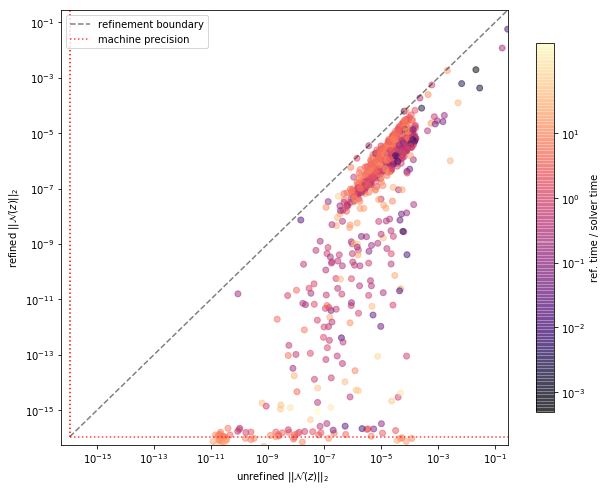

In [10]:

unrefined_Nzs = np.array([el['unrefined_resnorm'] for el in experiment_results])
refined_Nzs  = np.array([el['refined_resnorm'] for el in experiment_results])
timeratio = np.log10(np.array([(el['refine_time']) / (el['solver_time']) for el in experiment_results]))

#EPS = 2**(-53)  ##machine precision
maxval = max(unrefined_Nzs)
#plt.figure(figsize=(12,6))
fig, left = plt.subplots(1,1,figsize=(10,8))
left.set_xscale('log')
left.set_yscale('log')
col = left.scatter(unrefined_Nzs, refined_Nzs, 
                  c = timeratio, 
                  alpha=.5, 
                  cmap='magma'
                 )
cbar = fig.colorbar(col, shrink=.85, 
                   ticks=[-3, -2, -1 , 0, 1])
cbar.ax.set_yticklabels(['$10^{-3}$', '$10^{-2}$', '$10^{-1}$' , '$10^0$', '$10^1$'])

cbar.ax.set_ylabel('ref. time / solver time')

left.set_xlabel('unrefined $\||\mathcal{N}(z) \||_2$  ')
left.set_ylabel('refined $\||\mathcal{N}(z) \||_2$')
#plt.title('Suboptimality Comparison')
left.plot([EPS,10],[EPS,10], 'k--' , alpha= .5,label='refinement boundary')
plt.plot([EPS,maxval],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
plt.plot([EPS,EPS],[EPS, maxval], 'r:')
left.legend(loc='upper left')
left.set_xlim([EPS/2, maxval])
left.set_ylim([EPS/2, maxval])

plt.savefig('comparison_long_refine.png')

In [18]:
# plt.figure(figsize=(8,6))
# plt.hist(refined_Nzs / unrefined_Nzs, bins = 50)
# plt.xlabel('refined $\||\mathcal{N}(z) \||_2$ / unrefined $\||\mathcal{N}(z) \||_2$ ')

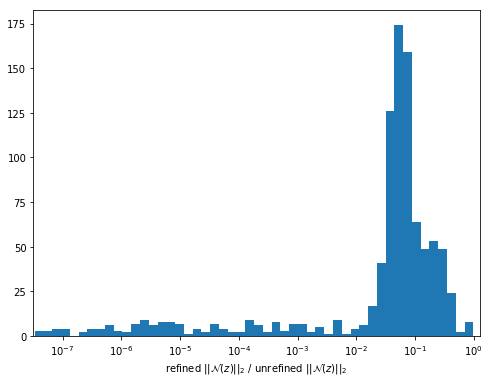

In [7]:
plt.figure(figsize=(8,6))

samples = np.log10(refined_Nzs / unrefined_Nzs)

samples = samples[samples>-7.5]
plt.hist(samples, bins = 50)
plt.xlim([-7.5, .1])
plt.xlabel('refined $\||\mathcal{N}(z) \||_2$ / unrefined $\||\mathcal{N}(z) \||_2$ ')
plt.xticks(range(-7,1), ['$10^{%d}$'%i for i in range(-7,1)])

plt.savefig('improvement_long_refine.png')

In [20]:
# plt.figure(figsize=(8,6))

# samples = np.log10(refined_Nzs / unrefined_Nzs)

# samples = samples[samples>-5]
# plt.hist(samples, bins = 50)
# plt.xlabel('refined $\||\mathcal{N}(z) \||_2$ / unrefined $\||\mathcal{N}(z) \||_2$ ')

#### Ranges of n and m 

In [22]:
n_s = np.array([el['(m,n)'][0] for el in experiment_results])
m_s = np.array([el['(m,n)'][1] for el in experiment_results])

(array([169., 178., 181., 137., 122.,  87.,  63.,  32.,  11.,   5.]),
 array([1.0000e+00, 1.6640e+02, 3.3180e+02, 4.9720e+02, 6.6260e+02,
        8.2800e+02, 9.9340e+02, 1.1588e+03, 1.3242e+03, 1.4896e+03,
        1.6550e+03]),
 <a list of 10 Patch objects>)

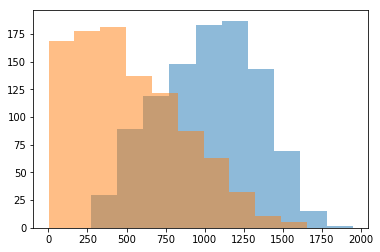

In [23]:
plt.hist(n_s, alpha=.5),
plt.hist(m_s, alpha=.5)

In [24]:
(np.quantile(n_s, .1), np.quantile(n_s, .9)), (np.quantile(m_s, .1), np.quantile(m_s, .9))

((581.0, 1423.0), (96.4, 1019.0))

#### Alternate plot 

/Users/enzo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


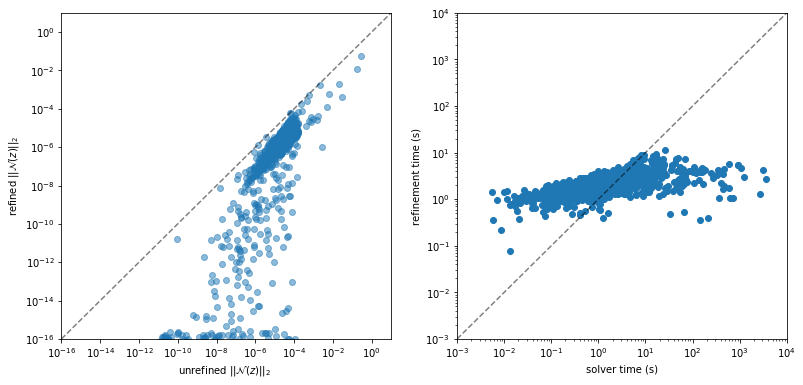

In [8]:
unrefined_Nzs = np.array([el['unrefined_resnorm'] for el in experiment_results])
refined_Nzs  = np.array([el['refined_resnorm'] for el in experiment_results])
timeratio = np.log10(np.array([(el['refine_time']) / (el['solver_time']) for el in experiment_results]))

EPS = 1E-16
maxval = max(unrefined_Nzs)
#plt.figure(figsize=(12,6))
fig, (left,right) = plt.subplots(1,2,figsize=(13,6))
left.set_xscale('log')
left.set_yscale('log')
col = left.scatter(unrefined_Nzs, refined_Nzs, 
                  #c = timeratio, 
                  alpha=.5, 
                  #cmap='seismic'
                 )
# cbar = plt.colorbar(col, shrink=.85, 
#                     ticks=[-2, -1 , 0])
# cbar.ax.set_yticklabels(['$10^{-2}$', '$10^{-1}$' , '$10^0$'])


# cbar.ax.set_ylabel('ref. time / solver time')

left.set_xlabel('unrefined $\||\mathcal{N}(z) \||_2$  ')
left.set_ylabel('refined $\||\mathcal{N}(z) \||_2$')
#plt.title('Suboptimality Comparison')
left.plot([EPS,10],[EPS,10], 'k--' , alpha= .5)#,label='refinement boundary')
#plt.plot([EPS,maxval],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
#plt.plot([EPS,EPS],[EPS, maxval], 'r:')
#left.legend(loc='upper left')
left.set_xlim([EPS, 10.])
left.set_ylim([EPS, 10.])

right.set_xscale('log')
right.set_yscale('log')
right.scatter( [ el['solver_time']  for el in experiment_results],
[el['refine_time'] for el in experiment_results])
right.set_xlim([0.001,10000])
right.set_ylim([0.001,10000])
right.plot([0.001,10000],[0.001,10000], 'k--' , alpha= .5,label='refinement boundary')
right.set_xlabel('solver time (s)')
right.set_ylabel('refinement time (s)')




plt.savefig('comparison_alternate_long_refine.png')

#### Ranges of refinement and solver times

In [31]:
soltime = [ el['solver_time']  for el in experiment_results]
reftime = [ el['refine_time']  for el in experiment_results]

(np.quantile(soltime, .1), np.quantile(soltime, .9)), (np.quantile(reftime, .1), np.quantile(reftime, .9))

((0.08795013427734374, 12.540558242797857),
 (0.14479057788848876, 0.6941631555557252))

(-4, 2)

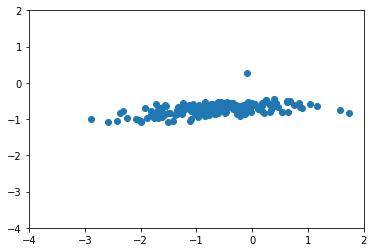

In [16]:
plt.scatter( 
            np.log10([ el['solver_time']  for el in experiment_results]),
np.log10([el['refine_time'] for el in experiment_results]))
plt.xlim([-4,2])
plt.ylim([-4,2])

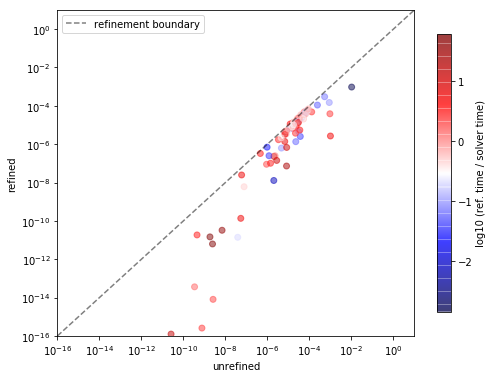

In [6]:
unrefined_Nzs = np.array([el['unrefined_resnorm'] for el in experiment_results])
refined_Nzs  = np.array([el['refined_resnorm'] for el in experiment_results])
timeratio = np.log10(np.array([el['refine_time'] / el['solver_time'] for el in experiment_results]))

EPS = 1E-16
maxval = max(unrefined_Nzs)
#largest = np.max(np.max(scs_subopts), np.max(con_subopts))
plt.figure(figsize=(8,6))
plt.yscale('log')
plt.xscale('log')
col = plt.scatter(unrefined_Nzs, refined_Nzs, c = timeratio, alpha=.5, cmap='seismic')
cbar = plt.colorbar(col, shrink=.85)
cbar.ax.set_ylabel('log10 (ref. time / solver time)')

plt.xlabel('unrefined')
plt.ylabel('refined')
#plt.title('Suboptimality Comparison')
plt.plot([EPS,10],[EPS,10], 'k--' , alpha= .5,label='refinement boundary')
#plt.plot([EPS,maxval],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
#plt.plot([EPS,EPS],[EPS, maxval], 'r:')
plt.legend(loc='upper left')
plt.xlim([EPS, 10.])
plt.ylim([EPS, 10.])



###100 points, prenumba, eps=1e-6
plt.savefig('comparison.png')

## Interactive plot 

In [61]:
from bokeh.plotting import figure 
from bokeh.io import output_notebook, show

In [62]:
output_notebook()


Loading BokehJS ...

In [90]:
import pandas as pd
results = pd.DataFrame(data=experiment_results)
results['unrefined_logresnorm'] = np.log10(results['unrefined_resnorm'])
results['refined_logresnorm'] = np.log10(results['refined_resnorm'])

In [91]:
p1 = figure()
p1.scatter(results['unrefined_logresnorm'], results['refined_logresnorm'] )
p1.

#p1.line([EPS, maxval], [EPS, maxval], line_width=2)


show(p1)

In [2]:
greater_than_eps = lambda x: not (1 + x == 1)

def find_eps(prec=1e-30):
    result = 1.
    while greater_than_eps(result):
        result /= 2
    lower = result
    upper = result*2
    while upper-lower>prec:
        mid = (lower + upper)/2
        if greater_than_eps(mid):
            upper = mid
        else:
            lower = mid
    return lower
        
EPS = find_eps()
assert (1 + EPS == 1)
assert not (1 + EPS + 1e-8 == 1)
print('numerical precision of float sum ~', EPS)

print('52 bits mantissa, 2^-53 =', 2**(-53))

numerical precision of float sum ~ 1.1102230246251565e-16
52 bits mantissa, 2^-53 = 1.1102230246251565e-16


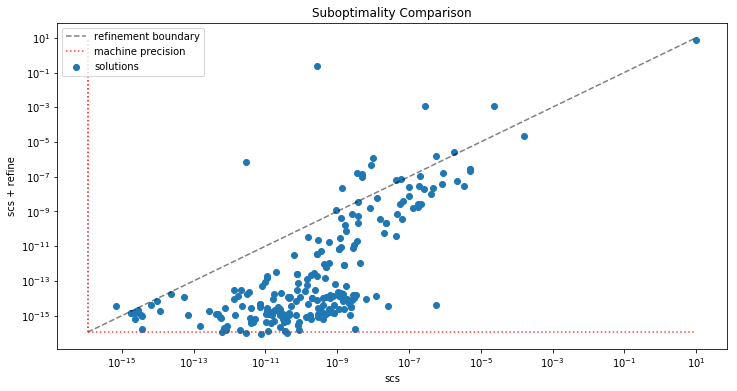

In [86]:
largest = max(max(scs_subopts), max(con_subopts))
plt.figure(figsize=(12,6))
plt.yscale('log')
plt.xscale('log')
plt.scatter(scs_subopts, con_subopts, label='solutions')
plt.xlabel('scs')
plt.ylabel('scs + refine')
plt.title('Suboptimality Comparison')
plt.plot([EPS,largest],[EPS,largest], 'k--', alpha= .5,label='refinement boundary')
plt.plot([EPS,largest],[EPS, EPS], 'r:', alpha= .75, label='machine precision')
plt.plot([EPS,EPS],[EPS, largest], 'r:')
plt.legend(loc='upper left')
#plt.savefig('comparison.png')